# The _Aedes aegypti_ Ejaculotome
## Proteomics and RNAseq analysis pipeline
### author: Yasir H. Ahmed-Braimah

Several data sources were generated for this project, first, proteomic data was obtained ....

In addition, several RNAseq runs of the male accessory glands (before and after mating) and testes were obtained using 3'RNAseq.

We also include analysis of publicly avaialable RNAseq data.

The analysis workflow (read mapping, transcript assembly, and abundance estimation) is available through GitHub (***link Snakemake GitHub page here***).

### Load the required packages and raw data files:

Load the reuired R packages for analyses/plotting:

In [1]:
req_packages = c("AnnotationHub", "Biobase", "cluster", "clusterProfiler","cowplot", 
                 "data.table", "dplyr","DESeq", "edgeR", "genefilter", "ggplot2", 
                 "ggrepel", "ggpubr", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", 
                 "heatmap3", "imager", "lattice", "pheatmap","plotly", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", "stringr", "tidyr", "tidyverse",
                 "VennDiagram", "viridis","wesanderson")

invisible(suppressWarnings(suppressMessages(lapply(req_packages, require, character.only = TRUE))))

The Cowplot package changes the default themes of ggplot2. Set the default theme like so:

In [2]:
theme_set(theme_gray())

The VennDiagram package produces log files for each plot. We can disable that like so:

In [3]:
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

NULL

In addition, several custom plotting and annotation functions are available in the `Functions2.R` file, so load as source:

In [4]:
source("R_functions.R")

Now load the raw count matrices for genes and transcripts. Note that the gene/transcript IDs are designated by the StringTie program, and either contain the "MSTRG" prefix (unique splice/exon relative to annotation features) or the "AAEL" prefix (perfect match to annotated feature)

In [5]:
geneCounts = read.csv(file = "expression_data/gene_counts.csv", header = T, sep = ",", row.names = 1)
transcriptCounts = read.csv(file = "expression_data/transcript_counts.csv", header = T, sep = ",", row.names = 1)

There're several anotation files that were generated through Trinotate, downloaded from VectorBase, or produced along with the proteomics run. We'll use these files throughout the analysis. 

First, the gene features file has the coordinates, StringTie gene/transcript IDs and VectorBase gene/transcript names where avilable:

In [6]:
gene.features = read.table("annotation/features.txt", header = T)

We'll create a subset of the gene features that includes only VectorBase annotated features:

In [7]:
annot.gene.features = subset(gene.features, ref_gene_id != "NA")

The original NCBI GenBank annotation of the AegL5 genome included additional protein descriptions as well:

In [8]:
genbank_proteins = read.csv("annotation/Protein_annotation.txt", header =T, sep = "\t")

The gene/transcript IDs in `genbank_proteins` are those designated by NCBI ("LOC" prefix). We generated a file to match these RefSeq IDs with the latest VectorBae IDs. If a RefSeq record does not exist for a given VectorBase ID, that typically means the VectorBase feature is not a protein:

In [9]:
RefSeq_ids = read.csv("annotation/VB.L5.transcript_gene_RefSeq.txt", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)

A summary of gene descriptions and gene names (wherever available) can be found in the VectorBase annotation GTF. We've extracted that information from the GTF in the form of a table:

In [10]:
AaegL5_annotation = read.csv("annotation/AaegL5.gene.annotation.txt", header = T, sep = "\t")

Information about annotation type is in this file:

In [11]:
coding_info = read.csv("proteomics/lncRNAS_protein_coding.txt", header = T, sep = "\t")

Our custom annotation is generated using the Trinotate workflow (***link Snakemake GitHub page here***), which is a massive file with lots of annotation information. The gene descriptinos here come from a BlastX and BlastP search against the SwissProt database, but the raw entry in the Trinotate file is a bit combursome. We extract the relevant descriptions and append them as the last two columns of the file:

In [12]:
trinotate = read.csv("annotation/Trinotate_report.xls_with_description_columns.txt", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)

The Trinotate pipeline produces extensive Gene Ontology (GO) terms associated with each gene. We can use this data for GO enrichment analysis later on.

In [13]:
GO_info = read.csv("annotation/Trinotate_report.xls.gene_ontology", header=F, row.names=1, sep = "\t", stringsAsFactors=F)

VectorBase also provides more concise GO information, but only ~10K genes have such annotations. Might be useful later:

In [14]:
VB_GO_info = read.csv("annotation/VB_GO_info.txt", header = F, sep = "\t")
VB_GO_info = VB_GO_info[!duplicated(VB_GO_info$V1),]
rownames(VB_GO_info) = VB_GO_info$V1
VB_GO_info = subset(VB_GO_info, select = "V2")

For the GO enrichment analysis, we'll need gene lengths. We've extracted transcript lengths from the GTF file, and can load those first

In [15]:
trans_lengths = read.csv("annotation/transcript_lengths.txt", header = T, sep = " ")

We can obtain gene lengths for each gene by capturing the length of the longest transcript. One way to do that is as follows:

In [16]:
# Merge transcript length file with gene features file:
tmpMrge = merge(trans_lengths, gene.features)
# Select only the length and gene_id columns
tmpMrge = as.data.table(subset(tmpMrge, select = c("length", "gene_id")))
# For each gene ID entry, select the entry with largest value in the "length" column:
gene_lengths = tmpMrge[tmpMrge[, .I[which.max(length)], by=gene_id]$V1]
# remove un-needed intermediate objects
rm(tmpMrge)

So far we have several types of gene IDs, several sources of gene descriptions etc. For convenience, we might want to create a unified features object that can be incorporated into the edgeR DE objects. Here's one format for this:

In [17]:
# Select only gene IDs from the gene.features object, and make unique:
gene_id_and_ref_gene_id = unique(subset(gene.features, select = c("gene_id", "ref_gene_id")))
# Select only the gene ID and protein description from the RefSeq Ids object
tmpRef = unique(subset(RefSeq_ids, select = c("gene_ID", "RefSeq_protein_name")))

# Now merge those two objects, then sequentially merge the GenBank object and the VectorBase annotation:
gene_id_and_ref_gene_id = merge(tmpRef, gene_id_and_ref_gene_id, by.x="gene_ID", by.y="ref_gene_id", all = TRUE)
gene_id_and_ref_gene_id = merge(gene_id_and_ref_gene_id, genbank_proteins, by.x="RefSeq_protein_name", by.y="protein_name", all = TRUE)
merged_gene_features = merge(gene_id_and_ref_gene_id, AaegL5_annotation, by.x="gene_ID", by.y="gene_id", all = TRUE)

# Rename the columns to something descriptive:
colnames(merged_gene_features) = c("gene_ID", "RefSeq_protein", "mstrg_ID", "transcript_ID", "loc_ID",    "GenBank_description", "gene_name", "VB_description")

# We can choose a subset of these columns for the active fatures table (The GenBank description seems the most conplete):
geneFeatures = unique(subset(merged_gene_features, select = c("mstrg_ID", "gene_ID", "loc_ID", "gene_name", "GenBank_description")))

Some of these species have excellent annotations, which we can utilize later on. For instance, here's the _Anopheles gambiae_ annotation from its ENSMBL GTF file:

In [18]:
AgamP4_annotation = read.csv("annotation/other_species/AgamP4.protein.annotation.txt", header = T, sep = "\t")

From Alfonso-Parra _et al._ (2016) we have the list of transferred male mRNAs at 0hpm. We'll load those here:

In [19]:
tmRNA = read.csv("annotation/Alfonso_Parra_transfered_mRNA.list", header = F)
tmRNA.df = data.frame(gene_ID = tmRNA$V1, mRNA_transfer = "yes")

Finally, we'll input the sample information and add sample features based on sample names:

In [20]:
# Load the file and rename the columns:
sampleData = read.table("annotation/sample_replicate_map.txt", header=F, check.names=F, fill=T)
sampleData = sampleData[sampleData[,2] != '',]
colnames(sampleData) = c("Sample", "Replicate")

## Add a tissue column
sampleData$Tissue = ifelse(grepl("MAG", sampleData$Sample, ignore.case = F), "MAG", ifelse(grepl("TS", sampleData$Sample, ignore.case = F), "Testes", ifelse(grepl("testes", sampleData$Sample, ignore.case = F), "Testes", ifelse(grepl("RT", sampleData$Sample, ignore.case = F), "fRT", ifelse(grepl("CR", sampleData$Sample, ignore.case = F), "carcass", "Sperm")))))

## Add a source column
sampleData$Source = ifelse(grepl("RT", sampleData$Sample, ignore.case = F), "Alfonso-Parra", ifelse(grepl("MAG", sampleData$Sample, ignore.case = F), "Degner", ifelse(grepl("testes", sampleData$Sample, ignore.case = F), "Degner", ifelse(grepl("Ma_CR", sampleData$Sample, ignore.case = F), "Akbari", ifelse(grepl("Ma_TS", sampleData$Sample, ignore.case = F), "Akbari", "Sutton")))))

### Processing the expression data:

First, we have to filter out genes with very low expression from the counts matrix. We'll use a minimum cutoff of 5 CPM in at least 4 samples:

In [21]:
gene.CPM <- cpm(geneCounts)
thresh <- gene.CPM > 5
keep <- rowSums(thresh) >= 4
counts.keep <- geneCounts[keep,]
dim(counts.keep)

[1] 12340    26

Using the threshold above applies well for Ethan's data (note the 3' read difference with other samples). If we filter low expression data at 10 CPM, that's equal to an average of 150 reads/gene for Ethan's data.

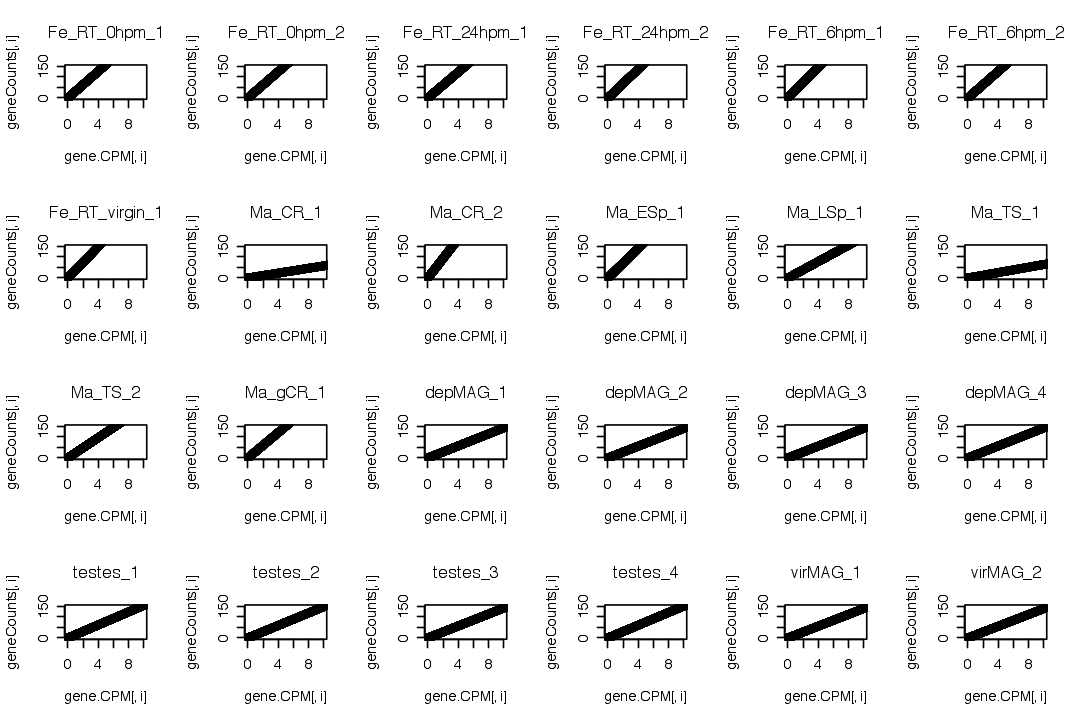

In [22]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(4,6))
for(i in seq(from=1, to=24, by=1)){
  plot(gene.CPM[,i],geneCounts[,i], xlim=c(0,10), ylim=c(0,150))
  title(colnames(gene.CPM)[i])
}

To obtain a TPM matrix of the combined data, we'll need to separate the 3'RNAseq data (Ethan's) from the rest, obtain TPM normalizations separately, then combine the matrices. First, we'll do Ethan's data (pick any number for gene length. Here I chose the average gene length of 2922):

In [23]:
ethan.countsMatrix = subset(geneCounts, select=c("depMAG_1", "depMAG_2", "depMAG_3", "depMAG_4", "testes_1", "testes_2", "testes_3", "testes_4", "virMAG_1", "virMAG_2", "virMAG_3", "virMAG_4"))
ethan.geneTPM <- apply(ethan.countsMatrix, 2, function(x) tpm(x, 2922))
ethan.geneTPM = as.data.frame(ethan.geneTPM)

Now we'll TPM normalize the remainder. For that we'll need to match the gene length data frame with the counts matrix data frame:

In [24]:
rest.countsMatrix = subset(geneCounts, select=c("Fe_RT_0hpm_1", "Fe_RT_0hpm_2", "Fe_RT_24hpm_1", "Fe_RT_24hpm_2", "Fe_RT_6hpm_1", "Fe_RT_6hpm_2", "Fe_RT_virgin_1", "Ma_CR_1", "Ma_CR_2", "Ma_ESp_1", "Ma_LSp_1", "Ma_TS_1", "Ma_TS_2", "Ma_gCR_1"))
rest.geneTPM <- apply(rest.countsMatrix, 2, function(x) tpm(x, gene_lengths$length))
rest.geneTPM = as.data.frame(rest.geneTPM)

Now we can combine both TPM matrices:

In [25]:
geneTPM = cbind(rest.geneTPM, ethan.geneTPM)

We'll need to reshape the TPM matrix to calculate means and for convenient heatmap and gene plotting later:

In [26]:
tmp.tpmMatrix<-geneTPM
colnames(tmp.tpmMatrix) <- sampleData$Sample
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "sample", "TPM")

tmp.tpmMatrix.m$Tissue = ifelse(grepl("MAG", tmp.tpmMatrix.m$sample, ignore.case = F), "MAG", ifelse(grepl("TS", tmp.tpmMatrix.m$sample, ignore.case = F), "Testes", ifelse(grepl("testes", tmp.tpmMatrix.m$sample, ignore.case = F), "Testes", ifelse(grepl("RT", tmp.tpmMatrix.m$sample, ignore.case = F), "fRT", ifelse(grepl("CR", tmp.tpmMatrix.m$sample, ignore.case = F), "carcass", "Sperm")))))

tmp.tpmMatrix.m$Source = ifelse(grepl("RT", tmp.tpmMatrix.m$sample, ignore.case = F), "Alfonso-Parra", ifelse(grepl("MAG", tmp.tpmMatrix.m$sample, ignore.case = F), "Degner", ifelse(grepl("testes", tmp.tpmMatrix.m$sample, ignore.case = F), "Degner", ifelse(grepl("Ma_CR", tmp.tpmMatrix.m$sample, ignore.case = F), "Akbari", ifelse(grepl("Ma_TS", tmp.tpmMatrix.m$sample, ignore.case = F), "Akbari", "Sutton")))))

TPM.table = tmp.tpmMatrix.m

Now we'll calculate the TPM mean and standard deviation/error for each gene across samples (warning: this will take a few minutes):

In [27]:
# tmp.tpmMatrix.m.c = summarySE(TPM.table, measurevar = "TPM", groupvars = c("gene_id", "sample", "Tissue", "Source"))

#### The above step is cumbersome. We'll save a file and read it in as an object.
# write.table(x = tmp.tpmMatrix.m.c, file = "expression_data/tmp.tpmMatrix.m.c.txt", quote = F, sep = "\t", row.names = F)

TPMse = read.table(file = "expression_data/tmp.tpmMatrix.m.c.txt", header = T, sep = "\t")

We can use the TPM means to make a mean TPM matrix for heatmaps:

In [28]:
tmpTPM.Mat <- cast(TPMse, gene_id~sample, value = "TPM")
meanTPMmatrix <- tmpTPM.Mat[,-1]
rownames(meanTPMmatrix) <- tmpTPM.Mat[,1]

We can feed a subset of the annotation data to the DGElist object in edgeR. We'll create that subset like so (mstrg_IDs must match the gene IDs in the counts matrix, and can't be duplicated):

In [29]:
annots = unique(subset(geneFeatures, select=c("mstrg_ID", "gene_ID", "gene_name", "GenBank_description")))
annots = annots[!duplicated(annots$mstrg_ID),]

We'll set the factor level for samples in the `TPMse` dataframe so that samples are ordered the way we want:

In [30]:
TPMse$sample = factor(TPMse$sample, levels = c("Fe_RT_virgin", "Fe_RT_0hpm", "Fe_RT_6hpm", "Fe_RT_24hpm", "Ma_CR", "Ma_TS", "Ma_gCR", "Ma_ESp", "Ma_LSp", "testes", "virMAG", "depMAG"))

TPM.table$sample = factor(TPM.table$sample, levels = c("Fe_RT_virgin", "Fe_RT_0hpm", "Fe_RT_6hpm", "Fe_RT_24hpm", "Ma_CR", "Ma_TS", "Ma_gCR", "Ma_ESp", "Ma_LSp", "testes", "virMAG", "depMAG"))

##### Comprehensive RNAseq dataset:

As part of a separate resource we have generated an extensive expression atlas for _Ae. aegypti_, which we can be useful in this study. A function for plotting individual gene express data is included in the functions file that we loaded above. The expression data can be loaded here:

In [31]:
compRNAseq = read.csv("expression_data/aegypti_comp_RNAseq_data_v2.txt", header = T, sep = "\t")

An example of plotting a given gene's expression is given below:

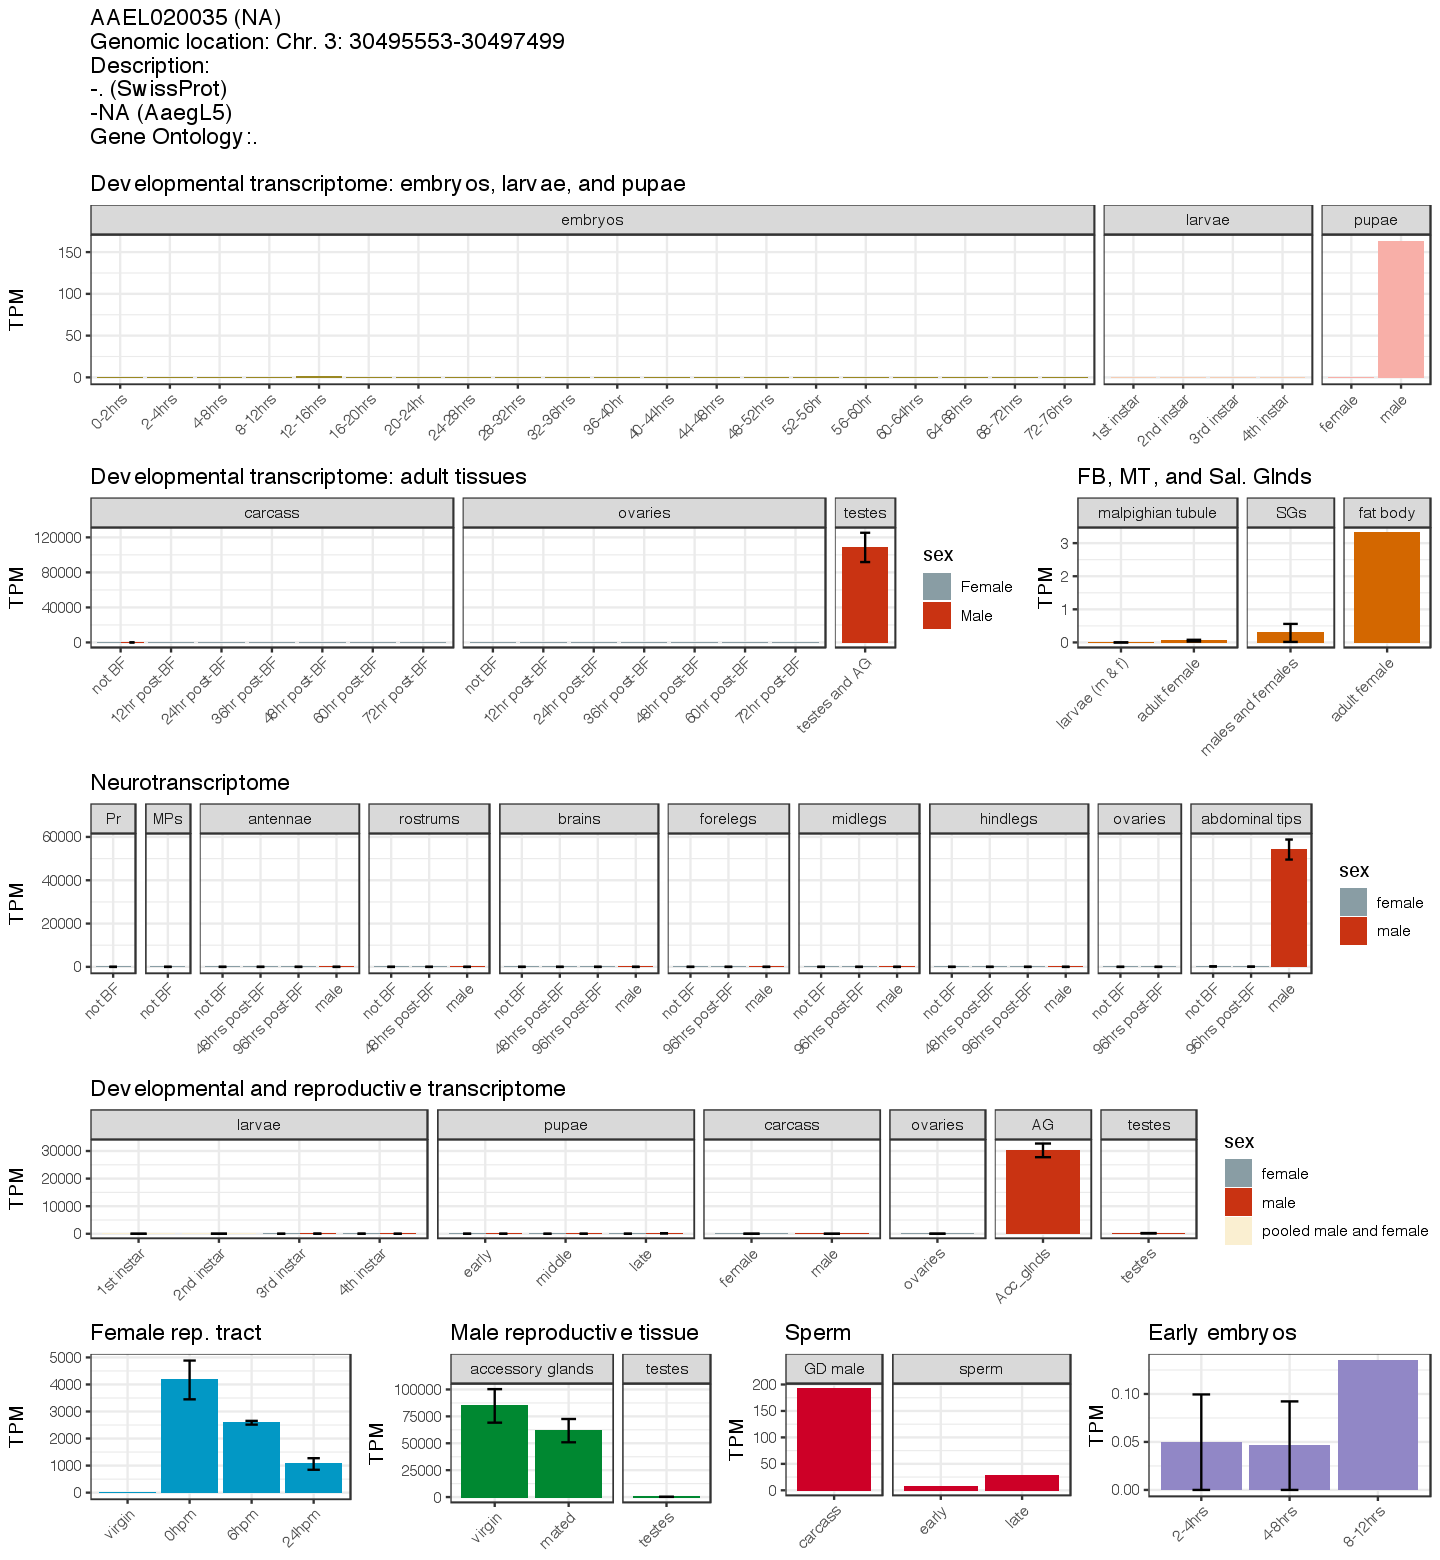

In [32]:
options(repr.plot.width = 12, repr.plot.height = 13)
suppressWarnings(compGeneBarplot("AAEL020035"))

## Differential expression: tissue-biased reproductive genes:

Here we'll define several classes of genes based on their tissue-biased expression pattern. Those will include: (1) testes-biased geens, (2) MAG-biased genes, and (3) female RT-biased genes. Because there are several ways to specify tissue bias, we'll use three classifications for each tissue: (1) extremely biased (≥4-fold difference in expression relative to other tissue, and FDR ≤ 0.01), (2) DE biased (≥2-fold, FDR ≤ 0.05), and (3) biased (≥1-fold, FDR ≤ 0.05). We'll also define a class of genes that show detectable expression in a given tissue, regardless of expression in other tissues (TPM > 1). 

The design matrix will include all samples in our expression matrix, but we'll only define the above gene classes for the virMAG, Fe_RT_virgin, and testes samples. First we'll determine the grouping of samples and set-up the model matrix:

In [33]:
groups = factor(sampleData$Sample)
design = model.matrix( ~ 0 + groups)
colnames(design) <- levels(groups)
rownames(design) <- sampleData$Replicate

Now we'll create the edgeR DGE object with these groupings and fit the generalized linear model:

In [34]:
dgeList <- DGEList(counts = counts.keep, group = groups)
dgeList <- calcNormFactors(dgeList)
dgeList <- estimateCommonDisp(dgeList)
dgeList <- estimateTagwiseDisp(dgeList)
dgeList_fit <- glmFit(dgeList, design)

Now we can add the subsetted annotation information we created previously to the fit object. We check that there're a one to one match between the fit object's rownames (genes) and the annotation file's gene IDs:

In [35]:
# Extract annotation for genes in the fit object
ann = subset(annots, mstrg_ID %in% rownames(dgeList_fit))
# convert factors to characters
ann = data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann = ann[match(rownames(dgeList_fit), ann$mstrg_ID),]
# convert factors to characters, again
ann <- data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann) = c ("GeneID", "VB_ID", "gene_name","Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann$GeneID==rownames(dgeList_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList_fit$genes = ann


 TRUE 
12340 

We can take a quick look at the basic variability metrics by examining the tagwise dispersion:

In [36]:
summary(dgeList$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.04714 0.07948 0.13288 0.22245 0.24372 6.27229 

We can take a closer look at the DE metrics and whether overall variability in the counts is suitable by plotting the BCV, looking at the mean-variance trend and QQplot. We'll also make a boxplot of normalized counts:

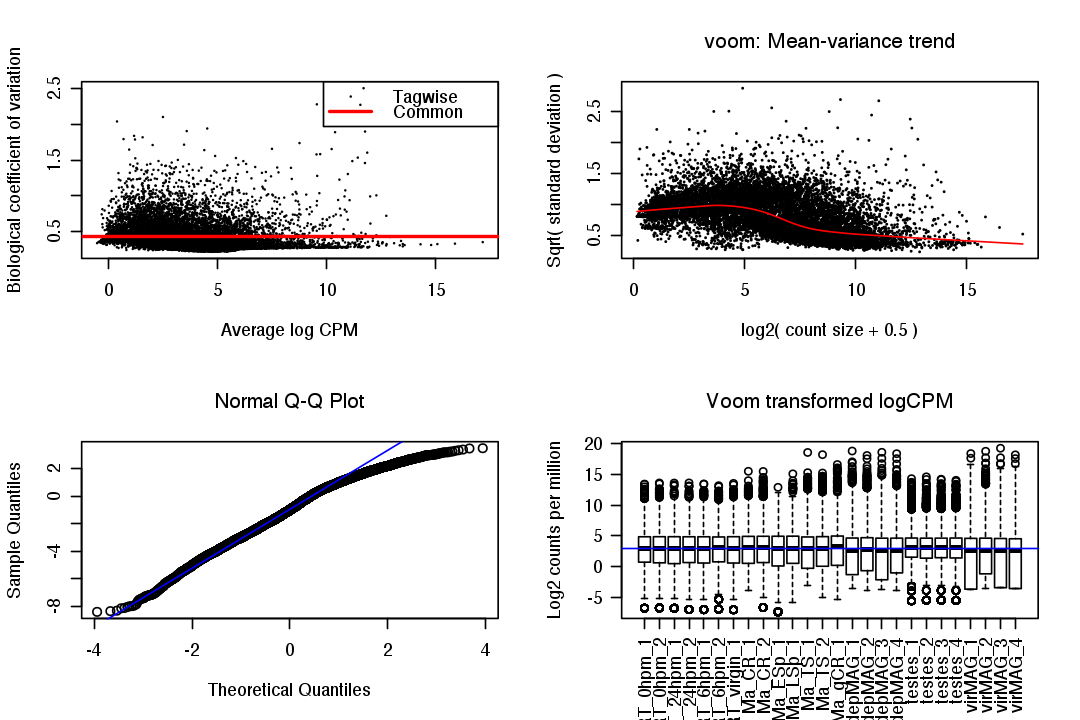

In [37]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList)
# mean-variance trend
voomC = voom(dgeList, design, plot=TRUE)
# QQ-plot
g <- gof(dgeList_fit)
z <- zscoreGamma(g$gof.statistics,shape=g$df/2,scale=2)
qqnorm(z); qqline(z, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(voomC$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voomC$E),col="blue")

An interactive MDS plot gives an idea of how replicates/samples are grouping:

In [38]:
glMDSPlot(dgeList, groups = dgeList$samples$group, labels = sampleData$Tissue)

... or a static plot works too:

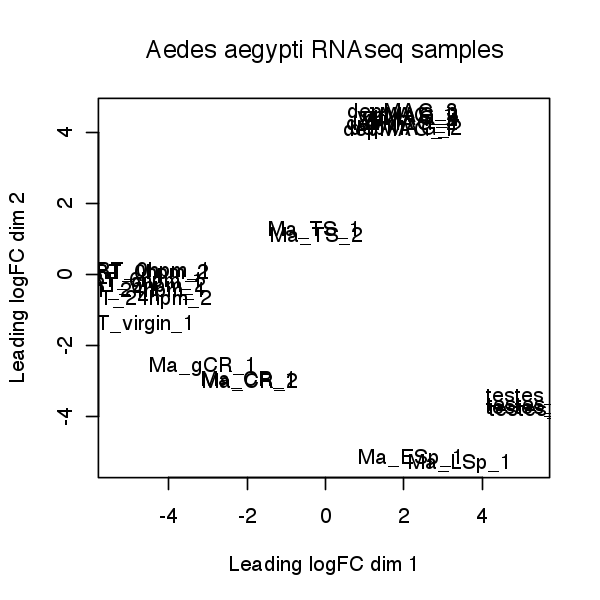

In [39]:
options(repr.plot.width = 5, repr.plot.height = 5)
plotMDS(dgeList)
title("Aedes aegypti RNAseq samples")

A heatmap of sample correlations is also useful

for plotting:: min.raw: 0.0808748122648092 max.raw: 1


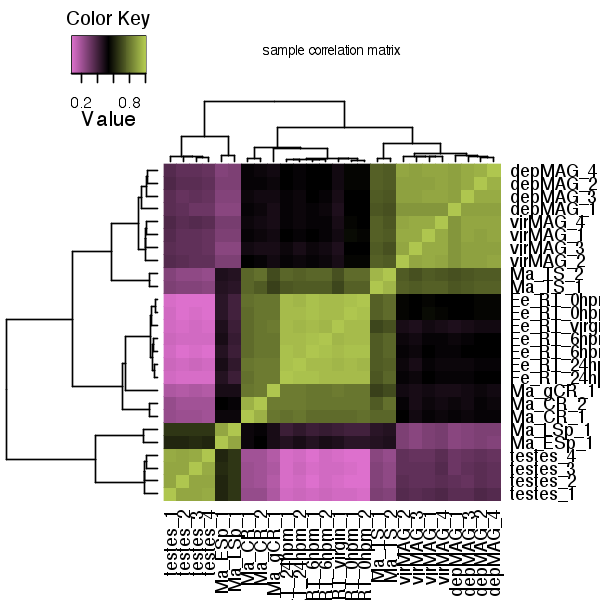

In [40]:
data = log2(counts.keep+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')

options(repr.plot.width = 5, repr.plot.height = 5)
heatmap.3(sample_cor, dendrogram='both', Rowv=as.dendrogram(hc_samples), Colv=as.dendrogram(hc_samples), col = colorpanel(75, '#dd70cd','black','#afc64f'), scale='none', symm=TRUE, key=TRUE,density.info='none', trace='none', symkey=FALSE, symbreaks=F, cexCol=1, cexRow=1, cex.main=0.75, main=paste("sample correlation matrix"))

Now we're ready to define the contrasts. For the three samples we'd like to define gene classes for, the following contrasts can be defined:

In [41]:
testes.v.rest <- makeContrasts(testes.v.gCR=testes-Ma_gCR,
                                 testes.v.MAG=testes-virMAG,
                                 testes.vs.fRT=testes-Fe_RT_virgin,
                                 levels=design)
MAG.v.rest <- makeContrasts(MAG.v.gCR=virMAG-Ma_gCR,
                                 MAG.v.testes=virMAG-testes,
                                 MAG.vs.fRT=virMAG-Fe_RT_virgin,
                                 levels=design)
fRT.v.rest <- makeContrasts(fRT.v.Ma_CR=Fe_RT_virgin-Ma_CR,
                            fRT.v.testes=Fe_RT_virgin-testes,
                            fRT.v.MAG=Fe_RT_virgin-virMAG,
                            levels=design)
virginfRT.v.0hpm <- makeContrasts(vFRT.v.0hpm=Fe_RT_0hpm-Fe_RT_virgin,
                                 levels=design)

## Defining tissue-biased classes of genes:

To identify those classes of genes, we'll perform a likelihood ratio test on the GLM fit object that compares the testes sample to the gonadectomized carcass sample, the MAG sample, and the virgin female RT sample. We'll then define the three classes of testes-biased genes and those that show detectable expression in the testes:

##### Classes of testes genes:

In [42]:
# LRT tests
lrt.testes <- glmLRT(dgeList_fit, contrast = testes.v.rest)

# Extract the DE data
lrt.testes.tTags <- topTags(lrt.testes, n = NULL)

# Make a table of DE stats
lrt.testes.tTags.table <- lrt.testes.tTags$table

# Define the first class: Extremely biased
testes.extreme.list <- subset(lrt.testes.tTags.table, logFC.testes.v.gCR > 2 & logFC.testes.v.MAG > 2 & logFC.testes.vs.fRT > 2 & FDR<0.05)$GeneID
testes.extreme.list.vb <- subset(lrt.testes.tTags.table, logFC.testes.v.gCR > 2 & logFC.testes.v.MAG > 2 & logFC.testes.vs.fRT > 2 & FDR<0.05 & VB_ID != "NA")$VB_ID

# Define the second class: DE biased
testes.DEup.list <- subset(lrt.testes.tTags.table, logFC.testes.v.gCR > 1 & logFC.testes.v.MAG > 1 & logFC.testes.vs.fRT > 1 & FDR<0.05)$GeneID
testes.DEup.list.vb <- subset(lrt.testes.tTags.table, logFC.testes.v.gCR > 1 & logFC.testes.v.MAG > 1 & logFC.testes.vs.fRT > 1 & FDR<0.05 & VB_ID != "NA")$VB_ID
# Define the third class: biased
testes.up.list <- subset(lrt.testes.tTags.table, logFC.testes.v.gCR > 0 & logFC.testes.v.MAG > 0 & logFC.testes.vs.fRT > 0 & FDR<0.05)$GeneID

# Finally, we'll make a list of all the genes that show detectable testes expression (TPM > 1):
testes.expressed.list <- rownames(subset(meanTPMmatrix, testes > 1))


# For each of these we can pull out those that are previously annotated
testes.extreme.list.CDS = unique(subset(gene.features, gene_id %in% testes.extreme.list & ref_gene_id != "NA")$gene_id)
testes.DEup.list.CDS = unique(subset(gene.features, gene_id %in% testes.DEup.list & ref_gene_id != "NA")$gene_id)
testes.up.list.CDS = unique(subset(gene.features, gene_id %in% testes.up.list & ref_gene_id != "NA")$gene_id)
testes.expressed.list.CDS = unique(subset(gene.features, gene_id %in% testes.expressed.list & ref_gene_id != "NA")$gene_id)


paste("The number of gene transcripts with >4-fold DE testis-biased expression is: ", length(testes.extreme.list), ", of which ", length(testes.extreme.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with >2-fold DE testis-biased expression is: ", length(testes.DEup.list), ", of which ", length(testes.DEup.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with >1-fold DE testis-biased expression is: ", length(testes.up.list), ", of which ", length(testes.up.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with detectable testis expression is: ", length(testes.expressed.list), ", of which ", length(testes.expressed.list.CDS), " are annotated. ", sep="")

[1] "The number of gene transcripts with >4-fold DE testis-biased expression is: 2304, of which 1260 are annotated. "

[1] "The number of gene transcripts with >2-fold DE testis-biased expression is: 3013, of which 1928 are annotated. "

[1] "The number of gene transcripts with >1-fold DE testis-biased expression is: 4001, of which 2863 are annotated. "

[1] "The number of gene transcripts with detectable testis expression is: 17537, of which 10861 are annotated. "

We'll make a table summarizing the above lists (the fold bias refers to the fold change relative to other tissue samples used in the edgeR DE analysis above):

In [43]:
testes.4fold.df = data.frame(mstrg_ID = testes.extreme.list.CDS, testes_fourFold_bias = "yes", stringsAsFactors = FALSE)
testes.2fold.df = data.frame(mstrg_ID = testes.DEup.list.CDS, testes_twoFold_bias = "yes", stringsAsFactors = FALSE)
testes.1fold.df = data.frame(mstrg_ID = testes.up.list.CDS, testes_oneFold_bias = "yes", stringsAsFactors = FALSE)
testes.expressed.df = data.frame(mstrg_ID = testes.expressed.list.CDS, testes_expressed = "yes", stringsAsFactors = FALSE)

merge1st = (merge(testes.expressed.df, testes.1fold.df, by.x = "mstrg_ID", by.y = "mstrg_ID", all = T))
merge2nd = (merge(merge1st, testes.2fold.df, by.x = "mstrg_ID", by.y = "mstrg_ID", all = T))
testes.expression.status = (merge(merge2nd, testes.4fold.df, by.x = "mstrg_ID", by.y = "mstrg_ID", all = T))

testes.expression.status <- sapply(testes.expression.status, as.character)
testes.expression.status[is.na(testes.expression.status)] <- "no"
testes.expression.status <- as.data.frame(testes.expression.status, stringsAsFactors = FALSE)

##### Classes of accessory gland genes:

In [44]:
# LRT tests
lrt.MAG <- glmLRT(dgeList_fit, contrast = MAG.v.rest)

# Extract the DE data
lrt.MAG.tTags <- topTags(lrt.MAG, n = NULL)

# Make a table of DE stats
lrt.MAG.tTags.table <- lrt.MAG.tTags$table

# Define the first class: Extremely biased
MAG.extreme.list <- subset(lrt.MAG.tTags.table, logFC.MAG.v.gCR > 2 & logFC.MAG.v.testes > 2 & logFC.MAG.vs.fRT > 2 & FDR<0.05)$GeneID
MAG.extreme.list.vb <- subset(lrt.MAG.tTags.table, logFC.MAG.v.gCR > 2 & logFC.MAG.v.testes > 2 & logFC.MAG.vs.fRT > 2 & FDR<0.05 & VB_ID != "NA")$VB_ID

# Define the second class: DE biased
MAG.DEup.list <- subset(lrt.MAG.tTags.table, logFC.MAG.v.gCR > 1 & logFC.MAG.v.testes > 1 & logFC.MAG.vs.fRT > 1 & FDR<0.05)$GeneID
MAG.DEup.list.vb <- subset(lrt.MAG.tTags.table, logFC.MAG.v.gCR > 1 & logFC.MAG.v.testes > 1 & logFC.MAG.vs.fRT > 1 & FDR<0.05 & VB_ID != "NA")$VB_ID

# Define the third class: biased
MAG.up.list <- subset(lrt.MAG.tTags.table, logFC.MAG.v.gCR > 0 & logFC.MAG.v.testes > 0 & logFC.MAG.vs.fRT > 0 & FDR<0.05)$GeneID

# Finally, we'll make a list of all the genes that show detectable MAG expression (TPM > 1):
MAG.expressed.list <- rownames(subset(meanTPMmatrix, virMAG > 1))


# For each of these we can pull out those that are previously annotated
MAG.extreme.list.CDS = unique(subset(gene.features, gene_id %in% MAG.extreme.list & ref_gene_id != "NA")$gene_id)
MAG.DEup.list.CDS = unique(subset(gene.features, gene_id %in% MAG.DEup.list & ref_gene_id != "NA")$gene_id)
MAG.up.list.CDS = unique(subset(gene.features, gene_id %in% MAG.up.list & ref_gene_id != "NA")$gene_id)
MAG.expressed.list.CDS = unique(subset(gene.features, gene_id %in% MAG.expressed.list & ref_gene_id != "NA")$gene_id)


    paste("The number of gene transcripts with >4-fold DE MAG-biased expression is: ", length(MAG.extreme.list), ", of which ", length(MAG.extreme.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with >2-fold DE MAG-biased expression is: ", length(MAG.DEup.list), ", of which ", length(MAG.DEup.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with >1-fold DE MAG-biased expression is: ", length(MAG.up.list), ", of which ", length(MAG.up.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with detectable MAG expression is: ", length(MAG.expressed.list), ", of which ", length(MAG.expressed.list.CDS), " are annotated. ", sep="")

[1] "The number of gene transcripts with >4-fold DE MAG-biased expression is: 706, of which 299 are annotated. "

[1] "The number of gene transcripts with >2-fold DE MAG-biased expression is: 1237, of which 711 are annotated. "

[1] "The number of gene transcripts with >1-fold DE MAG-biased expression is: 2142, of which 1485 are annotated. "

[1] "The number of gene transcripts with detectable MAG expression is: 9276, of which 7035 are annotated. "

In [45]:
MAG.4fold.df = data.frame(mstrg_ID = MAG.extreme.list.CDS, MAG_fourFold_bias = "yes", stringsAsFactors = FALSE)
MAG.2fold.df = data.frame(mstrg_ID = MAG.DEup.list.CDS, MAG_twoFold_bias = "yes", stringsAsFactors = FALSE)
MAG.1fold.df = data.frame(mstrg_ID = MAG.up.list.CDS, MAG_oneFold_bias = "yes", stringsAsFactors = FALSE)
MAG.expressed.df = data.frame(mstrg_ID = MAG.expressed.list.CDS, MAG_expressed = "yes", stringsAsFactors = FALSE)

merge1st = (merge(MAG.expressed.df, MAG.1fold.df, by.x = "mstrg_ID", by.y = "mstrg_ID", all = T))
merge2nd = (merge(merge1st, MAG.2fold.df, by.x = "mstrg_ID", by.y = "mstrg_ID", all = T))
MAG.expression.status = (merge(merge2nd, MAG.4fold.df, by.x = "mstrg_ID", by.y = "mstrg_ID", all = T))

MAG.expression.status <- sapply(MAG.expression.status, as.character)
MAG.expression.status[is.na(MAG.expression.status)] <- "no"
MAG.expression.status <- as.data.frame(MAG.expression.status, stringsAsFactors = FALSE)

We'll combine the testes and MAG expression status tables to merge with the ejaculotome data later:

In [46]:
expression.status = merge(MAG.expression.status, testes.expression.status, all = T)
expression.status[is.na(expression.status)] <- "no"
expression.status <- as.data.frame(expression.status)

##### Classes of female reproductive tract genes:

In [47]:
# LRT tests
lrt.fRT <- glmLRT(dgeList_fit, contrast = fRT.v.rest)

# Extract the DE data
lrt.fRT.tTags <- topTags(lrt.fRT, n = NULL)

# Make a table of DE stats
lrt.fRT.tTags.table <- lrt.fRT.tTags$table

# Define the first class: Extremely biased
fRT.extreme.list <- subset(lrt.fRT.tTags.table, logFC.fRT.v.Ma_CR > 2 & logFC.fRT.v.MAG > 2 & logFC.fRT.v.testes > 2 & FDR<0.05)$GeneID

# Define the second class: DE biased
fRT.DEup.list <- subset(lrt.fRT.tTags.table, logFC.fRT.v.Ma_CR > 1 & logFC.fRT.v.MAG > 1 & logFC.fRT.v.testes > 1 & FDR<0.05)$GeneID

# Define the third class: biased
fRT.up.list <- subset(lrt.fRT.tTags.table, logFC.fRT.v.Ma_CR > 0 & logFC.fRT.v.MAG > 0 & logFC.fRT.v.testes > 0 & FDR<0.05)$GeneID

# Finally, we'll make a list of all the genes that show detectable fRT expression (TPM > 1):
fRT.expressed.list <- rownames(subset(meanTPMmatrix, Fe_RT_virgin > 1))


# For each of these we can pull out those that are previously annotated
fRT.extreme.list.CDS = unique(subset(gene.features, gene_id %in% fRT.extreme.list & ref_gene_id != "NA")$gene_id)
fRT.DEup.list.CDS = unique(subset(gene.features, gene_id %in% fRT.DEup.list & ref_gene_id != "NA")$gene_id)
fRT.up.list.CDS = unique(subset(gene.features, gene_id %in% fRT.up.list & ref_gene_id != "NA")$gene_id)
fRT.expressed.list.CDS = unique(subset(gene.features, gene_id %in% fRT.expressed.list & ref_gene_id != "NA")$gene_id)


paste("The number of gene transcripts with >4-fold DE fRT-biased expression is: ", length(fRT.extreme.list), ", of which ", length(fRT.extreme.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with >2-fold DE fRT-biased expression is: ", length(fRT.DEup.list), ", of which ", length(fRT.DEup.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with >1-fold DE fRT-biased expression is: ", length(fRT.up.list), ", of which ", length(fRT.up.list.CDS), " are annotated. ", sep="")
paste("The number of gene transcripts with detectable fRT expression is: ", length(fRT.expressed.list), ", of which ", length(fRT.expressed.list.CDS), " are annotated. ", sep="")

[1] "The number of gene transcripts with >4-fold DE fRT-biased expression is: 490, of which 382 are annotated. "

[1] "The number of gene transcripts with >2-fold DE fRT-biased expression is: 1106, of which 919 are annotated. "

[1] "The number of gene transcripts with >1-fold DE fRT-biased expression is: 2599, of which 2287 are annotated. "

[1] "The number of gene transcripts with detectable fRT expression is: 11010, of which 9388 are annotated. "

##### Transferred mRNAs

In [48]:
# LRT tests
lrt.trans <- glmLRT(dgeList_fit, contrast = virginfRT.v.0hpm)

# Extract the DE data
lrt.trans.tTags <- topTags(lrt.trans, n = NULL)

# Make a table of DE stats
lrt.trans.tTags.table <- lrt.trans.tTags$table

In [49]:
# Define the first class: Extremely biased
transferred.gene.list <- subset(lrt.trans.tTags.table, logFC > 1 & FDR<0.05)$GeneID
transferred.gene.list_vbID <- subset(lrt.trans.tTags.table, logFC > 1 & FDR<0.05)$VB_ID
transferred.gene.info = subset(lrt.trans.tTags.table, logFC > 1 & FDR<0.05)

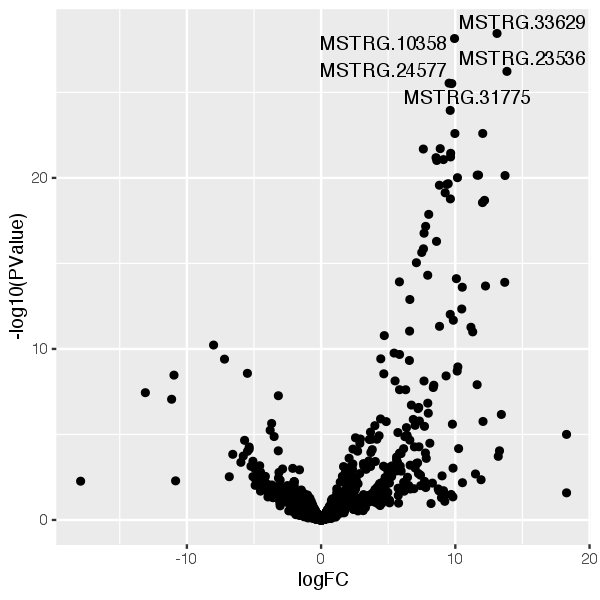

In [50]:
ggplot(lrt.trans.tTags.table, aes(logFC, -log10(PValue))) + geom_point() + geom_text_repel(data= filter(lrt.trans.tTags.table, -log10(PValue) > 25), aes(logFC, -log10(PValue), label = GeneID))

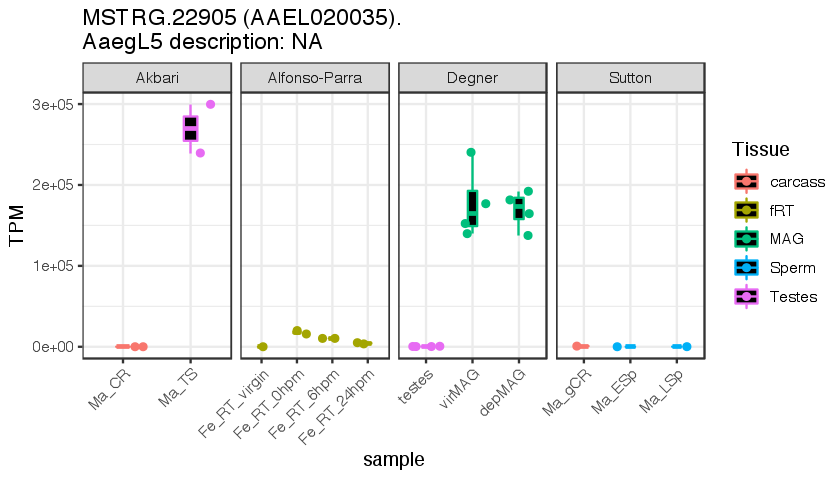

In [51]:
options(repr.plot.width = 7, repr.plot.height = 4)
# pdf("Figures/transferred.mRNA.genePlots.pdf", width = 7, height = 3)
# lapply(transferred.gene.list, plotBoxTPM, object = TPM.table)
# dev.off()
plotBoxTPM(object = TPM.table, "MSTRG.22905")

In [52]:
transferred.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% transferred.gene.list)
# tissueBiased.meanTPM = subset(tissueBiased.meanTPM, select = c("virMAG", "depMAG", "testes", "Ma_gCR", "Fe_RT_virgin"))

In [53]:
transferred.vetted.gene.list.meanTPM = subset(transferred.meanTPM, Fe_RT_6hpm < Fe_RT_0hpm & Fe_RT_24hpm < Fe_RT_6hpm)
transferred.vetted.gene.list.meanTPM = subset(transferred.vetted.gene.list.meanTPM, select = c("virMAG", "testes", "Ma_gCR", "Fe_RT_virgin", "Fe_RT_0hpm", "Fe_RT_6hpm", "Fe_RT_24hpm"))
colnames(transferred.vetted.gene.list.meanTPM) = gsub("Fe_RT_", "", colnames(transferred.vetted.gene.list.meanTPM))
colnames(transferred.vetted.gene.list.meanTPM) = gsub("virMAG", "MAG (umated)", colnames(transferred.vetted.gene.list.meanTPM))
colnames(transferred.vetted.gene.list.meanTPM) = gsub("Ma_gCR", "male carcass", colnames(transferred.vetted.gene.list.meanTPM))
transferred.vetted.gene.list = rownames(transferred.vetted.gene.list.meanTPM)

In [54]:
sampleCodingInfo = subset(coding_info, select = c("new_stable_id", "new_biotype"))
# transferred.coding.info = filter(sampleCodingInfo, new_stable_id %in% )

In [55]:
transferred.gene.info = filter(transferred.gene.info, GeneID %in% transferred.vetted.gene.list)
this_file = merge(transferred.gene.info, sampleCodingInfo, by.x = "VB_ID", by.y = "new_stable_id", all.x = T)
this_file$new_biotype = as.character(this_file$new_biotype)
this_file$new_biotype <- ifelse(is.na(this_file$new_biotype),  'unannotated', this_file$new_biotype)
# this_file$transcript_type = ifelse(this_file$new_biotype == "protein_coding", "protein coding", ifelse(this_file$new_biotype == "lncRNA", "lncRNA", "unannotated"))

In [56]:
annotationType = unique(subset(this_file, select = c("GeneID", "new_biotype")))
rownames(annotationType) = annotationType$GeneID
annotationType = subset(annotationType, select = "new_biotype")
colnames(annotationType) = "annotation"

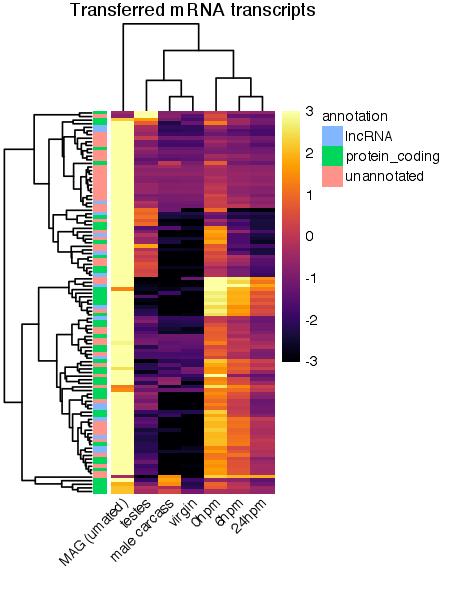

In [57]:
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)


options(repr.plot.width = 3.8, repr.plot.height = 5)
data = log2(transferred.vetted.gene.list.meanTPM+1)
data = t(scale(t(data), scale=F))
data[data < -3] = -3
data[data > 3] = 3

pheatmap(
  mat               = data,
  color             = inferno(100),
#   breaks            = mat_breaks,
  border_color      = NA,
#   labels_col        = c("carcass", "head", "ovaries", "rep. tract"),
  show_colnames     = TRUE,
  show_rownames     = FALSE,
  annotation_row    = annotationType,
#   annotation_colors = mat_colors,
  drop_levels       = TRUE,
#   cluster_col    = FALSE,
  annotation_names_row = F,
  main              = "Transferred mRNA transcripts",
#   filename          = "Figures/transferred_mRNAs_heatmap.pdf",
#   width             = 3.8, 
#   height            = 5,
  fontsize          = 8    
)

These lists will be used in different contexts later on in the analysis. We'll use the list with those genes showing more extreme bias to plot a few heatmaps and perform GO analyses.

First, we'll create a factor labeling table for tissue-biasd genes (to use a different class of biased genes, substitute the list object in the factor assignment and the rownames extraction):

In [58]:
MAG_factors = as.data.frame(MAG.up.list.CDS)
MAG_factors$V1 = "MAG-biased"
rownames(MAG_factors) = MAG.up.list.CDS
MAG_factors = subset(MAG_factors, select = "V1")

testes_factors = as.data.frame(testes.up.list.CDS)
testes_factors$V1 = "testes-biased"
rownames(testes_factors) = testes.up.list.CDS
testes_factors = subset(testes_factors, select = "V1")

fRT_factors = as.data.frame(fRT.up.list.CDS)
fRT_factors$V1 = "fRT-biased"
rownames(fRT_factors) = fRT.up.list.CDS
fRT_factors = subset(fRT_factors, select = "V1")

factor.labeling = rbind(MAG_factors, testes_factors, fRT_factors)
colnames(factor.labeling) = c('tissue_bias')
factor_list = unique(factor.labeling[,1])

factor.labeling$tissue_bias = factor(factor.labeling$tissue_bias, levels = c("fRT-biased", "MAG-biased", "testes-biased"))

Subset the TPM matrix for tissue-biased genes only:

In [59]:
tissueBiased.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% rownames(factor.labeling))
tissueBiased.meanTPM = subset(tissueBiased.meanTPM, select = c("virMAG", "depMAG", "testes", "Ma_gCR", "Fe_RT_virgin"))

Create the heatmap object for plotting (this is long and tedious, but should be treated as a code chunk):

In [60]:
data = tissueBiased.meanTPM
gene_factors = unique(factor.labeling[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(factor.labeling[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#9e6ebd",
"#7aa457",
"#cb6751")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

Now we can use the heatmap.3 function to generate the plot:

for plotting:: min.raw: -1 max.raw: 1


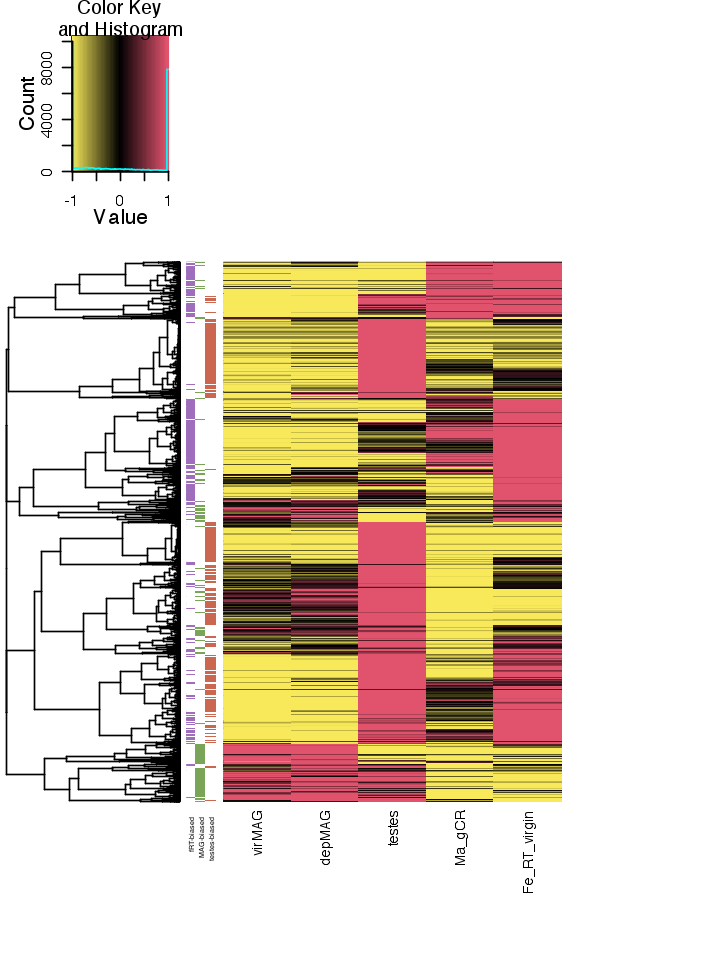

In [61]:
options(repr.plot.width = 6, repr.plot.height = 8)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), col=myheatcol, RowSideColors=geneFactorAnnotations, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.9, labRow = F)

Let's take a look at the transferred mRNAs from Catalina's paper:

In [62]:
tmRNA.mstrg_IDs = unique(subset(geneFeatures, gene_ID %in% tmRNA$V1)$mstrg_ID)
tmRNA.TPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% tmRNA.mstrg_IDs)

In [63]:
data = tmRNA.TPM
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#79cf3a','black','#fb266a')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

for plotting:: min.raw: -1 max.raw: 1


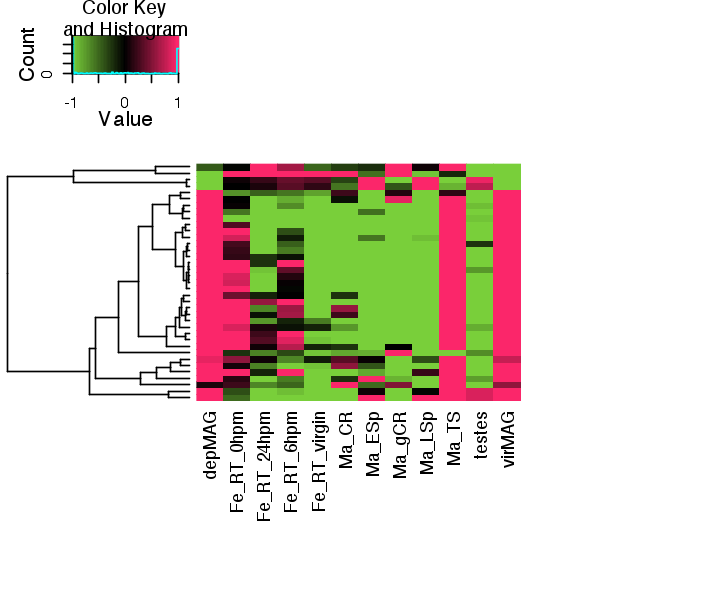

In [64]:
options(repr.plot.width = 6, repr.plot.height = 5)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv=c("Fe_RT_virgin", "Fe_RT_0hpm", "Fe_RT_6hpm", "Fe_RT_24hpm", "virMAG", "depMAG"), col=myheatcol, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

Here we'll perform a GO enrichment analysis of the genes with ≥4-fold tissue-bias. First we need to set the gene names to VectorBase IDs (note we are already using genes that are VectorBase annotated, we're just changing the IDs to those that correspond to the GOinfo table) *** Using the MAG.up.list instead of the ≥4-fold list, which results in only 2 enriched categories ***:

In [65]:
MAG.VB_IDs.list = unique(subset(gene.features, gene_id %in% MAG.DEup.list.CDS & ref_gene_id != "NA")$ref_gene_id)
testes.VB_IDs.list = unique(subset(gene.features, gene_id %in% testes.DEup.list.CDS & ref_gene_id != "NA")$ref_gene_id)
fRT.VB_IDs.list = unique(subset(gene.features, gene_id %in% fRT.extreme.list.CDS & ref_gene_id != "NA")$ref_gene_id)

Now we can create a factor labeling table for this set of gene IDs, as we did for the heatmap:

In [66]:
MAG_vb_factors = as.data.frame(MAG.VB_IDs.list)
MAG_vb_factors$V1 = "MAG-biased"
rownames(MAG_vb_factors) = MAG.VB_IDs.list
MAG_vb_factors = subset(MAG_vb_factors, select = "V1")

testes_vb_factors = as.data.frame(testes.VB_IDs.list)
testes_vb_factors$V1 = "testes-biased"
rownames(testes_vb_factors) = testes.VB_IDs.list
testes_vb_factors = subset(testes_vb_factors, select = "V1")

fRT_vb_factors = as.data.frame(fRT.VB_IDs.list)
fRT_vb_factors$V1 = "fRT-biased"
rownames(fRT_vb_factors) = fRT.VB_IDs.list
fRT_vb_factors = subset(fRT_vb_factors, select = "V1")

vb.factor.labeling = rbind(MAG_vb_factors, testes_vb_factors, fRT_vb_factors)
colnames(vb.factor.labeling) = c('tissue_bias')
vb_factor_list = unique(vb.factor.labeling[,1])

Now we need to extract the gene lengths and merge them with the new ID format:

In [67]:
tmpData = unique(subset(gene.features, select = c("gene_id", "ref_gene_id")))
tmpData = unique(merge(tmpData, gene_lengths, by.x = "gene_id", by.y = "gene_id"))
vb_gene_lengths = subset(tmpData, ref_gene_id != "NA")
vb_gene_lengths = subset(vb_gene_lengths, select = c("ref_gene_id", "length"))
colnames(vb_gene_lengths) = c("vb_ID", "length")
vb_gene_lengths <- vb_gene_lengths[order(vb_gene_lengths$vb_ID),]
# vb_gene_lengths = as.matrix(vb_gene_lengths)
rownames(vb_gene_lengths) <- vb_gene_lengths$vb_ID
vb_gene_lengths[,1] <- NULL

Load the GO info here:

In [68]:
GO_info_listed = apply(GO_info, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GO_info)
features_with_GO = rownames(GO_info)
lengths_features_with_GO = vb_gene_lengths[features_with_GO,]
get_GO_term_descr =  function(x) {
    d = 'none';
    go_info = GOTERM[[x]];
    if (length(go_info) >0) { d = paste(Ontology(go_info), Term(go_info), sep=' ');}
    return(d);
}

And set the null expectation based on the entire dataset:

Warning message in pcls(G):
“initial point very close to some inequality constraints”

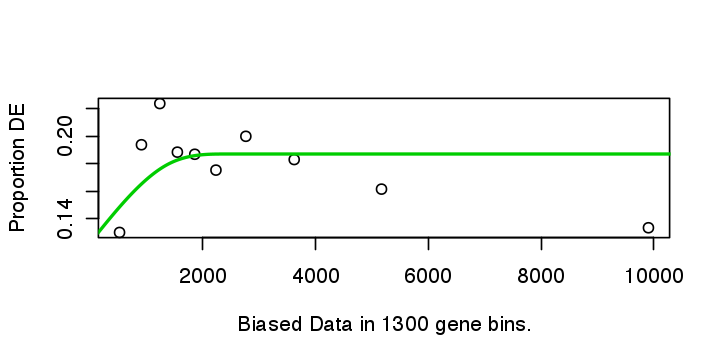

In [69]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% rownames(vb.factor.labeling))
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

Finally, we can loop over the tissue-biased gene categories and perform the GO analysis on each gene set:

In [70]:
GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in vb_factor_list) {
#     message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(vb.factor.labeling)[vb.factor.labeling$tissue_bias == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))

GO_enrichment_data = rbindlist(GO_enriched_list)

We can make some bubble plots to quickly look at over-represented terms:

Warning message:
“Removed 13 rows containing missing values (geom_point).”Warning message:
“Removed 13 rows containing missing values (geom_text_repel).”

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.
Warning message:
“Removed 85 rows containing missing values (geom_point).”Warning message:
“Removed 45 rows containing missing values (geom_text_repel).”

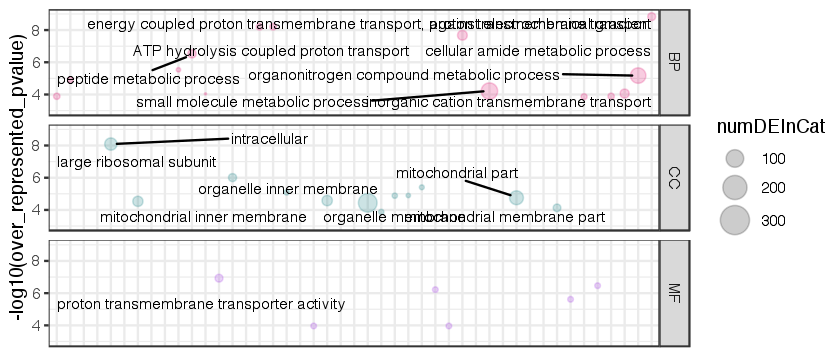

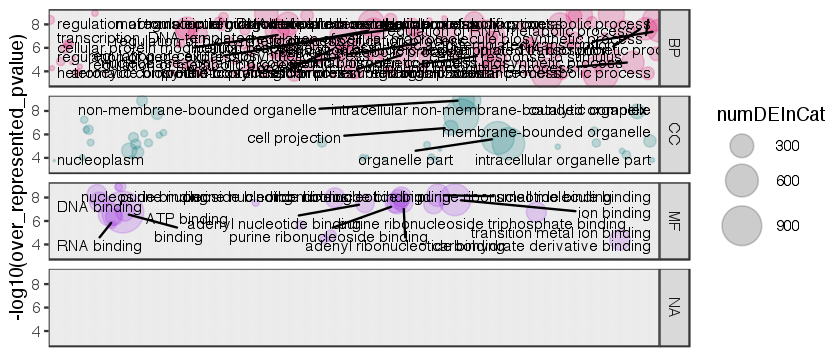

In [71]:
### MAG plot
options(repr.plot.width = 7, repr.plot.height = 3)

ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "MAG-biased" & term != "cellular_component"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~.) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "MAG-biased" & numDEInCat > 10 & term != "cellular_component"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +  
    scale_size(range=c(0,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
#     scale_size(range = c(0,5)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

### testes plot
options(repr.plot.width = 7, repr.plot.height = 3)
#pdf("RT-biased.GO.pdf", width = 8.10, height = 3)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.01 & factor == "testes-biased"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~.) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.01 & factor == "testes-biased" & numDEInCat > 100), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +  
    scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.
Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”

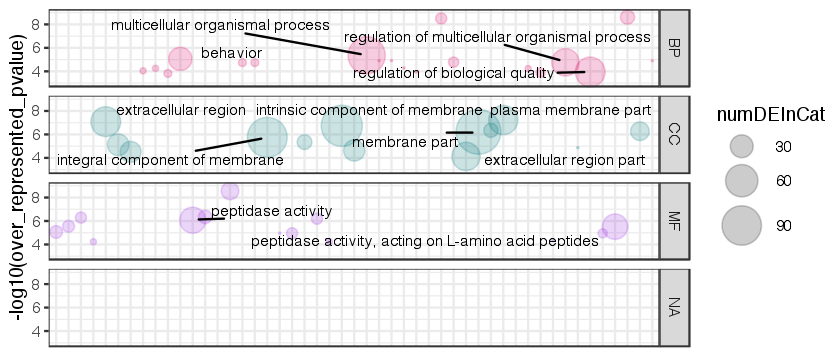

In [72]:
### fRT plot
options(repr.plot.width = 7, repr.plot.height = 3)
#pdf("RT-biased.GO.pdf", width = 8.10, height = 3)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "fRT-biased"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~.) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "fRT-biased" & numDEInCat > 30), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 12, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +  
    scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

## DE analysis with Ethan's data:

We can now explore differential expression between the virgin and mated MAG samples. First we'll subset the 3\`RNAseq samples from the `sampleData` object, then define the groups and design matrix:

In [73]:
e.groups = factor(subset(sampleData, Source == "Degner")$Sample)
e.design = model.matrix( ~ 0 + e.groups)
colnames(e.design) <- levels(e.groups)
rownames(e.design) <- subset(sampleData, Source == "Degner")$Replicate

Now we'll filter the count matrix:

In [74]:
# Now filter this subsetted count matrix:
e.CPM <- cpm(ethan.countsMatrix)
e.thresh <- e.CPM > 5
e.keep <- rowSums(e.thresh) >= 4
e.counts.keep <- ethan.countsMatrix[e.keep,]
nrow(e.counts.keep)

[1] 9417

Now create the DGE object and run the glm fit:

In [75]:
e.dgeList <- DGEList(counts = e.counts.keep, group = e.groups)
e.dgeList <- calcNormFactors(e.dgeList)
e.dgeList <- estimateCommonDisp(e.dgeList)
e.dgeList <- estimateTagwiseDisp(e.dgeList)
e.dgeList_fit <- glmFit(e.dgeList, e.design)

...add annotation information:

In [76]:
# Extract annotation for genes in the fit object
ann.e = subset(annots, mstrg_ID %in% rownames(e.dgeList_fit))
# convert factors to characters
ann.e = data.frame(lapply(ann.e, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.e = ann.e[match(rownames(e.dgeList_fit), ann.e$mstrg_ID),]
# convert factors to characters, again
ann.e <- data.frame(lapply(ann.e, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.e) = c ("GeneID", "VB_ID", "gene_name","Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.e$GeneID==rownames(e.dgeList_fit))
# Add the annotations to the fit object in the "genes" slot
e.dgeList_fit$genes = ann.e


TRUE 
9417 

We can look at the variability by examining the tagwise dispersion:

In [77]:
summary(e.dgeList$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.04986 0.09280 0.11556 0.19416 0.17884 3.63975 

We can take a closer look at the DE materics and whether overall variability in the counts is suitable by plotting the BCV, looking at the mean-variance trend and QQplot:

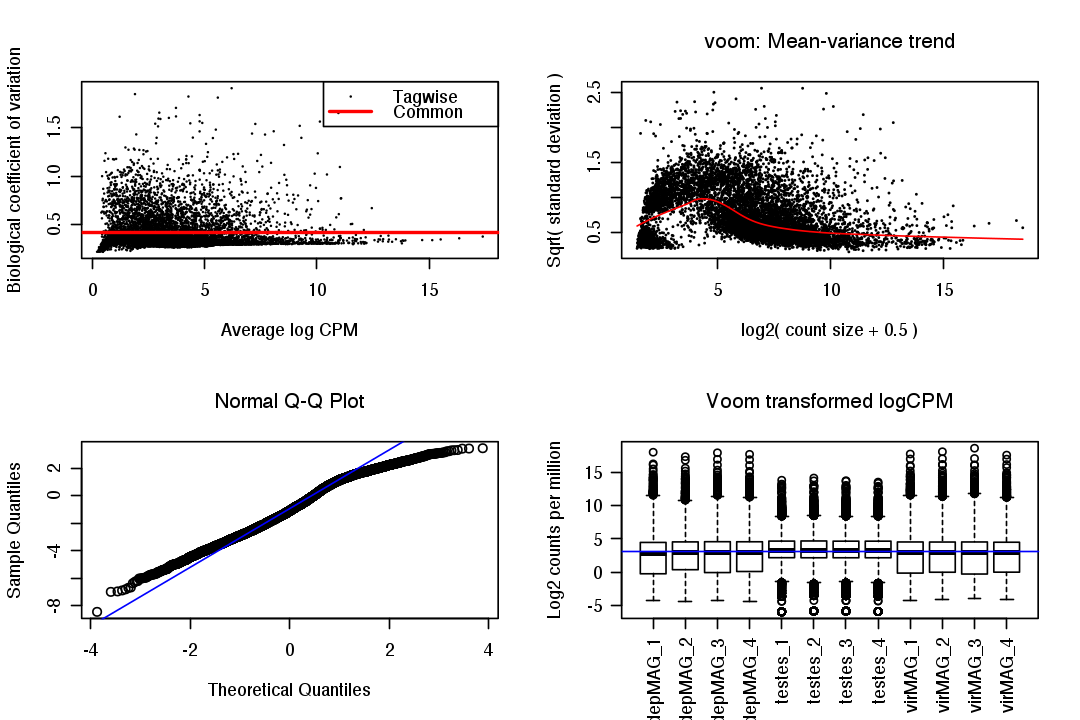

In [78]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(e.dgeList)
# mean-variance trend
voomC = voom(e.dgeList, e.design, plot=TRUE)
# QQ-plot
g <- gof(e.dgeList_fit)
z <- zscoreGamma(g$gof.statistics,shape=g$df/2,scale=2)
qqnorm(z); qqline(z, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(voomC$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voomC$E),col="blue")

We'll set up the contrast between the virgin and depleted MAG samples, and between the virgin MAG and testes:

In [79]:
dMAG.v.vMAG <- makeContrasts(dMAG.vs.vMAG=depMAG-virMAG,
                             levels=e.design)

vMAG.v.testes <- makeContrasts(vMAG.vs.testes=virMAG-testes,
                               levels=e.design)

Now run the LRT on the fit object to identify differentially expressed genes:

In [80]:
lrt.vdMAG <- glmLRT(e.dgeList_fit, contrast = dMAG.v.vMAG)
lrt.testes_vMAG <- glmLRT(e.dgeList_fit, contrast = vMAG.v.testes)

We'll extract the genes that are >2-fold up- or down-regulated at an FDR cutoff of 0.01:

In [81]:
lrt.vdMAG.tTags <- topTags(lrt.vdMAG, n = NULL)
lrt.vdMAG.tTags.table <- lrt.vdMAG.tTags$table

# create a list of all DE genes:
vdMAG.DE.list<-subset(lrt.vdMAG.tTags.table, logFC < -1 & FDR<0.01 | logFC > 1 & FDR<0.01)$GeneID
vdMAG.DE.list.CDS  = unique(subset(gene.features, gene_id %in% vdMAG.DE.list & ref_gene_id != "NA")$gene_id)

# and a list of up-regulated and down-regulated genes:
virUP.list<-subset(lrt.vdMAG.tTags.table, logFC < -1 & FDR<0.01)$GeneID
depUP.list<-subset(lrt.vdMAG.tTags.table, logFC > 1 & FDR<0.01)$GeneID

virUP.list.CDS = unique(subset(gene.features, gene_id %in% virUP.list & ref_gene_id != "NA")$gene_id)
virDOWN.list.CDS = unique(subset(gene.features, gene_id %in% depUP.list & ref_gene_id != "NA")$gene_id)

paste("The number of gene transcripts the are differentially expressed between virgin and depleted MAGs is ", length(vdMAG.DE.list), ", of which ", length(vdMAG.DE.list.CDS), " are annotated protein coding genes. Of these, ", length(virUP.list.CDS), " go down in expression after mating, and ", length(virDOWN.list.CDS), " go up in expression after mating", sep="")

[1] "The number of gene transcripts the are differentially expressed between virgin and depleted MAGs is 522, of which 446 are annotated protein coding genes. Of these, 126 go down in expression after mating, and 320 go up in expression after mating"

We'll extract the tTags table for the vMAG/testes comparison:

In [82]:
lrt.testes_vMAG.tTags <- topTags(lrt.testes_vMAG, n = NULL)
lrt.testes_vMAG.tTags.table <- lrt.testes_vMAG.tTags$table

For two samples it's often convenient to look at a volcano plot. With edgeR we can produce interactive volcano plots. First we need to run the glmTreat model:

In [83]:
lrt_dMAG.v.vMAG <- glmTreat(e.dgeList_fit, contrast = c(1,0,-1), lfc =1)
lrt_vMAG.v.testes <- glmTreat(e.dgeList_fit, contrast = c(0,-1,1), lfc =1)

Then run the decide test

In [84]:
dt.dvMAG = decideTestsDGE(lrt_dMAG.v.vMAG)
dt.TvMAG = decideTestsDGE(lrt_vMAG.v.testes)

Also subset the data info:

In [85]:
sampleData.e = subset(sampleData, Source == "Degner")

Now make the plot:

In [86]:
glXYPlot(x=lrt_dMAG.v.vMAG$table$logFC, y=-log10(lrt_dMAG.v.vMAG$table$PValue), xlab="logFC", ylab="logodds", status=dt.dvMAG, groups=sampleData.e$Sample, side.main="gene_name", anno = ann.e, counts = e.dgeList)

In [87]:
glXYPlot(x=lrt_vMAG.v.testes$table$logFC, y=-log10(lrt_vMAG.v.testes$table$PValue), xlab="logFC", ylab="logodds", status=dt.TvMAG, groups=sampleData.e$Sample, side.main="gene_name", anno = ann.e, counts = e.dgeList)

We can clearly see there are more genes that go up in expression after mating. We'll also generate a static volcano plot for later (will highlight highly significant genes):

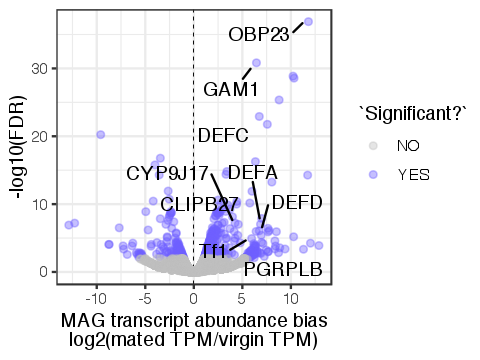

In [88]:
tmpVolcano = lrt.vdMAG.tTags.table
tmpVolcano$`Significant?` = ifelse(tmpVolcano$FDR < 0.01 & tmpVolcano$logFC > 1 | tmpVolcano$FDR < 0.01 & tmpVolcano$logFC < -1, "YES", "NO")

options(repr.plot.width = 4, repr.plot.height = 3)
# pdf("Results/deMAG_volcano_plot.pdf", width = 4, height = 3.2)
ggplot(tmpVolcano, aes(logFC, -log10(FDR), colour = `Significant?`)) + 
    geom_vline(xintercept = 0, linetype = "dashed", size = 0.2) +
    geom_point(alpha=0.4) + 
    geom_text_repel(data = subset(tmpVolcano, logFC > 4 & -log10(FDR) > 3 & !is.na(gene_name)), 
                    aes(logFC, -log10(FDR),label=gene_name), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 4,
                    colour = "black") +
#     geom_text_repel(data = subset(tmpVolcano, transferred_mRNA == "YES" & Significant == "YES"), 
#                     aes(logFC, -log10(FDR),label=VB_ID), 
#                     force = 30, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
#                     fontface = "bold", 
#                     size = 5,
#                     colour = "#96a900") +
    scale_colour_manual(values = c("gray", "#6e61ff")) +
    labs(x = "MAG transcript abundance bias\nlog2(mated TPM/virgin TPM)") + 
    theme(axis.text.x = element_text(size = 14)) + 
    theme_bw()
# dev.off()

We can also try a heatmap:

In [89]:
subset(tmpVolcano, gene_name == "CLIPB27")

GeneID     VB_ID      gene_name Description            logFC   
MSTRG.7909 MSTRG.7909 AAEL007993 CLIPB27   serine protease easter 4.241988
           logCPM   LR       PValue      FDR          Significant?
MSTRG.7909 1.439539 39.32281 3.59221e-10 6.150517e-08 YES

In [90]:
options(repr.plot.width = 12, repr.plot.height = 13)
# suppressWarnings(compGeneBarplot("AAEL014053"))

In [91]:
vdMAG.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% vdMAG.DE.list.CDS)
vdMAG.meanTPM = subset(vdMAG.meanTPM, select = c("virMAG", "depMAG", "testes", "Fe_RT_virgin", "Fe_RT_0hpm", "Fe_RT_6hpm", "Fe_RT_24hpm"))

Create the heatmap object for plotting (this is long and tedious, but should be treated as a code chunk):

In [92]:
data = vdMAG.meanTPM
# gene_factors = unique(factor.labeling[,1])
# gene_factor_colors = rainbow(length(gene_factors))
# names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
# gene_factor_row_vals = as.factor(factor.labeling[rownames(heatmap_data),])
# names(gene_factor_row_vals) = rownames(heatmap_data)
# gene_factors_here = unique(gene_factor_row_vals)
# names(gene_factors_here) = gene_factors_here
# num_gene_factors_here = length(gene_factors_here)
# geneFactorColors = c("#9e6ebd", "#7aa457", "#cb6751")
# geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
# for (i in 1:num_gene_factors_here) {
#     geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
# }
# geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
# geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
# rownames(geneFactorAnnotations) = rownames(heatmap_data)
# colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2

for plotting:: min.raw: -2 max.raw: 2


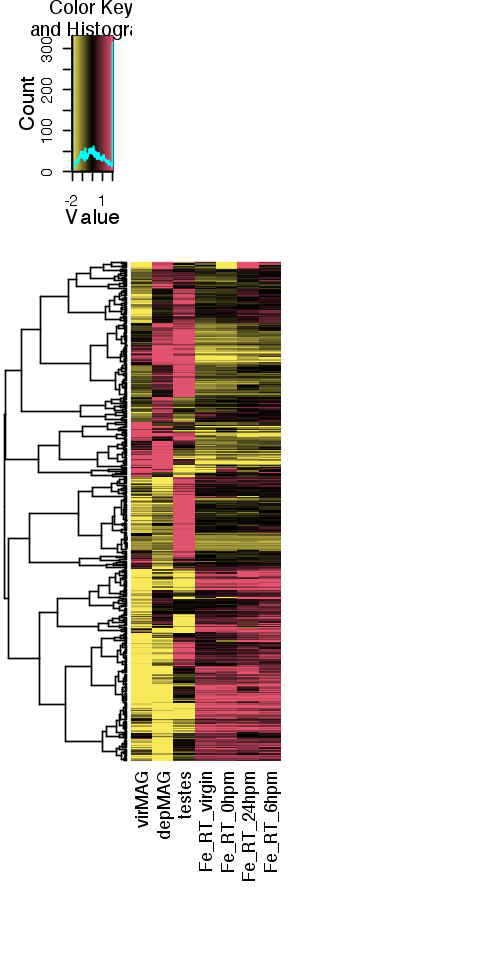

In [93]:
options(repr.plot.width = 4, repr.plot.height = 8)
# pdf("Results/deMAG_heatmap.pdf", width = 4, height = 8)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), col=myheatcol, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)
# dev.off()

We can also look at the genes that show mRNA transfer in the female from Catalina's study:

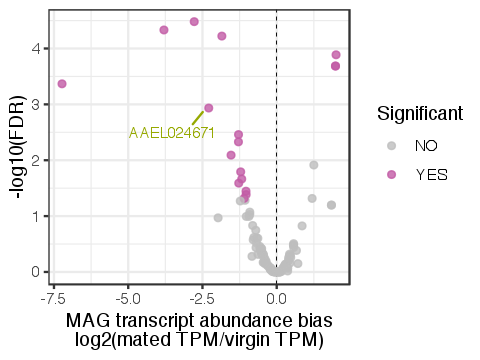

In [94]:
tmpVolcano = lrt.vdMAG.tTags.table
tmpVolcano$Significant = ifelse(tmpVolcano$FDR < 0.01 & tmpVolcano$logFC > 1 | tmpVolcano$FDR < 0.05 & tmpVolcano$logFC < -1, "YES", "NO")
tmpVolcano$transferred_mRNA = ifelse(tmpVolcano$GeneID %in% transferred.vetted.gene.list, "YES", "NO")
tmpVolcano = merge(tmpVolcano, coding_info, by.x = "VB_ID", by.y = "new_stable_id", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3)
# pdf("Results/transferred_mRNA_volcano_plot.pdf", width = 4, height = 3)
ggplot(subset(tmpVolcano, transferred_mRNA == "YES"), aes(logFC, -log10(FDR), colour = Significant)) + 
    geom_vline(xintercept = 0, linetype = "dashed", size = 0.2) +
    geom_point(alpha=0.8) + 
    geom_text_repel(data = subset(tmpVolcano, transferred_mRNA == "YES" & Significant == "YES" & new_biotype == "lncRNA"), 
                    aes(logFC, -log10(FDR),label=VB_ID), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3,
                    colour = "#96a900") +
    scale_colour_manual(values = c("gray", "#c15ca5")) +
    labs(x = "MAG transcript abundance bias\nlog2(mated TPM/virgin TPM)") + 
    theme(axis.text.x = element_text(size = 14)) + 
    theme_bw()
# dev.off()

We can look at whether any GO terms are enriched among the up- or down-regulated genes. First generate the factor labeling table with the two gene classes:

In [95]:
deMAG.up.VB_IDs.list = unique(subset(gene.features, gene_id %in% virUP.list.CDS & ref_gene_id != "NA")$ref_gene_id)
deMAG.down.VB_IDs.list = unique(subset(gene.features, gene_id %in% virDOWN.list.CDS & ref_gene_id != "NA")$ref_gene_id)

deMAG.down_vb_factors = as.data.frame(deMAG.down.VB_IDs.list)
deMAG.down_vb_factors$V1 = "Upregulated"
rownames(deMAG.down_vb_factors) = deMAG.down.VB_IDs.list
deMAG.down_vb_factors = subset(deMAG.down_vb_factors, select = "V1")

deMAG.up_vb_factors = as.data.frame(deMAG.up.VB_IDs.list)
deMAG.up_vb_factors$V1 = "Downregulated"
rownames(deMAG.up_vb_factors) = deMAG.up.VB_IDs.list
deMAG.up_vb_factors = subset(deMAG.up_vb_factors, select = "V1")

deMAG.factor.labeling = rbind(deMAG.up_vb_factors, deMAG.down_vb_factors)
colnames(deMAG.factor.labeling) = c('DE_status')
deMAG_factor_list = unique(deMAG.factor.labeling[,1])

Set up the null as before:

Warning message in pcls(G):
“initial point very close to some inequality constraints”

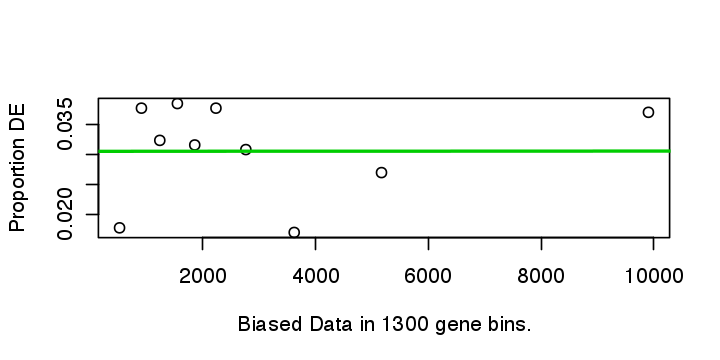

In [96]:
options(repr.plot.width = 6, repr.plot.height = 3)

cat_genes_vec = as.integer(features_with_GO %in% rownames(deMAG.factor.labeling))
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

output the enrichment result:

In [97]:
GO_enriched_list = list()

for (feature_cat in deMAG_factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(deMAG.factor.labeling)[deMAG.factor.labeling$DE_status == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}

GO_enrichment_data = rbindlist(GO_enriched_list)

Processing category: Downregulated
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: Upregulated
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


We can write out the significant GO terms to a table:

In [98]:
write.table(subset(GO_enrichment_data, over_represented_FDR < 0.05), file = "Results/significant_virgin_vs_mated_GO_terms.txt", quote = F, sep = "\t", row.names = F)

After manually examining those, we trimmed out redundant terms, and can load the result here:

In [99]:
deMAG.GO = read.csv("Results/significant_virgin_vs_mated_GO_terms_nonredundant.csv", header = T, sep = ",")

Extract significant GO terms for each ontology class:

In [100]:
MF.terms <- subset(GO_enrichment_data, over_represented_FDR < 0.05 & ontology == "MF")$category
BP.terms <- subset(GO_enrichment_data, over_represented_FDR < 0.05 & ontology == "BP")$category
CC.terms <- subset(GO_enrichment_data, over_represented_FDR < 0.05 & ontology == "CC")$category

We can output the DE genes associated with each GO term like so (change the GO term list for each ontology class):

In [101]:
# pdf("Results/Plots/Expression_BarPlots_of_virgin_vs_mated_MAG_DE_genes_with_significant_GO/BP.term_GO_plots_with_testes.pdf", width = 8, height = 4)
# lapply(BP.terms, function(term) {
#     MyGeneSet = extract_GO_genes(term, deMAG.down.VB_IDs.list)
#     MyGeneSet_TPMse = subset(TPMse, gene_id %in% unique(subset(gene.features, ref_gene_id %in% MyGeneSet)$gene_id))
#     MyGeneSet_TPMse = merge(MyGeneSet_TPMse, geneFeatures, by.x = "gene_id", by.y = "mstrg_ID")
#     MyGeneSet_TPMse$gene_ID_ordered <- with(MyGeneSet_TPMse, reorder(gene_ID, TPM, function(x) -length(x)))

# #     options(repr.plot.width = 12, repr.plot.height = 4)
#     ggplot(subset(MyGeneSet_TPMse, Source == "Degner" & !is.na(gene_ID)), aes(gene_ID, TPM, fill = sample)) + 
#         geom_bar(stat = "identity", position = "dodge") + 
#         geom_errorbar(aes(ymin = TPM - se, ymax = TPM + se), width = 0.2, position = position_dodge(0.9))+
#         theme_minimal() +
#         labs(title = get_GO_term_descr(x = term)) +
#         theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
#         scale_fill_manual(values = c("#a76bb2","#639e6c","#b3883e"))
#         }
# )
# dev.off()

We'll also output comprehensive expression and annotation data for all DE genes between

In [102]:
# downGenes = as.character(unique(subset(gene.features, gene_id %in% virUP.list.CDS & !is.na(ref_gene_id))$ref_gene_id))
# upGenes = as.character(unique(subset(gene.features, gene_id %in% virDOWN.list.CDS & !is.na(ref_gene_id))$ref_gene_id))

# # First downregulated genes
# pdf("Results/Plots/Comprehensive_expression_data_of_virgin_vs_mated_MAG_DE_genes/downregulated_genes.pdf", height = 13, width = 12)
# suppressWarnings(lapply(downGenes, compGeneBarplot))
# dev.off()

# and upregulated genes
# pdf("Results/Plots/Comprehensive_expression_data_of_virgin_vs_mated_MAG_DE_genes/upregulated_genes.pdf", height = 13, width = 12)
# suppressWarnings(lapply(upGenes, compGeneBarplot))
# dev.off()

Now we'll look at a summary of significant GO terms using bubble plots:

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.
Warning message:
“Removed 5 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_text_repel).”

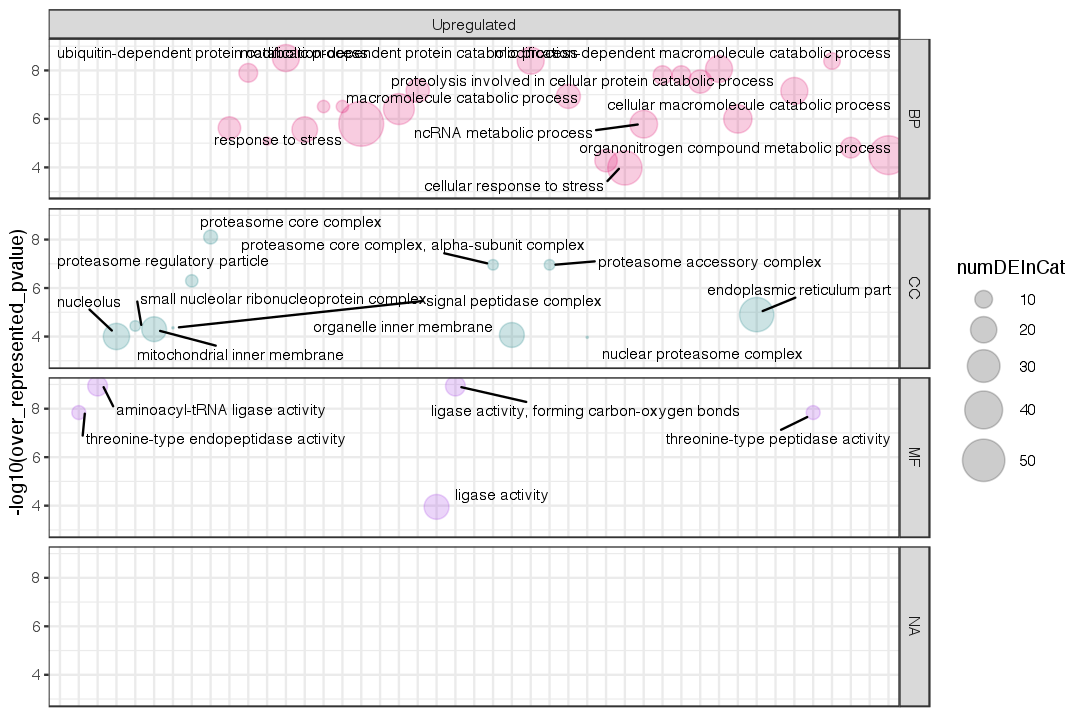

In [103]:
options(repr.plot.width = 9, repr.plot.height = 6)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point(alpha = 0.2)  + 
    facet_grid(ontology~factor) +
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & numDEInCat > 20 & ontology == "BP"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 10, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & ontology == "CC"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    geom_text_repel(data = subset(GO_enrichment_data, over_represented_FDR < 0.05 & ontology == "MF"), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 30, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    scale_size(range=c(-3,8)) +
    theme_bw() +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) +
    guides(colour = FALSE) +
    scale_y_continuous(limits=c(3, 9))

There appears to be no enrichment among genes that go down in expression after mating, but several enriched terms among genes that are upregulated in the depleted MAG sample.

# Proteome data

Load the final proteomics data file:

In [104]:
proteome_data = read.csv("proteomics/complete_result.txt", header = T, sep = "\t")

And the raw peptide and spectral data:

In [105]:
peptide_data = read.csv("proteomics/raw_comet_tandem_combined.txt", header = T, sep = "\t")

spectral_data = read.csv("proteomics/spectra_comet_tandem_combined.txt", header = T, sep = "\t")

All the proteomics analysis was performed on the NCBI IDs, and does not contain the new VectorBase IDs. We'll combine the IDs from the new annotation with the NCBI annotation and MSTRG IDs here:

In [106]:
# first subset the geneFeatures object to include data present in the proteome_data object:
tmpFile = unique(subset(geneFeatures, loc_ID %in% proteome_data$gene))
# Select only the relevant columns from the above file:
proteome_IDs = unique(subset(tmpFile, select = c("mstrg_ID", "gene_ID", "loc_ID", "gene_name")))
# Now create a new object with the proteome data with the full ID set:
ejaculotome1 = merge(proteome_IDs, proteome_data, by.x = "loc_ID", by.y = "gene", all = TRUE)
rm(tmpFile)

We can load the protein abundance data produced by APEX, which also uses the NCBI IDs, and combine it with the rest of the ejaculotome data:

In [107]:
apex = read.csv("proteomics/APEX_semen_v_sperm_longest_full_comb_comet_V2.txt", header = T, sep = "\t")
ejaculotome2 = merge(ejaculotome1, apex, by.x = "loc_ID", by.y = "ACC", all = TRUE)

We'll also load the Sirot 2011 data:

In [108]:
sirot = read.csv("annotation/sirot/Sirot_combined_SFP_and_sperm.txt", header = T, sep = "\t")
sirot_SFPs = subset(sirot, Sirot_classification == "SFP" & L5_geneID != "NA")$L5_geneID
sirot_SFPs_mstrg = 
sirot_Sps = subset(sirot, Sirot_classification == "Sperm" & L5_geneID != "NA")$L5_geneID

paste("There are ", length(sirot_SFPs), " genes from the Sirot study that are classified as SFPs, and ", length(sirot_Sps), "genes that are classified as sperm proteins")

[1] "There are  82  genes from the Sirot study that are classified as SFPs, and  93 genes that are classified as sperm proteins"

We can merge the sirot data with the ejaculotome data, but note that Sirot loc_IDs with NA's will be added, but have no merge reference in the ejaculotome object:

In [109]:
ejaculotome3 = merge(ejaculotome2, sirot, by.x = "loc_ID", by.y = "L5_geneID", all = T)

Now we can combine the gene expression abundance data with the proteome data:

In [110]:
proteome_TPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% ejaculotome3$mstrg_ID)
proteome_TPM$gene_id = rownames(proteome_TPM)
ejaculotome4 = merge(ejaculotome3, proteome_TPM, by.x = "mstrg_ID", by.y = "gene_id", all = T)

Add differential expression data from virgin and mated MAG comparison:

In [111]:
MAG.DE_in_proteome = subset(lrt.vdMAG.tTags.table, GeneID %in% ejaculotome4$mstrg_ID)
MAG.DE_in_proteome = subset(MAG.DE_in_proteome, select = c("GeneID", "logFC", "LR", "PValue", "FDR"))
colnames(MAG.DE_in_proteome) = c("GeneID", "edgeR_logFC_MAGs", "edgeR_LR_MAGs", "edgeR_PValue_MAGs", "edgeR_FDR_MAGs")
ejaculotome5 = merge(ejaculotome4, MAG.DE_in_proteome, by.x = "mstrg_ID", by.y = "GeneID", all = T)

And differential expression data between virgin MAG and testes:

In [112]:
TS_v_MAG.DE_in_proteome = subset(lrt.testes_vMAG.tTags.table, GeneID %in% ejaculotome5$mstrg_ID)
TS_v_MAG.DE_in_proteome = subset(TS_v_MAG.DE_in_proteome, select = c("GeneID", "logFC", "LR", "PValue", "FDR"))
colnames(TS_v_MAG.DE_in_proteome) = c("GeneID", "edgeR_logFC_MAGvT", "edgeR_LR_MAGvT", "edgeR_PValue_MAGvT", "edgeR_FDR_MAGvT")
ejaculotome6 = merge(ejaculotome5, TS_v_MAG.DE_in_proteome, by.x = "mstrg_ID", by.y = "GeneID", all = T)

Extract signal peptide data, and merge with above:

In [113]:
signalP_proteome_data = unique(subset(trinotate, select = c("gene_id", "SignalP")))
signalP_proteome_data = subset(signalP_proteome_data, gene_id %in% ejaculotome5$gene_ID)
signalP_proteome_data = aggregate(SignalP~gene_id, data = signalP_proteome_data, toString)
ejaculotome7 = merge(ejaculotome6, signalP_proteome_data, by.x = "gene_ID", by.y = "gene_id", all = TRUE)

We'll add the raw peptide and spectral data:

In [114]:
ejaculotome8 = merge(ejaculotome7, peptide_data, by.x = "loc_ID", by.y = "protein_name", all = TRUE)

In [115]:
ejaculotome9 = merge(ejaculotome8, spectral_data, by.x = "loc_ID", by.y = "protein_name", all = TRUE)

Finally we'll combine the expression status data from the RNAseq run:

In [116]:
ejaculotome10 = merge(ejaculotome9, expression.status, by.x = "mstrg_ID", by.y = "mstrg_ID", all.x = T)

This section adds chromosome coordinate information:

In [117]:
coords_proteome = subset(gene.features, gene_id %in% ejaculotome8$mstrg_ID & !is.na(ref_gene_id))
coords_proteome = unique(subset(coords_proteome, select = c("contig", "min", "gene_id")))
ag <- aggregate(min~gene_id, coords_proteome, min)
coords_proteome = merge(ag, coords_proteome)
ejaculotome11 = merge(ejaculotome10, coords_proteome, by.x = "mstrg_ID", by.y = "gene_id")

We'll assign this final table to the stable object:

In [118]:
ejaculotome_all = ejaculotome11

To run various analyses, we'll need to add additional customizations based on the data that's already there:

In [119]:
tmpDF = ejaculotome_all
# get a log2 fold value for APEX differential abundance
tmpDF$logFold = log2(tmpDF$APEX_FOLD)

# multiple the APEX abundance value by a million
tmpDF$APEX_semen_VPM = tmpDF$APEX_semen * 1e6
tmpDF$APEX_sperm_VPM = tmpDF$APEX_sperm * 1e6

# create a column that assigns a -ve value to proteins with higher abundance in semen
tmpDF$Signfold = ifelse(tmpDF$Semen_more_than_Sperm == "TRUE", tmpDF$logFold * -1, tmpDF$logFold)

# add a column for APEX significance when FDR < 0.05 and fold-change is ≥2-fold
tmpDF$sig = ifelse(tmpDF$recalc_FDR < 0.05 & tmpDF$Signfold > 1 | tmpDF$recalc_FDR < 0.05 & tmpDF$Signfold < -1, "YES", "NO")

# add a YES/NO column for proteins present in only sperm or semen
tmpDF$semen_status = ifelse(tmpDF$semen.only == "1", "YES", "NO")
tmpDF$sperm_status = ifelse(tmpDF$sperm.only == "1", "YES", "NO")

# add a YES/NO column for proteins with a signal peptide seqeunce
tmpDF$signalP = ifelse(tmpDF$SignalP != ".", "YES", "NO")

# add a column for maximum number of total and unique peptides observed in either the comet, tandem, or combined iProphet searches for both the sperm and semen samples:
# semen
semen_t_Peptide_counts = subset(tmpDF, select = c("semen_comet.total_peptides", "semen_combined.total_peptides", "semen_tandem.total_peptides"))
semen_t_Peptide_counts[is.na(semen_t_Peptide_counts)] <- 0
semen_MAX.total_peptides <- apply(semen_t_Peptide_counts, 1, max)

semen_u_Peptide_counts = subset(tmpDF, select = c("semen_comet.unique_peptides", "semen_combined.unique_peptides", "semen_tandem.unique_peptides"))
semen_u_Peptide_counts[is.na(semen_u_Peptide_counts)] <- 0
semen_MAX.unique_peptides <- apply(semen_u_Peptide_counts, 1, max)

tmpDF$semen_MAX.total_peptides = semen_MAX.total_peptides
tmpDF$semen_MAX.unique_peptides = semen_MAX.unique_peptides

# sperm
sperm_t_Peptide_counts = subset(tmpDF, select = c("sperm_comet.total_peptides", "sperm_combined.total_peptides", "sperm_tandem.total_peptides"))
sperm_t_Peptide_counts[is.na(sperm_t_Peptide_counts)] <- 0
sperm_MAX.total_peptides <- apply(sperm_t_Peptide_counts, 1, max)

sperm_u_Peptide_counts = subset(tmpDF, select = c("sperm_comet.unique_peptides", "sperm_combined.unique_peptides", "sperm_tandem.unique_peptides"))
sperm_u_Peptide_counts[is.na(sperm_u_Peptide_counts)] <- 0
sperm_MAX.unique_peptides <- apply(sperm_u_Peptide_counts, 1, max)

tmpDF$sperm_MAX.total_peptides = sperm_MAX.total_peptides
tmpDF$sperm_MAX.unique_peptides = sperm_MAX.unique_peptides

## Add a column with the normalization factor for total PSM (1.782214863)
tmpDF$Semen_total_normalized_PSM = tmpDF$semen_combined_spectra*1.782214863

## Add a column of log2(MAG/testis) TPM
tmpDF$log2_MAGbyTestis = log2(tmpDF$virMAG/tmpDF$testes)

## Add a column of log2(semen/sperm) PSM
tmpDF$log2_PSM = log2(tmpDF$Semen_total_normalized_PSM/tmpDF$sperm_combined_spectra)

## Add a column of "A" APEX values for an APEX MA plot
tmpDF$APEX_A = 0.5*log2(tmpDF$APEX_sperm_VPM*tmpDF$APEX_semen_VPM)

Add this to the stable object:

In [120]:
ejaculotome_all = tmpDF

In [121]:
# nrow(subset(groupedIDsirot, Sirot_classification == "SFP"))
# nrow(subset(ejaculotome_all, mstrg_ID %in% subset(groupedIDsirot, Sirot_classification == "SFP")$mstrg_ID))
# ourData_that_is_sirot_SFP = subset(ejaculotome_all, mstrg_ID %in% subset(groupedIDsirot, Sirot_classification == "SFP")$mstrg_ID)
# nrow(ourData_that_is_sirot_SFP)

In [122]:
# first subset the geneFeatures object to include data present in the proteome_data object:
newFile = unique(subset(geneFeatures, loc_ID %in% sirot$L5_geneID & !is.na(loc_ID)))
# Select only the relevant columns from the above file:
sirotNew_IDs = unique(subset(newFile, select = c("mstrg_ID", "gene_ID", "loc_ID", "gene_name")))
# Now create a new object with the proteome data with the full ID set:
groupedIDsirot = merge(sirotNew_IDs, sirot, by.x = "loc_ID", by.y = "L5_geneID")
groupedIDsirot = merge(groupedIDsirot, ejaculotome_all, by.x = "mstrg_ID", by.y = "mstrg_ID")

rm(newFile)
nrow(groupedIDsirot)
write.table(groupedIDsirot, "Sirot_data.txt", quote = F, row.names = F, sep = "\t")

[1] 162

In [123]:
nrow(subset(ejaculotome_all, Sirot_classification == "SFP"))

[1] 69

Using this tmpDF object, many plots and analyses can be produced. One example plot is a volcano plot of the APEX abundnace data:

Warning message:
“Removed 1026 rows containing missing values (geom_point).”

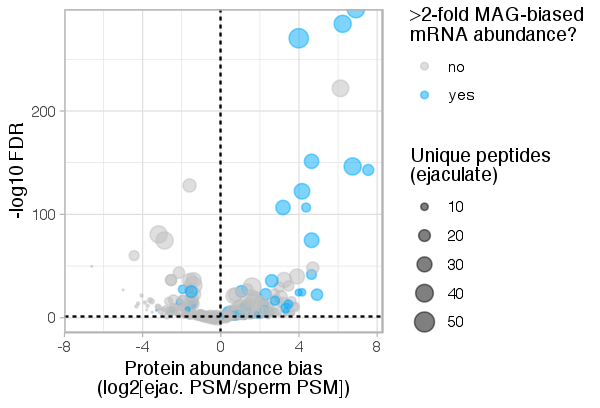

In [124]:
options(repr.plot.width = 5, repr.plot.height = 3.4)
# pdf("Figures/APEX_abundance_semen.pdf", width = 5, height = 3.4)
(apex_volcano_semen = ggplot(subset(tmpDF, !is.na(MAG_oneFold_bias)), aes(log2_PSM, -log10(recalc_FDR), colour = MAG_twoFold_bias, size = semen_combined_unique)) + 
    geom_point(alpha=0.5) + 
    labs(x = "Protein abundance bias\n(log2[ejac. PSM/sperm PSM])", y = "-log10 FDR", color = ">2-fold MAG-biased\nmRNA abundance?", size = "Unique peptides\n(ejaculate)") + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", size = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", size = 0.5) +
    scale_colour_manual(values = c("gray", "#01aafb")) +
    scale_size_continuous(range = c(-1,5)) +
    guides(colour = guide_legend(order = 1),
         size = guide_legend(order = 2)) +
    theme_light())
# dev.off()

Warning message:
“Removed 1026 rows containing missing values (geom_point).”

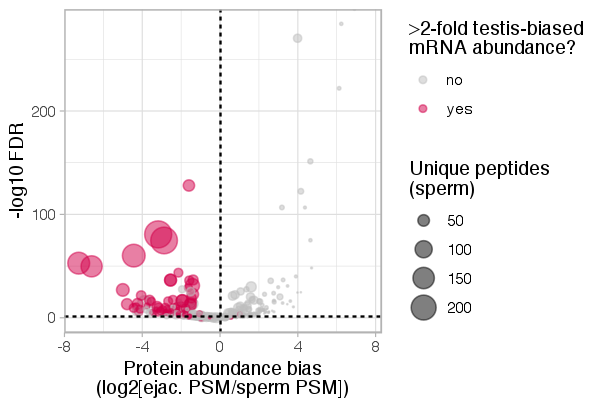

In [125]:
options(repr.plot.width = 5, repr.plot.height = 3.4)
# pdf("Figures/APEX_abundance_sperm.pdf", width = 5, height = 3.4)
(apex_volcano_sperm = ggplot(subset(tmpDF, !is.na(testes_oneFold_bias)), aes(log2_PSM, -log10(recalc_FDR), colour = testes_twoFold_bias, size = sperm_combined_unique)) + 
    geom_point(alpha=0.5) + 
    labs(x = "Protein abundance bias\n(log2[ejac. PSM/sperm PSM])", y = "-log10 FDR", color = ">2-fold testis-biased\nmRNA abundance?", size = "Unique peptides\n(sperm)") + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", size = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", size = 0.5) +
    scale_colour_manual(values = c("gray", "#d1004b")) +
    scale_size_continuous(range = c(-1,7)) +
    guides(colour = guide_legend(order = 1),
         size = guide_legend(order = 2)) +
    theme_light())
# dev.off()

One other example is correplation between APEX abundance values and RNAseq abundance estimates for SFPs:

Warning message:
“Removed 1044 rows containing missing values (geom_point).”

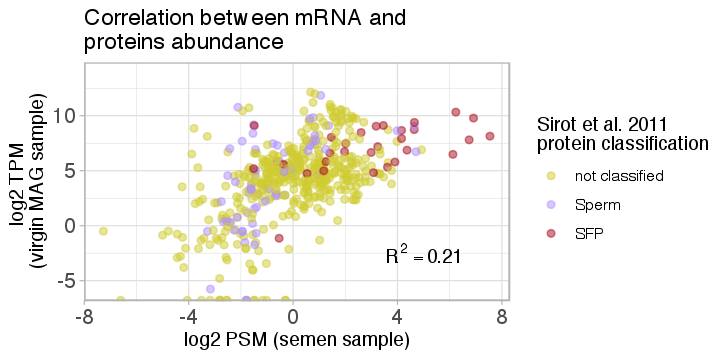

In [126]:
tmpDF$Sirot_classification <- as.character(tmpDF$Sirot_classification)
tmpDF$Sirot_classification <- ifelse(is.na(tmpDF$Sirot_classification), 
             'not classified', tmpDF$Sirot_classification)
tmpDF$Sirot_classification = factor(tmpDF$Sirot_classification, levels = c("not classified", "Sperm", "SFP"))

cor_label = data.frame(x = 5, y = -2.5, label = corr_eqn(tmpDF$log2_PSM, tmpDF$virMAG))

options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("Figures/mRNA_vs_APEX.pdf", width = 7, height = 4)
ggplot(tmpDF, aes(log2_PSM, log2(virMAG), colour = Sirot_classification)) + 
geom_point(alpha = 0.5) + 
labs(title = "Correlation between mRNA and \nproteins abundance", x = "log2 PSM (semen sample)", y = "log2 TPM \n(virgin MAG sample)", colour = "Sirot et al. 2011 \nprotein classification") +
geom_text(data = cor_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic") +
scale_colour_manual(values = c("#d0cb32", "#b090ff", "#a60f1a")) +
theme_light() +
theme(axis.text = element_text(size = 12))
# dev.off()

Here's a correlation plot between mRNA and APEX proteome abundance:

Warning message:
“Removed 557 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 529 rows containing missing values (geom_point).”

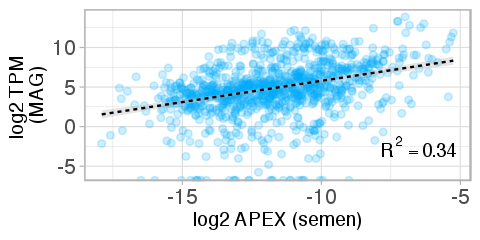

In [127]:
MAG_label = data.frame(x = -6.5, y = -2.5, label = corr_eqn(tmpDF$APEX_semen, tmpDF$virMAG))

options(repr.plot.width = 4, repr.plot.height = 2)
# pdf("Figures/MAG_mRNA_vs_APEX.pdf", width = 4, height = 2)
(MAGAPEX = ggplot(tmpDF, aes(log2(APEX_semen), log2(virMAG))) + 
geom_point(alpha = 0.2, colour = "#01aafb") + 
labs(x = "log2 APEX (semen)", y = "log2 TPM \n(MAG)") +
geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
geom_text(data = MAG_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic") +
theme_light() +
theme(axis.text = element_text(size = 12)))
# dev.off()

Warning message:
“Removed 523 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 507 rows containing missing values (geom_point).”

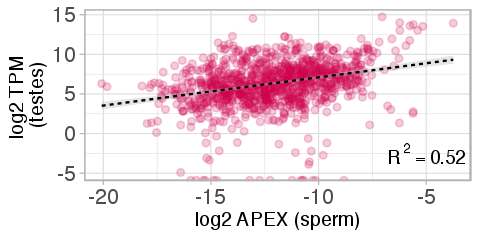

In [128]:
testes_label = data.frame(x = -5, y = -2.5, label = corr_eqn(tmpDF$APEX_sperm, tmpDF$testes))

options(repr.plot.width = 4, repr.plot.height = 2)
# pdf("Figures/testes_mRNA_vs_APEX.pdf", width = 4, height = 2)
(testesAPEX = ggplot(tmpDF, aes(log2(APEX_sperm), log2(testes))) + 
geom_point(alpha = 0.2, colour = "#d1004b") + 
labs(x = "log2 APEX (sperm)", y = "log2 TPM \n(testes)") +
geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
geom_text(data = testes_label, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic") +
theme_light() +
theme(axis.text = element_text(size = 12)))
# dev.off()

An MA plot of the APEX values shows the proteins that are discovered in both the semen and sperm samples:

[1] 649

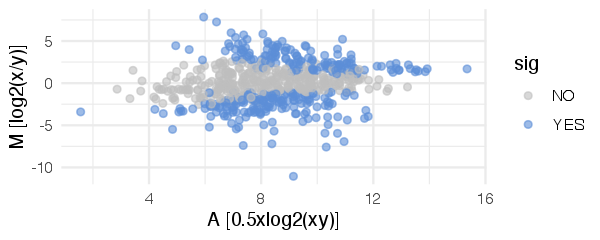

In [129]:
options(repr.plot.width = 5, repr.plot.height = 2)

nrow(subset(tmpDF, !is.na(sig)))
ggplot(subset(tmpDF, !is.na(sig)), aes(APEX_A, Signfold, colour = sig)) + 
    geom_point(alpha = 0.6) + 
    labs(y = "M [log2(x/y)]", x = "A [0.5xlog2(xy)]") + 
#     scale_x_continuous(limits=c(0,20)) + 
    theme(legend.position="none") + 
    scale_colour_manual(values=c("gray", "#5C8ED7")) +
    theme_minimal()

#### Defining the sperm proteome and SFPs:

Using this `tmpDF` object, we'd like to define the two proteins classes we're interested in, i.e. sperm proteins and SFPs. Beecause there are several ways this can be acheived, we'll explore a few possibilities and assess the list by performing GO analysis and checking which proteins are left out.

##### 1. Using the decay curve to estimate the number of proteins:

First estimate the number of proteins based on a minimum peptide count cutoff (for total peptides and unique peptides separately):

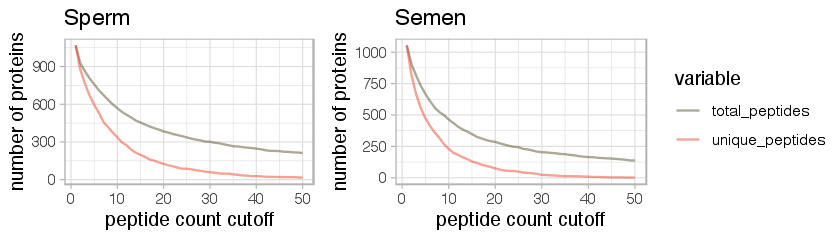

In [130]:
## Sperm
# start an empty object
sperm_uniqueDF = NULL
sperm_totalDF = NULL

# loop over a range of peptide count values and capture the number of proteins for each value
for (i in 1:50) {
    sperm_totalDF[i] = nrow(subset(tmpDF, sperm.union.full == 1 & sperm_MAX.total_peptides >= i))
    sperm_uniqueDF[i] = nrow(subset(tmpDF, sperm.union.full == 1 & sperm_MAX.unique_peptides >= i))
}

# Createa dataframe with the above output
Sp_pep_co = data.frame(peptide_cutoff = seq(1,50,1), total_peptides = sperm_totalDF, unique_peptides = sperm_uniqueDF)
Sp_pep_co = melt(Sp_pep_co, id.vars = "peptide_cutoff")


## Semen
# start an empty object
semen_uniqueDF = NULL
semen_totalDF = NULL

# loop over a range of peptide count values and capture the number of proteins for each value
for (i in 1:50) {
    semen_totalDF[i] = nrow(subset(tmpDF, semen.union.full == 1 & semen_MAX.total_peptides >= i))
    semen_uniqueDF[i] = nrow(subset(tmpDF, semen.union.full == 1 & semen_MAX.unique_peptides >= i))
}

# Createa dataframe with the above output
Se_pep_co = data.frame(peptide_cutoff = seq(1,50,1), total_peptides = semen_totalDF, unique_peptides = semen_uniqueDF)
Se_pep_co = melt(Se_pep_co, id.vars = "peptide_cutoff")


Sp_pep_gg = ggplot(Sp_pep_co, aes(peptide_cutoff, value, colour = variable)) + 
geom_line(alpha = 0.5) +
theme_light() +
labs(title = "Sperm", x = "peptide count cutoff", y = "number of proteins") +
scale_colour_manual(values = c("#5a532c","#eb462d")) +
theme(legend.position = "none")

Se_pep_gg = ggplot(Se_pep_co, aes(peptide_cutoff, value, colour = variable)) + 
geom_line(alpha = 0.5) +
theme_light() +
labs(title = "Semen", x = "peptide count cutoff", y = "number of proteins") +
scale_colour_manual(values = c("#5a532c","#eb462d"))

options(repr.plot.width = 7, repr.plot.height = 2)
# pdf("Manuscript_Figures/peptide_count.cutoff.pdf", width = 7, height = 2)
plot_grid(Sp_pep_gg, Se_pep_gg, ncol = 2, rel_widths = c(1,1.6))
# dev.off()

##### 2. Histogram of peptide counts:

We'd like to know what the peptide count ditribution. we'll plot a histogram of total and unique peptide counts for protiens detected in the sperm sample:

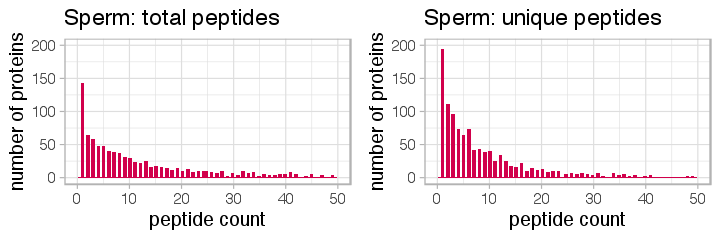

In [131]:
options(repr.plot.width = 6, repr.plot.height = 3)
sp.total_gg = ggplot(subset(tmpDF, sperm.union.full == 1)) + 
    geom_histogram(aes(sperm_MAX.total_peptides), bins = 100, fill = "#d1004b") +   
    scale_x_continuous(limits = c(0,50)) + 
    scale_y_continuous(limits = c(0,200)) +
    labs(title = "Sperm: total peptides", x = "peptide count", y = "number of proteins") +
    theme_light()

sp.unique_gg = ggplot(subset(tmpDF, sperm.union.full == 1)) +    
    geom_histogram(aes(sperm_MAX.unique_peptides), bins = 100, fill = "#d1004b") + 
    scale_x_continuous(limits = c(0,50)) + 
    scale_y_continuous(limits = c(0,200)) +
    labs(title = "Sperm: unique peptides", x = "peptide count", y = "number of proteins") + 
    theme_light()

options(repr.plot.width = 6, repr.plot.height = 2)
# pdf("~/Desktop/peptide_count_decay_sperm.pdf", width = 6, height = 2)
suppressWarnings(plot_grid(sp.total_gg, sp.unique_gg))
# dev.off()

There's a substantial drop from proteins that have one peptide to those with two peptides.

There's a bunch of ribosomal/translation proteins that we'll need to remove from SFP lists:

In [132]:
junk_proteins = unique(as.character(subset(ejaculotome_all, grepl("elongation factor", protein.name) | grepl("translation", protein.name) | grepl("ribosom", protein.name) )$gene_ID))
length(junk_proteins)

[1] 98

We'll classify the sperm proteins with ≥2 unique peptides

In [133]:
SpermProts_mstrg = unique(as.character(subset(tmpDF, sperm_combined_unique >= 2)$mstrg_ID))
SpermProts_geneID = unique(as.character(subset(tmpDF, sperm_combined_unique >= 2)$gene_ID))
# SpermProtsOnly_geneID = setdiff(SpermProts_geneID, SFPs_overlap_geneID)
SpermProts_locID = unique(as.character(subset(tmpDF, sperm_combined_unique >= 2)$loc_ID))
# SpermProtsOnly_locID = setdiff(SpermProts_locID, SFPs_overlap_locID)
length(SpermProts_mstrg)
length(SpermProts_geneID)
length(SpermProts_locID)

[1] 864

[1] 870

[1] 870

Now we'll look at the peptide count distribution of proteins present in the semen sample:

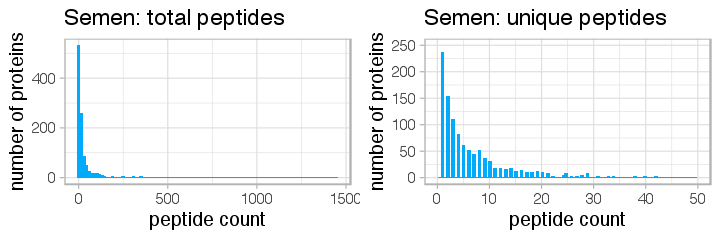

In [134]:
options(repr.plot.width = 6, repr.plot.height = 3)
se.total_gg = ggplot(subset(tmpDF, semen.union.full == 1)) + 
    geom_histogram(aes(semen_MAX.total_peptides), bins = 100, fill = "#01aafb") +   
#     scale_x_continuous(limits = c(0,50)) + 
#     scale_y_continuous(limits = c(0,250)) +
    labs(title = "Semen: total peptides", x = "peptide count", y = "number of proteins") +
    theme_light()

se.unique_gg = ggplot(subset(tmpDF, semen.union.full == 1)) +    
    geom_histogram(aes(semen_MAX.unique_peptides), bins = 100, fill = "#01aafb") + 
    scale_x_continuous(limits = c(0,50)) + 
    scale_y_continuous(limits = c(0,250)) +
    labs(title = "Semen: unique peptides", x = "peptide count", y = "number of proteins") +
    theme_light()

options(repr.plot.width = 6, repr.plot.height = 2)
# pdf("~/Desktop/peptide_count_decay_semen.pdf", width = 6, height = 2)
suppressWarnings(plot_grid(se.total_gg, se.unique_gg))
# dev.off()

For the SFP category we'll need to look at additional criteria because the semen sample contains both sperm and seminal fluids. One possibility is to use proteins that have higher abundance in the semen sample relative to the sperm sample... however this criteria can only be applied where abundance was estimated for the sperm sample.

Our Initial semen protein list is using proteins with ≥2 unique peptides only:

In [135]:
SemenProts_mstrg = unique(as.character(subset(ejaculotome_all, semen_combined_unique >= 2)$mstrg_ID))
SemenProts_geneID = unique(as.character(subset(ejaculotome_all, semen_combined_unique >= 2)$gene_ID))
SemenProts_locID = unique(as.character(subset(ejaculotome_all, semen_combined_unique >= 2)$loc_ID))
length(SemenProts_mstrg)
length(SemenProts_geneID)
length(SemenProts_locID)

[1] 805

[1] 811

[1] 811

We'll define our SFPs by restricting on several things, including minimum 2 unique peptides, more than 5 PSM

In [136]:
SFPs_mstrg = unique(as.character(subset(ejaculotome_all, semen_combined_spectra > 5 & semen_combined_unique >= 2 & is.na(sperm_combined_spectra)& gene_ID %!in% junk_proteins)$mstrg_ID))
SFPs_geneID = unique(as.character(subset(ejaculotome_all, semen_combined_spectra > 5 & semen_combined_unique >= 2 & is.na(sperm_combined_spectra) & gene_ID %!in% junk_proteins)$gene_ID))
SFPs_locID = unique(as.character(subset(ejaculotome_all, semen_combined_spectra > 5 & semen_combined_unique >= 2 & is.na(sperm_combined_spectra)& gene_ID %!in% junk_proteins)$loc_ID))
length(SFPs_mstrg)
length(SFPs_geneID)
length(SFPs_locID)

[1] 176

[1] 177

[1] 177

Using a 2.5-fold abundance difference between semen proteins and sperm proteins, we can identify an additional set of "overlap" proteins:

In [137]:
SFPs_overlap_mstrg = unique(as.character(subset(ejaculotome_all, semen_combined_spectra > 5 & semen_combined_unique >= 2 & gene_ID %!in% junk_proteins & log2_PSM >= log2(2.5))$mstrg_ID))
SFPs_overlap_geneID = unique(as.character(subset(ejaculotome_all, semen_combined_spectra > 5 & semen_combined_unique >= 2 & gene_ID %!in% junk_proteins & log2_PSM >= log2(2.5))$gene_ID))
SFPs_overlap_locID = unique(as.character(subset(ejaculotome_all, semen_combined_spectra > 5 & semen_combined_unique >= 2 & gene_ID %!in% junk_proteins & log2_PSM >= log2(2.5))$loc_ID))
length(SFPs_overlap_mstrg)
length(SFPs_overlap_geneID)
length(SFPs_overlap_locID)

[1] 103

[1] 103

[1] 103

In [138]:
SpermProtsOnly_geneID = setdiff(SpermProts_geneID, SFPs_overlap_geneID)
SpermProtsOnly_locID = setdiff(SpermProts_locID, SFPs_overlap_locID)
length(SpermProtsOnly_geneID)
length(SpermProtsOnly_locID)

[1] 767

[1] 767

Fially, we'll generate a list of the Sirot SFPs:

In [139]:
sirot_SFPs_mstrg = unique(subset(geneFeatures, loc_ID %in% sirot_SFPs & !is.na(mstrg_ID))$mstrg_ID)
sirot_SFPs_geneID = unique(subset(geneFeatures, loc_ID %in% sirot_SFPs & !is.na(mstrg_ID))$gene_ID)
sirot_SFPs_locID = unique(subset(geneFeatures, loc_ID %in% sirot_SFPs & !is.na(mstrg_ID))$loc_ID)
length(sirot_SFPs_geneID)

[1] 74

Now that we have a puttaive list of sperm and semen proteins, we'd like to see how much overlap there is between the two protein classes. The remainder of the code in this section uses the lists with proteins that have a higher TPM value in testes/MAG vs MAG/testes.

THIS WINDOW IS FOR TRYING OUT VENN DIAGRAMS:

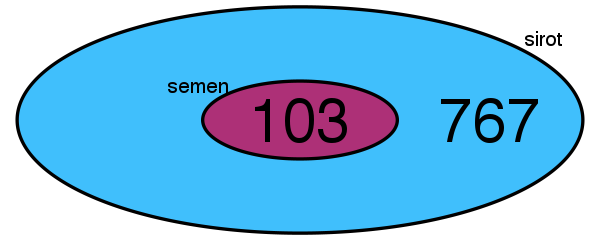

In [141]:
temp_candidates <- list(semen = SFPs_overlap_geneID, sirot = SpermProts_geneID)

temp_Vdiag<-venn.diagram(temp_candidates, NULL, fill=c("#d1004b", "#01aafb"), alpha=c(0.75,0.75), cex = 3, cat.fontface= 6, cat.cex = 1, resolution = 100, )

temp_combs <- unlist(lapply(1:length(temp_candidates), function(j) combn(names(temp_candidates), j, simplify = FALSE)), recursive = FALSE)
names(temp_combs) <- sapply(temp_combs, function(i) paste0(i, collapse = ","))
temp_elements <- lapply(temp_combs, function(i) Setdiff(temp_candidates[i], temp_candidates[setdiff(names(temp_candidates), i)]))
    
options(repr.plot.width = 5, repr.plot.height = 2)
grid.arrange(gTree(children=temp_Vdiag))

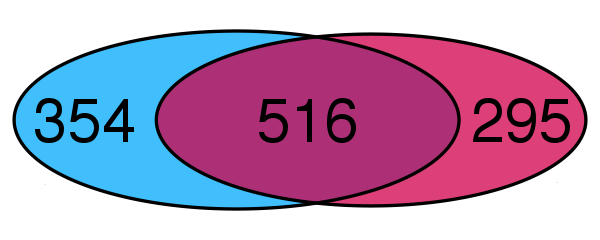

In [141]:
ejaculotome_candidates <- list(Semen = SemenProts_geneID, Sperm = SpermProts_geneID)

ejaculotome_Vdiag<-venn.diagram(ejaculotome_candidates, NULL, fill=c("#d1004b", "#01aafb"), alpha=c(0.75,0.75), cex = 3, cat.fontface= 6, cat.cex = 0, resolution = 100, )

options(repr.plot.width = 5, repr.plot.height = 2)
# pdf("Manuscript_Figures/ejaculotome_Venn_min2Pep_4fold.pdf", width = 6, height = 3)
grid.arrange(gTree(children=ejaculotome_Vdiag))
# dev.off()

Let's also plot the mRNA expression levels for these genes. We'll set the ejaculotome factors to plot alongside the heatmap, but first we need to generate the elemental object:

In [142]:
ejaculotome_candidates <- list(Semen = SemenProts_mstrg, Sperm = SpermProts_mstrg)
ejaculotome_combs <- unlist(lapply(1:length(ejaculotome_candidates), function(j) combn(names(ejaculotome_candidates), j, simplify = FALSE)), recursive = FALSE)
names(ejaculotome_combs) <- sapply(ejaculotome_combs, function(i) paste0(i, collapse = ","))
ejaculotome_elements <- lapply(ejaculotome_combs, function(i) Setdiff(ejaculotome_candidates[i], ejaculotome_candidates[setdiff(names(ejaculotome_candidates), i)]))

Now make the factor data frame:

In [143]:
ejaculotome_factor_df = as.data.frame(unlist(ejaculotome_elements))
ejaculotome_factor_df$Classification = gsub('[[:digit:]]+', '', rownames(ejaculotome_factor_df))
ejaculotome_factor_df = as.data.frame(as.list(ejaculotome_factor_df))
rownames(ejaculotome_factor_df) = ejaculotome_factor_df$unlist.ejaculotome_elements.
ejaculotome_factor_df = subset(ejaculotome_factor_df, select = "Classification")

We'll modify the above to include the overlap class as a factor in a new factor df object:

In [144]:
ejaculotome_factor_df$overlap_classification = NULL
ejaculotome_factor_df$overlap_classification = ifelse(rownames(ejaculotome_factor_df) %in% SFPs_overlap_mstrg, "overlap", ifelse(rownames(ejaculotome_factor_df) %in% SFPs_mstrg, "SFPs", ifelse(rownames(ejaculotome_factor_df) %in% SpermProts_mstrg & rownames(ejaculotome_factor_df) %!in% SFPs_overlap_mstrg, "Sperm protein", "not classified")))
ejaculotome_factor_df_x = subset(ejaculotome_factor_df, select = "overlap_classification")
ejaculotome_factor_df_x = subset(ejaculotome_factor_df_x, overlap_classification != "not classified")

We'll extract a TPM matrix for the genes in the factor table:

In [145]:
ejaculotome.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% rownames(ejaculotome_factor_df_x))
ejaculotome.meanTPM = subset(ejaculotome.meanTPM, select = c("virMAG", "depMAG", "testes"))
ejaculotome.meanTPM = subset(ejaculotome.meanTPM, rowSums(ejaculotome.meanTPM) > 10)

Now generate the heatmap:

In [147]:
data = ejaculotome.meanTPM
gene_factors = unique(ejaculotome_factor_df_x[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(12, '#00b9ff', 'black','#fbe965')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(ejaculotome_factor_df_x[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#d1004b", "#953375", "#01aafb")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -1] = -1
heatmap_data[heatmap_data > 1] = 1

options(repr.plot.width = 5, repr.plot.height = 7)
# par(mfrow=c(1,2))
# pdf("~/Desktop/FIGURES/ejaculotome_heatmap1_min2Pep_4fold.pdf", width = 5, height = 7)
# heatmap.3(heatmap_data, dendrogram = "row", col=myheatcol, RowSideColors=geneFactorAnnotations, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=2, margins=c(10,10), labRow = F, sepwidth = 4, notecex = 20,keysize = 1.5, cex.main = 4)
# dev.off()

Here's an alternative way to make the heatmap... quality is better for publication.

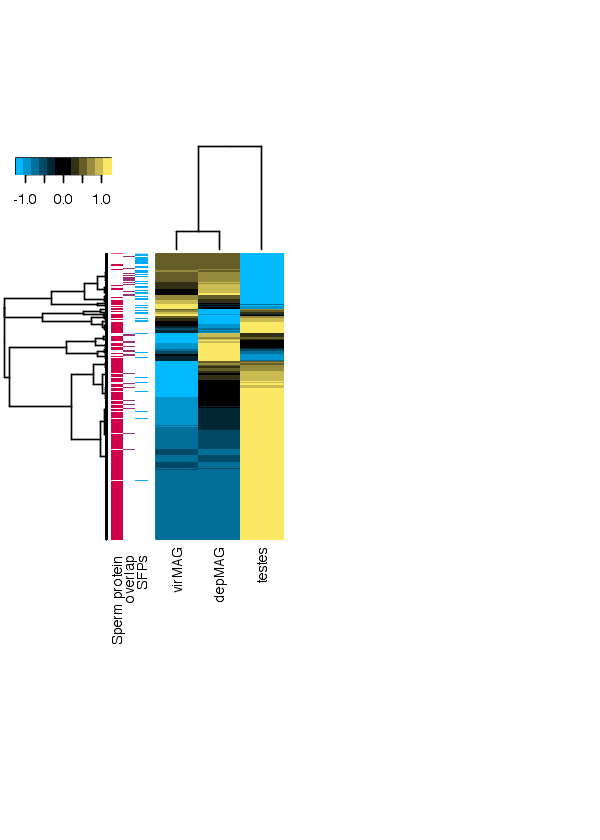

In [150]:
options(repr.plot.width = 5, repr.plot.height = 7)
# pdf("Manuscript_Figures/ejaculotome_heatmap2.pdf", width = 5, height = 7)
tmpHeat = heatmap3(heatmap_data,
         col=myheatcol, 
         cexCol = 1, 
#          srtCol = 45,
         labRow = "", 
#          adjCol = c(1,0.1),
#          legendfun=function() showLegend(legend=c("Sperm", "SFPs,Sperm", "SFPs"), 
#                                          col=c("#ff9419","#9d93ff","#a10072"), 
#                                          cex = 1), 
            cex.main=0.4, 
             RowSideColors = geneFactorAnnotations,
             margins=c(10,20))
# dev.off()

Now we can run a GO analysis on those three classes of genes. First we need to swap out mstrg_IDs for gene_IDs. 

In [151]:
ejaculotome_factor_tmp = ejaculotome_factor_df_x
ejaculotome_factor_tmp$mstrg_ID = rownames(ejaculotome_factor_df_x)
tmpFile = subset(tmpDF, mstrg_ID %in% ejaculotome_factor_tmp$mstrg_ID)
tmpFile = subset(tmpFile, select = c("mstrg_ID", "gene_ID"))
ejaculotome_factor_df2 = unique(merge(ejaculotome_factor_tmp, tmpFile))
rownames(ejaculotome_factor_df2) = ejaculotome_factor_df2$gene_ID
ejaculotome_factor_df2 = subset(ejaculotome_factor_df2, select = "overlap_classification")

Now set up the null object:

Warning message in pcls(G):
“initial point very close to some inequality constraints”

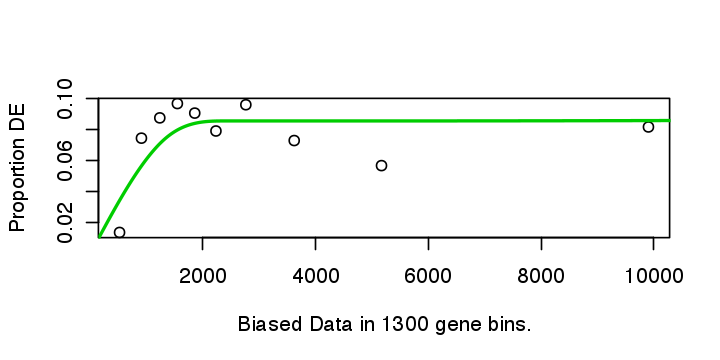

In [152]:
options(repr.plot.width = 6, repr.plot.height = 3)

cat_genes_vec = as.integer(features_with_GO %in% rownames(ejaculotome_factor_df2))
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

output the enrichment result:

In [153]:
ejaculotome_factor_list = unique(ejaculotome_factor_df2[,1])

GO_enriched_list = list()

for (feature_cat in ejaculotome_factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(ejaculotome_factor_df2)[ejaculotome_factor_df2$overlap_classification == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}

GO_enrichment_data = rbindlist(GO_enriched_list)

Processing category: Sperm protein
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: SFPs
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: overlap
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [154]:
write.table(subset(GO_enrichment_data, over_represented_FDR < 0.05), file = "Results/significant_GO_terms_SFPs-sperm-overlap.txt", quote = F, sep = "\t", row.names = F)

Now append columns to the `ejaculotome_all` object describing the protein assignments based on the criteria above (sperm, SFP, or both).

In [155]:
ejaculotome_assign = ejaculotome_all

ejaculotome_assign$Degner_classification = ifelse(ejaculotome_assign$gene_ID %in% SFPs_overlap_geneID, "Overlap", ifelse(ejaculotome_assign$gene_ID %in% SFPs_geneID, "SFP", ifelse(ejaculotome_assign$gene_ID %in% SpermProts_geneID, "Sperm protein", "not classified")))
ejaculotome_assign$Degner_classification = factor(ejaculotome_assign$Degner_classification, levels = c("SFP", "Overlap", "Sperm protein", "not classified"))

Now we'll generate a violin plot of the classifications and the log2(MAG/testes) mRNA expression:

Warning message:
“Removed 53 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 53 rows containing non-finite values (stat_boxplot).”

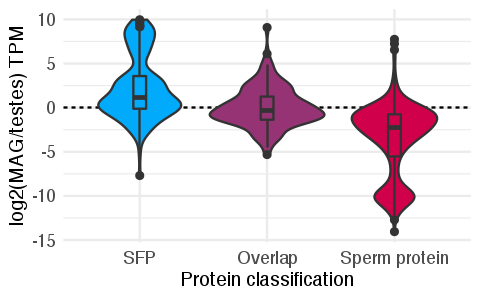

In [158]:
options(repr.plot.width = 4, repr.plot.height = 2.5)
# pdf("Manuscript_Figures/violin_plot.pdf", width = 4, height = 2.5)
ggplot(subset(ejaculotome_assign, Degner_classification != "not classified"), aes(Degner_classification, log2_MAGbyTestis, fill = Degner_classification)) + 
    geom_hline(yintercept = 0, linetype = "dashed") +
    geom_violin() + 
    geom_boxplot(width = 0.1) + 
    theme_minimal() + 
    scale_fill_manual(values = c("#01aafb", "#953375", "#d1004b")) + 
    labs(x = "Protein classification", y = "log2(MAG/testes) TPM") +
    theme(legend.position = "none", axis.text = element_text(size = 10))
# dev.off()

In [159]:
wilcox.test(subset(ejaculotome_assign, Degner_classification == "SFP")$log2_MAGbyTestis, mu=0, alternative="greater")
wilcox.test(subset(ejaculotome_assign, Degner_classification == "Overlap" & log2_MAGbyTestis != "-Inf" & log2_MAGbyTestis != "NaN")$log2_MAGbyTestis, mu=0, alternative="less")
wilcox.test(subset(ejaculotome_assign, Degner_classification == "Sperm protein" & log2_MAGbyTestis != "-Inf" & log2_MAGbyTestis != "NaN")$log2_MAGbyTestis, mu=0, alternative="less")
# t.test(subset(ejaculotome_assign, Degner_classification == "Sperm protein")$log2_MAGbyTestis, mu=0, alternative="less")


	Wilcoxon signed rank test with continuity correction

data:  subset(ejaculotome_assign, Degner_classification == "SFP")$log2_MAGbyTestis
V = 12959, p-value = 8.135e-13
alternative hypothesis: true location is greater than 0



	Wilcoxon signed rank test with continuity correction

data:  subset(ejaculotome_assign, Degner_classification == "Overlap" &     log2_MAGbyTestis != "-Inf" & log2_MAGbyTestis != "NaN")$log2_MAGbyTestis
V = 2515, p-value = 0.3555
alternative hypothesis: true location is less than 0



	Wilcoxon signed rank test with continuity correction

data:  subset(ejaculotome_assign, Degner_classification == "Sperm protein" &     log2_MAGbyTestis != "-Inf" & log2_MAGbyTestis != "NaN")$log2_MAGbyTestis
V = 16361, p-value < 2.2e-16
alternative hypothesis: true location is less than 0


We'll also generate a correlation plot of log2 PSM for the semen sample and the log2 TPM for the MAG mRNA sample, and highlihgt the Sirot 2011 SFPs. This should reflect the abundnace sensititivity differences of the two studies:

In [160]:
ejaculotome_assign$Sirot_classification_2 <- NULL
ejaculotome_assign$Sirot_classification_2 <- ifelse(ejaculotome_assign$gene_ID %in% sirot_SFPs_geneID, "SFP", "not classified")
ejaculotome_assign$Sirot_classification_2 <- factor(ejaculotome_assign$Sirot_classification_2, levels = c("SFP", "not classified"))

myData = subset(ejaculotome_assign, Degner_classification == "SFP" | Degner_classification == "Overlap")
labels = data.frame(x = 10, y = 2, label = corr_eqn(myData$Semen_total_normalized_PSM, myData$virMAG))

In [255]:
head(ejaculotome_assign)

mstrg_ID    loc_ID       gene_ID    gene_name protein       
1 AAEL005842  LOC5579848   AAEL005842 NA        XP_001651523.2
2 AAEL024221  LOC110676197 AAEL024221 NA        XP_021698820.1
3 AAEL025688  LOC110677796 AAEL025688 NA        XP_021705014.1
4 AAEL026515  LOC110677798 AAEL026515 NA        XP_021705016.1
5 AAEL026783  LOC110680269 AAEL026783 NA        XP_021711783.1
6 MSTRG.10013 LOC5564707   AAEL014576 NA        XP_001649051.1
  protein.name                                                
1 O-acyltransferase like protein                              
2 uncharacterized protein LOC110676197                        
3 histone H1-like                                             
4 histone H2A                                                 
5 tetraspanin-11-like                                         
6 pentatricopeptide repeat-containing protein 2, mitochondrial
  sperm.combined.full sperm.tandem.full sperm.comet.full sperm.union.full ⋯
1 0                   0                 1                1                ⋯
2 0                   0                 1                1                ⋯
3 0                   1                 0                1                ⋯
4 1                   1                 1                1                ⋯
5 0                   0                 0                0                ⋯
6 1                   1                 1                1                ⋯
  semen_MAX.total_peptides semen_MAX.unique_peptides sperm_MAX.total_peptides
1  0                       0                         1                       
2  0                       0                         2                       
3  0                       0                         2                       
4  0                       0                         9                       
5 17                       2                         0                       
6  1                       1                         8                       
  sperm_MAX.unique_peptides Semen_total_normalized_PSM log2_MAGbyTestis
1 1                               NA                        -Inf       
2 1                               NA                         NaN       
3 1                               NA                         NaN       
4 3                               NA                        -Inf       
5 0                         30.29765                         NaN       
6 4                               NA                   -1.248837       
  log2_PSM APEX_A   Degner_classification Sirot_classification_2
1 NA            NaN not classified        not classified        
2 NA            NaN not classified        not classified        
3 NA             NA not classified        not classified        
4 NA            NaN Sperm protein         not classified        
5 NA            NaN SFP                   not classified        
6 NA       5.982379 Sperm protein         not classified

In [263]:
myIds = data.frame(myIds = c("LOC5571971", "LOC5571171", "LOC110678767", "LOC110674344", "LOC110674297", "LOC5563591", "LOC5563563", "LOC5563590", "LOC5563589", "LOC5563654", "LOC5567804", "LOC5567772", "LOC5570055", "LOC5570007", "LOC5570014", "LOC5570018", "LOC5572023", "LOC5572024", "LOC5573753", "LOC5573757", "LOC5573778", "LOC5573731", "LOC5575133", "LOC5575162", "LOC5575951", "LOC5575167", "LOC5575199", "LOC5575157", "LOC5576333", "LOC5577327", "LOC5577356", "LOC5577381", "LOC5577322", "LOC5577369", "LOC110678058", "LOC5578443", "LOC5578459", "LOC5578442", "LOC5563673", "LOC5563688", "LOC5563689", "LOC5564317", "LOC5564323", "LOC5564319", "LOC5564312", "LOC5565428", "LOC5565441", "LOC5565418", "LOC5565913", "LOC5566290", "LOC5566298", "LOC5566613", "LOC5566585", "LOC5566612", "LOC5566847", "LOC5566846", "LOC5566852", "LOC5566888", "LOC5566848", "LOC5566901", "LOC5567179", "LOC5567491", "LOC5567821", "LOC5567848", "LOC5567839", "LOC5579885", "LOC5579902", "LOC5568355", "LOC5568366", "LOC5568365", "LOC5568367", "LOC5568600", "LOC5568587", "LOC5568583", "LOC5568558", "LOC5568802", "LOC5568808", "LOC5568815", "LOC5568814", "LOC5569078", "LOC5569083", "LOC5569085", "LOC5569067", "LOC5569604", "LOC5570068", "LOC5570072", "LOC5570063", "LOC5570323", "LOC5570505", "LOC5570524", "LOC5570509", "LOC5570724", "LOC5571126", "LOC5571262", "LOC5571267", "LOC5571265", "LOC5571293", "LOC5571511", "LOC5571505", "LOC5571642", "LOC5571677", "LOC5571676", "LOC5571832", "LOC5572071", "LOC5572074", "LOC5572284", "LOC5572433", "LOC5572431", "LOC5572650", "LOC5572671", "LOC5572786", "LOC5572799", "LOC5572788", "LOC5572982", "LOC5573001", "LOC5573184", "LOC5573124", "LOC5573178", "LOC5573193", "LOC5573413", "LOC5573411", "LOC5573396", "LOC5573392", "LOC5573395", "LOC5573417", "LOC5573407", "LOC5573581", "LOC5573603", "LOC5573600", "LOC5580091", "LOC5580066", "LOC5580070", "LOC5580056", "LOC5573894", "LOC5573900", "LOC5574091", "LOC5574082", "LOC5574197", "LOC5574338", "LOC5574348", "LOC5574351", "LOC5574354", "LOC5574485", "LOC5574496", "LOC5574484", "LOC5574592", "LOC5574590", "LOC5574823", "LOC5574792", "LOC5574976", "LOC5574977", "LOC5574980", "LOC5580194", "LOC5580166", "LOC5580206", "LOC5580168", "LOC5575578", "LOC5575539", "LOC5575660", "LOC5574912", "LOC5575986", "LOC5576131", "LOC5576223", "LOC5576214", "LOC5576215", "LOC5576221", "LOC5576226", "LOC5576245", "LOC5576244", "LOC5576357", "LOC5576348", "LOC5576366", "LOC5576351", "LOC5576354", "LOC5576362", "LOC5576472", "LOC5576488", "LOC5576478", "LOC5576594", "LOC5576737", "LOC5580264", "LOC5580280", "LOC5576879", "LOC5576894", "LOC5576986", "LOC5577061", "LOC5577060", "LOC5577227", "LOC5577407", "LOC5577397", "LOC5577393", "LOC5577499", "LOC5577626", "LOC5577642", "LOC5577628", "LOC5577627", "LOC5577777", "LOC5577756", "LOC5577771", "LOC5577768", "LOC5578008", "LOC5577991", "LOC5578088", "LOC5578123", "LOC5578121", "LOC5578114", "LOC5578207", "LOC5578272", "LOC5578276", "LOC5578370", "LOC5578548", "LOC5578546", "LOC5578625", "LOC5578622", "LOC5578669", "LOC5578774", "LOC5578759", "LOC110676735", "LOC5578796", "LOC110676733", "LOC5578862", "LOC5578943", "LOC5578926", "LOC5578916", "LOC5578941", "LOC5579001", "LOC5579109", "LOC5579181", "LOC5579168", "LOC5579186", "LOC5579187", "LOC5563714", "LOC5563716", "LOC5579651", "LOC5579795", "LOC5579650", "LOC5563900", "LOC5563911", "LOC5563904", "LOC5563914", "LOC5563916", "LOC5563951", "LOC5564039", "LOC5564045", "LOC5564065", "LOC5564124", "LOC5564133", "LOC5564118", "LOC5564179", "LOC5564231", "LOC5564252", "LOC5564249", "LOC5564399", "LOC5564397", "LOC5564392", "LOC5564404", "LOC5564447", "LOC5564504", "LOC5564492", "LOC5564509", "LOC5564545", "LOC5564556", "LOC5564593", "LOC5564584", "LOC5564581", "LOC5564645", "LOC5564654", "LOC5564678", "LOC5564798", "LOC5564768", "LOC5564787", "LOC5564769", "LOC5564856", "LOC5564871", "LOC5564860", "LOC5564866", "LOC5564922", "LOC5564921", "LOC5564976", "LOC5565050", "LOC5565063", "LOC5565055", "LOC5565051", "LOC5565095", "LOC5565159", "LOC5565155", "LOC5565219", "LOC5565224", "LOC5565255", "LOC5565257", "LOC5565266", "LOC5565273", "LOC5565318", "LOC5565366", "LOC5565387", "LOC5565372", "LOC5565380", "LOC5565506", "LOC5565544", "LOC5564450", "LOC5565614", "LOC5565612", "LOC5565667", "LOC5565652", "LOC5565681", "LOC5565782", "LOC5565777", "LOC5565774", "LOC5565839", "LOC5565854", "LOC5565955", "LOC5565927", "LOC5565954", "LOC5565979", "LOC5566003", "LOC5566006", "LOC5566087", "LOC5566092", "LOC5566125", "LOC5566172", "LOC5565962", "LOC5566170", "LOC5566173", "LOC5566154", "LOC5566167", "LOC5566228", "LOC5566236", "LOC5566217", "LOC5566316", "LOC5566309", "LOC5566357", "LOC5566442", "LOC5566450", "LOC5566484", "LOC5566471", "LOC5566470", "LOC5566485", "LOC5566525", "LOC5566514", "LOC5566542", "LOC5566563", "LOC5566638", "LOC5566654", "LOC5579822", "LOC5566668", "LOC5566703", "LOC5566701", "LOC5566741", "LOC5566724", "LOC5566725", "LOC5566764", "LOC5566800", "LOC5566804", "LOC5566937", "LOC5566959", "LOC5566973", "LOC5566975", "LOC5567014", "LOC5567031", "LOC5567033", "LOC5567037", "LOC5567068", "LOC5567100", "LOC5567097", "LOC5579830", "LOC5567139", "LOC5567167", "LOC5567163", "LOC5567259", "LOC5567312", "LOC5567322", "LOC5567329", "LOC5567347", "LOC5567371", "LOC5567374", "LOC5567399", "LOC5567390", "LOC5567383", "LOC5567423", "LOC5567422", "LOC5567448", "LOC5567501", "LOC5567509", "LOC5567537", "LOC5567565", "LOC5567581", "LOC5567576", "LOC5567583", "LOC5567637", "LOC5567709", "LOC5567857", "LOC5567851", "LOC5567881", "LOC5567877", "LOC5567879", "LOC5567930", "LOC5567928", "LOC5567933", "LOC5567954", "LOC5567966", "LOC5567967", "LOC5567972", "LOC5567965", "LOC5567969", "LOC5567970", "LOC5567968", "LOC5567991", "LOC5567996", "LOC5568019", "LOC5568010", "LOC5568011", "LOC5568044", "LOC5568081", "LOC5568105", "LOC5568150", "LOC5568141", "LOC5568149", "LOC5568202", "LOC5568211", "LOC5568234", "LOC5568261", "LOC5568260", "LOC5568289", "LOC5568292", "LOC5568320", "LOC5567330", "LOC5568398", "LOC5579924", "LOC5568408", "LOC5568414", "LOC5568430", "LOC5568426", "LOC5568428", "LOC5568441", "LOC5568466", "LOC5568471", "LOC5568472", "LOC5568498", "LOC5568501", "LOC5568513", "LOC5568503", "LOC5568509", "LOC5568521", "LOC5568526", "LOC5568537", "LOC5568625", "LOC5568618", "LOC5568658", "LOC5568694", "LOC5568716", "LOC5568701", "LOC5568690", "LOC5568726", "LOC5568788", "LOC5568784", "LOC5568881", "LOC5568871", "LOC5568877", "LOC5571215", "LOC5568888", "LOC5568890", "LOC5568914", "LOC5568948", "LOC5568923", "LOC5568965", "LOC5569005", "LOC5569014", "LOC5569015", "LOC5568986", "LOC5579488", "LOC5569097", "LOC5569141", "LOC5569167", "LOC5569219", "LOC5569268", "LOC5569281", "LOC5569339", "LOC5569338", "LOC5569288", "LOC5569310", "LOC5569333", "LOC5569371", "LOC5569456", "LOC5579472", "LOC5569471", "LOC5569466", "LOC5569508", "LOC5569497", "LOC5569507", "LOC5569529", "LOC5569514", "LOC5569523", "LOC5569520", "LOC5569515", "LOC5569531", "LOC5569547", "LOC5569575", "LOC5569582", "LOC5569632", "LOC5569668", "LOC5569700", "LOC5569705", "LOC5569771", "LOC5569760", "LOC5569759", "LOC5569750", "LOC5569863", "LOC5569898", "LOC5569895", "LOC5569936", "LOC5569948", "LOC5569945", "LOC110678504", "LOC5570139", "LOC5570127", "LOC5570159", "LOC5570148", "LOC5570171", "LOC5570233", "LOC5570205", "LOC5570243", "LOC5570276", "LOC5570295", "LOC5570310", "LOC5570366", "LOC5570396", "LOC5570429", "LOC5570426", "LOC5570455", "LOC5570558", "LOC5570583", "LOC5570597", "LOC5570622", "LOC5570653", "LOC5570676", "LOC5570661", "LOC5570667", "LOC5570663", "LOC5570670", "LOC5570694", "LOC5570690", "LOC5570738", "LOC5570735", "LOC5570746", "LOC5570787", "LOC5570786", "LOC5570819", "LOC5570839", "LOC5570867", "LOC5570939", "LOC5577113", "LOC5571045", "LOC5571043", "LOC5571046", "LOC5571067", "LOC5571080", "LOC5571075", "LOC5571091", "LOC5571156", "LOC5571150", "LOC5571153", "LOC5571172", "LOC5571208", "LOC5571310", "LOC5571321", "LOC5571397", "LOC5571388", "LOC5571413", "LOC5571429", "LOC5571419", "LOC5571437", "LOC5571450", "LOC5571444", "LOC5571467", "LOC5571557", "LOC5571564", "LOC5571567", "LOC5571584", "LOC5571587", "LOC5571596", "LOC5571701", "LOC5571704", "LOC5571707", "LOC5571745", "LOC5571763", "LOC5571779", "LOC5571773", "LOC5571785", "LOC5571789", "LOC5571783", "LOC5571804", "LOC5571854", "LOC5571892", "LOC5571900", "LOC5571932", "LOC5571930", "LOC5571907", "LOC5571976", "LOC5572005", "LOC5572090", "LOC5572080", "LOC5572081", "LOC5572119", "LOC5572146", "LOC5572148", "LOC5572209", "LOC5572193", "LOC5580010", "LOC5580024", "LOC5572254", "LOC5572308", "LOC5572315", "LOC5572365", "LOC5572361", "LOC5572372", "LOC5572374", "LOC5572478", "LOC5572474", "LOC5572531", "LOC5572546", "LOC5572547", "LOC5572552", "LOC5572561", "LOC5572582", "LOC5572673", "LOC5572681", "LOC5572725", "LOC5572730", "LOC5572735", "LOC5572750", "LOC5572843", "LOC5572847", "LOC5572840", "LOC5572836", "LOC5572867", "LOC5572903", "LOC5572925", "LOC5572923", "LOC5572929", "LOC5572924", "LOC5572967", "LOC5572968", "LOC5573027", "LOC5580034", "LOC5580036", "LOC5580049", "LOC5573211", "LOC5573238", "LOC5573247", "LOC5573250", "LOC5573292", "LOC5573319", "LOC5573374", "LOC5573380", "LOC5573443", "LOC5573452", "LOC5573467", "LOC5573464", "LOC5573460", "LOC5573525", "LOC5573534", "LOC5573545", "LOC5573548", "LOC5573533", "LOC5573535", "LOC5575223", "LOC5573650", "LOC5573644", "LOC5573692", "LOC5573670", "LOC5573669", "LOC5573699", "LOC5573712", "LOC5573704", "LOC5573804", "LOC5573821", "LOC5573830", "LOC5573827", "LOC5573863", "LOC5573854", "LOC5573976", "LOC5573984", "LOC5573974", "LOC5573968", "LOC5574001", "LOC5573990", "LOC5574024", "LOC5574040", "LOC5574159", "LOC5574220", "LOC5574230", "LOC5574237", "LOC5574282", "LOC5574385", "LOC5574391", "LOC5574410", "LOC5574404", "LOC5574421", "LOC5574437", "LOC5574438", "LOC5574516", "LOC5574512", "LOC5574526", "LOC5574529", "LOC5574625", "LOC5574624", "LOC5574637", "LOC5574633", "LOC5574648", "LOC5574647", "LOC5574667", "LOC5574713", "LOC5574746", "LOC5574761", "LOC5574830", "LOC5574844", "LOC5574862", "LOC5574866", "LOC5574870", "LOC5574897", "LOC5577974", "LOC5575012", "LOC5575032", "LOC5575048", "LOC5575065", "LOC5575082", "LOC5575085", "LOC5575109", "LOC5575102", "LOC5575111", "LOC5575242", "LOC5575268", "LOC5575271", "LOC5575273", "LOC5575274", "LOC5575287", "LOC5575379", "LOC5575372", "LOC5575377", "LOC5575386", "LOC5575395", "LOC5575483", "LOC5575492", "LOC5579263", "LOC5575512", "LOC5575533", "LOC5575654", "LOC5575655", "LOC5575683", "LOC5575696", "LOC5575706", "LOC5575715", "LOC5575718", "LOC5575790", "LOC5575792", "LOC5575813", "LOC5575809", "LOC5575837", "LOC5575828", "LOC5575831", "LOC5575826", "LOC5575843", "LOC5575863", "LOC5571882", "LOC5575910", "LOC5575924", "LOC5575922", "LOC5575914", "LOC5575939", "LOC5575967", "LOC5576009", "LOC5576029", "LOC5576043", "LOC5576078", "LOC5567092", "LOC5576082", "LOC5576079", "LOC5576084", "LOC5576170", "LOC5576174", "LOC5574223", "LOC5576201", "LOC5576266", "LOC5576272", "LOC5576287", "LOC5576311", "LOC5576302", "LOC5580250", "LOC5576501", "LOC5576532", "LOC5580259", "LOC5576552", "LOC5576555", "LOC5576653", "LOC5576678", "LOC5576745", "LOC5576765", "LOC5576763", "LOC5576835", "LOC5576840", "LOC5576841", "LOC5576934", "LOC5580315", "LOC5576950", "LOC5576957", "LOC5577020", "LOC5577035", "LOC5577034", "LOC5577033", "LOC5577026", "LOC5577078", "LOC5577095", "LOC5577094", "LOC5577180", "LOC5580325", "LOC5580329", "LOC5580330", "LOC5580328", "LOC5580331", "LOC5577191", "LOC5577214", "LOC5577284", "LOC5577289", "LOC5577291", "LOC5577425", "LOC5577478", "LOC5577489", "LOC5577486", "LOC5577483", "LOC5577537", "LOC5577552", "LOC5577568", "LOC5577692", "LOC5577723", "LOC5577809", "LOC5577808", "LOC5577888", "LOC5577893", "LOC5577947", "LOC5577972", "LOC5577984", "LOC5578147", "LOC5578153", "LOC5578234", "LOC5578303", "LOC5578295", "LOC5578313", "LOC5565281", "LOC5578374", "LOC5578388", "LOC5578522", "LOC110674037", "LOC5578532", "LOC5578538", "LOC5578596", "LOC5578710", "LOC5578728", "LOC5578731", "LOC5578806", "LOC5578833", "LOC5578900", "LOC5578950", "LOC5576054", "LOC5579027", "LOC5579061", "LOC5579216", "LOC5563729", "LOC5563744", "LOC5563812", "LOC5566454", "LOC5574681", "LOC5563925", "LOC5563930", "LOC5563941", "LOC5564097", "LOC5564146", "LOC5564424", "LOC5579975", "LOC5564469", "LOC5564606", "LOC5579525", "LOC5567116", "LOC5564707", "LOC5564713", "LOC5564895", "LOC5564950", "LOC5565025", "LOC5565077", "LOC5565237", "LOC5565246", "LOC5565405", "LOC5565520", "LOC5576553", "LOC5564962", "LOC5565629", "LOC5565637", "LOC5565701", "LOC5565748", "LOC5579517", "LOC5578243", "LOC5565869", "LOC5565994", "LOC5566099", "LOC5579514", "LOC5566251", "LOC5579480", "LOC5572190", "LOC5579398", "LOC5579278", "LOC5579271", "LOC5579259", "LOC5578236", "LOC23687404", "LOC23687432", "LOC23687516", "LOC23687553", "LOC23687671", "LOC23687683", "LOC23687735", "LOC23687788", "LOC23687815", "LOC23687880", "LOC23687919", "LOC23687928", "LOC23687932", "LOC23687936", "LOC23687987", "LOC110675463", "LOC110677777", "LOC5565904", "LOC5574733", "LOC5570727", "LOC5578230", "LOC5564200", "LOC5574489", "LOC5576237", "LOC5564865", "LOC5579855", "LOC110678734", "LOC5564117", "LOC5566699", "LOC5571230", "LOC5564019", "LOC110679586", "LOC5576390", "LOC5566555", "LOC5566981", "LOC5577718", "LOC5568916", "LOC5566787", "LOC5571289", "LOC5570456", "LOC5578745", "LOC5568842", "LOC5573800", "LOC5565116", "LOC5573673", "LOC5572779", "LOC110678887", "LOC110676734", "LOC5566033", "LOC5563772", "LOC5574515", "LOC5570433", "LOC5574420", "LOC5577439", "LOC23687579", "LOC110676765", "LOC110677914", "LOC5573744", "LOC5574099", "LOC5579337", "LOC110674492", "LOC5576066", "LOC5567360", "LOC5570108", "LOC110681451", "LOC23687567", "LOC110676999", "LOC110675561", "LOC110680475", "LOC110674166", "LOC5569249", "LOC110679365", "LOC5572256", "LOC110681562", "LOC110676642", "LOC5563918", "LOC5574634", "LOC5566344", "LOC110675671", "LOC110678873", "LOC5563646", "LOC110676896", "LOC5580042", "LOC110676038", "LOC110675318", "LOC5567722", "LOC110679879", "LOC5576381", "LOC5564957", "LOC110680419", "LOC5578235", "LOC110679570", "LOC110679190", "LOC110679637", "LOC110674877", "LOC5564334", "LOC110678949", "LOC110675486", "LOC110678859", "LOC110678498", "LOC5564934", "LOC110676601", "LOC5568391", "LOC110674107", "LOC110679324", "LOC5566119", "LOC5566845", "LOC5571326", "LOC110676763", "LOC5573055", "LOC5574066", "LOC110675476", "LOC5578293", "LOC110679323", "LOC5564092", "LOC5580242", "LOC5573557", "LOC110675670", "LOC5574678", "LOC5564225", "LOC110678659", "LOC5565085", "LOC5566662", "LOC110678083", "LOC5572167", "LOC5579328", "LOC110680875", "LOC110676675", "LOC5574074", "LOC5566051", "LOC23687789", "LOC5574372", "LOC110679199", "LOC110681025", "LOC110676292", "LOC110675339", "LOC110680228", "LOC5579374", "LOC110676515", "LOC110677776", "LOC110679567", "LOC5579143", "LOC5567071", "LOC110674134", "LOC5575149", "LOC110677663", "LOC110677051", "LOC110676232", "LOC110676788", "LOC110676645", "LOC5575785", "LOC110680561", "LOC110678874", "LOC110677813", "LOC5567248", "LOC110674214", "LOC110675538", "LOC110681427", "LOC110674690", "LOC5572543", "LOC110677764", "LOC110680448", "LOC110678313", "LOC5567111", "LOC110676030", "LOC110679213", "LOC110680277", "LOC5576744", "LOC5573987", "LOC5564048", "LOC110677255", "LOC5578360", "LOC110674002", "LOC110673997", "LOC5572494", "LOC110678312", "LOC5567368", "LOC110675667", "LOC110674641", "LOC5575733", "LOC5576630", "LOC5576003", "LOC110680755", "LOC5569564", "LOC110681383", "LOC5569151", "LOC5565931", "LOC110676807", "LOC110676831", "LOC5577930", "LOC110681315", "LOC5573435", "LOC110676307", "LOC110676664", "LOC5576758", "LOC5564627", "LOC5568998", "LOC5570472", "LOC110675574", "LOC110680246", "LOC110679299", "LOC110681150", "LOC110679353", "LOC110675757", "LOC110675597", "LOC110675348", "LOC5571983", "LOC110673982", "LOC110681444", "LOC5573038", "LOC110678977", "LOC110680939", "LOC5577612", "LOC110678936", "LOC5565989", "LOC5566826", "LOC110680223", "LOC5571992", "LOC110677839", "LOC110677798", "LOC110675429", "LOC110675885", "LOC110677851", "LOC110680269", "LOC5572106", "LOC110678099", "LOC110679094", "LOC110680500", "LOC110676327", "LOC110677031", "LOC110675203", "LOC5576554", "LOC5574565", "LOC110679428", "LOC110675647", "LOC110674442", "LOC5569889", "LOC110680302", "LOC110675877", "LOC110675678", "LOC5577392", "LOC110678019", "LOC110674239", "LOC110678469", "LOC5571980", "LOC110677892", "LOC110679315", "LOC5564091", "LOC110676744", "LOC110677952", "LOC23687573", "LOC110681270", "LOC5568646"))

In [264]:
newIds = subset(ejaculotome_assign, select = c("loc_ID","Sirot_classification"))

In [273]:
write.table(merge(myIds, newIds, by.x = "myIds", by.y = "loc_ID",all.x = T, sort = F), "Sirot_class.txt", quote = F, sep = "\t", row.names = F)

Now plot it"

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”

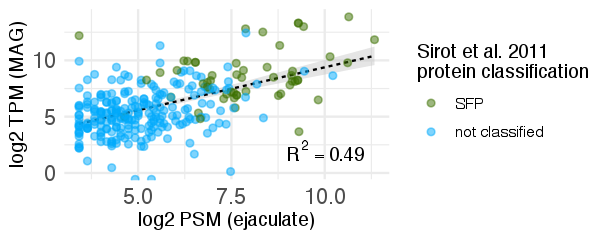

In [161]:
options(repr.plot.width = 5, repr.plot.height = 2)
# pdf("Manuscript_Figures/mRNA_vs_APEX.pdf", width = 5, height = 3)
ggplot(myData, aes(log2(Semen_total_normalized_PSM), log2(virMAG), colour = Sirot_classification_2)) + 
geom_smooth(colour = "black", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") +
geom_point(alpha = 0.5) + 
labs(x = "log2 PSM (ejaculate)", y = "log2 TPM (MAG)", colour = "Sirot et al. 2011 \nprotein classification") +
geom_text(data = labels, aes(x = x, y = y, label = paste(label)), colour = "black", parse = TRUE, fontface = "italic") +
scale_colour_manual(values = c("#3c7100", "#01aafb")) +
theme_minimal() +
theme(axis.text = element_text(size = 12.5))
# dev.off()

Let's run an F-test to see if this fit is significant:

In [162]:
SFPs.lm = lm(Semen_total_normalized_PSM ~ virMAG, data=myData)
summary(SFPs.lm)


Call:
lm(formula = Semen_total_normalized_PSM ~ virMAG, data = myData)

Residuals:
    Min      1Q  Median      3Q     Max 
-465.51  -71.68  -57.97   -8.82 2190.89 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 84.789468  13.700693   6.189 2.13e-09 ***
virMAG       0.083347   0.008873   9.394  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 223.3 on 282 degrees of freedom
Multiple R-squared:  0.2383,	Adjusted R-squared:  0.2356 
F-statistic: 88.24 on 1 and 282 DF,  p-value: < 2.2e-16


We can also plot a barplot showing the percentage of proteins with predicted signal peptides for each ejaculotome class:

Using  as id variables


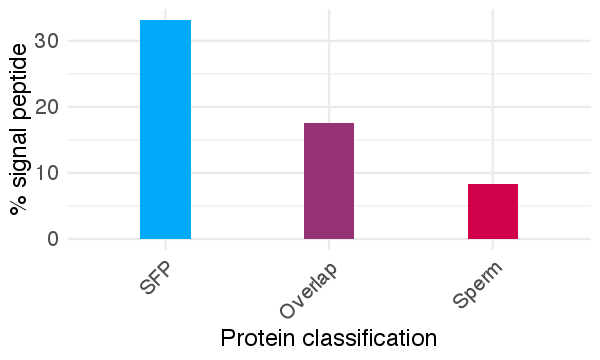

In [169]:
SigPeptide_percentages = data.frame(SFP = nrow(subset(ejaculotome_assign, Degner_classification == "SFP" & signalP == "YES"))/nrow(subset(ejaculotome_assign, Degner_classification == "SFP"))*100, Overlap = nrow(subset(ejaculotome_assign, Degner_classification == "Overlap" & signalP == "YES"))/nrow(subset(ejaculotome_assign, Degner_classification == "Overlap"))*100, Sperm= nrow(subset(ejaculotome_assign, Degner_classification == "Sperm protein" & signalP == "YES"))/nrow(subset(ejaculotome_assign, Degner_classification == "Sperm protein"))*100)
SigPeptide_percentages = melt(SigPeptide_percentages)

options(repr.plot.width = 5, repr.plot.height = 3)
# pdf("Manuscript_Figures/sigP.pdf", width = 5, height = 3)
ggplot(SigPeptide_percentages, aes(variable, value, fill = variable)) + 
    geom_bar(stat = "identity", width = 0.3) +
    theme_minimal() +
    scale_fill_manual(values = c("#01aafb", "#953375", "#d1004b")) +
    labs(x = "Protein classification", y = "% signal peptide") +
#     geom_signif(comparisons = list("SFP", "Sperm"),
#                map_signif_level = TRUE, textsize=6) +
#     ylim(NA, 34) +
    theme(legend.position = "none",axis.text.y = element_text(size = 12), axis.text.x = element_text(angle = 45, hjust = 1, size = 12), axis.title = element_text(size = 14)) 
# dev.off()

Now write out the entire set of proteome results to file:

In [170]:
write.table(ejaculotome_assign, file = "Results/Ejaculotome_db.v4.txt", quote = F, sep = "\t", row.names = F)

Now that we have the protein classifications, we can revisit the mated vs. virgin DE data and map onto the classifications on the volcano plot:

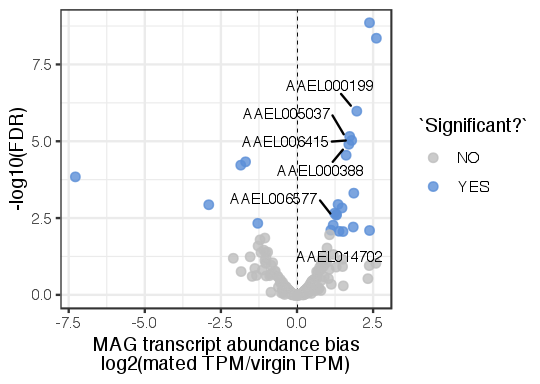

In [171]:
tmpVolcano = lrt.vdMAG.tTags.table
tmpVolcano$`Significant?` = ifelse(tmpVolcano$FDR < 0.01 & tmpVolcano$logFC > 1 | tmpVolcano$FDR < 0.01 & tmpVolcano$logFC < -1, "YES", "NO")

# tmpVolcano$ejaculotome_status = ifelse(tmpVolcano$VB_ID %in% SFPs_geneID, "SFP", ifelse(tmpVolcano$VB_ID %in% SFPs_overlap_geneID, "overlap", ifelse(tmpVolcano$VB_ID %in% SpermProts_geneID & tmpVolcano$VB_ID %!in% SFPs_overlap_geneID, "Sperm protein", "unclassified")))
# tmpVolcano$ejaculotome_status = factor(tmpVolcano$ejaculotome_status, levels = c("SFP", "overlap", "Sperm protein", "unclassified"))

tmpVolcano$ejaculotome_status = ifelse(tmpVolcano$VB_ID %in% SFPs_geneID | tmpVolcano$VB_ID %in% SFPs_overlap_geneID, "SFP", "unclassified")
tmpVolcano$ejaculotome_status = factor(tmpVolcano$ejaculotome_status, levels = c("SFP", "unclassified"))

options(repr.plot.width = 4.5, repr.plot.height = 3.2)
# pdf("Manuscript_Figures/deMAG_volcano_plot_split.pdf", width = 4.5, height = 3)
ggplot(filter(tmpVolcano, ejaculotome_status == "SFP"), aes(logFC, -log10(FDR), colour = `Significant?`)) + 
    geom_vline(xintercept = 0, linetype = "dashed", size = 0.2) +
    geom_point(alpha=0.8, size = 2) + 
#     facet_grid(.~ejaculotome_status) +
    geom_text_repel(data = subset(tmpVolcano, `Significant?` == "YES" & logFC > 1 & ejaculotome_status == "SFP" & grepl("tRNA", Description) & -log10(FDR) > 2), 
                    aes(logFC, -log10(FDR),label=VB_ID), 
                    force = 10, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3,
                    colour = "black") +
    scale_colour_manual(values = c("gray", "#5C8ED7")) +
    labs(x = "MAG transcript abundance bias\nlog2(mated TPM/virgin TPM)") + 
    theme(axis.text.x = element_text(size = 14)) + 
    theme_bw()
# dev.off()

Make a list of significant up and down genes:

In [172]:
up.SFPs.MAG = filter(tmpVolcano, ejaculotome_status == "SFP" & `Significant?` == "YES" & logFC > 0)$VB_ID
down.SFPs.MAG = filter(tmpVolcano, ejaculotome_status == "SFP" & `Significant?` == "YES" & logFC < 0)$VB_ID

Run a binomial test to see if there's significantly more upregulated SFPs after mating:

In [173]:
nrow(filter(tmpVolcano, grepl("tRNA ligase", Description)))/nrow(tmpVolcano)

[1] 0.00339811

In [174]:
binom.test(6, 19, 0.00339)


	Exact binomial test

data:  6 and 19
number of successes = 6, number of trials = 19, p-value = 3.965e-11
alternative hypothesis: true probability of success is not equal to 0.00339
95 percent confidence interval:
 0.1257606 0.5655016
sample estimates:
probability of success 
             0.3157895 


In [175]:
binom.test(c(length(unique(up.SFPs.MAG)), length(unique(down.SFPs.MAG))), 0.5)


	Exact binomial test

data:  c(length(unique(up.SFPs.MAG)), length(unique(down.SFPs.MAG)))
number of successes = 19, number of trials = 24, p-value = 0.006611
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.5784872 0.9286814
sample estimates:
probability of success 
             0.7916667 


Create a table for the upregulated genes to see what they are:

In [176]:
filter(tmpVolcano, `Significant?` == "YES" & logFC > 1 & ejaculotome_status == "SFP")[,c(2,4)]

VB_ID     
1  AAEL012359
2  AAEL013262
3  AAEL000199
4  AAEL005037
5  AAEL006415
6  AAEL000388
7  AAEL020485
8  AAEL012825
9  AAEL023188
10 AAEL009760
11 AAEL013071
12 AAEL012370
13 AAEL006577
14 AAEL003536
15 AAEL007891
16 AAEL012312
17 AAEL021728
18 AAEL014702
19 AAEL015631
   Description                                                             
1  nucleoside diphosphate kinase                                           
2  acidic endochitinase SP2                                                
3  probable arginine--tRNA ligase%2C cytoplasmic                           
4  serine--tRNA ligase%2C cytoplasmic                                      
5  leucine--tRNA ligase%2C cytoplasmic                                     
6  isoleucine--tRNA ligase%2C cytoplasmic                                  
7  signal peptidase complex catalytic subunit SEC11A                       
8  bifunctional purine biosynthesis protein PURH                           
9  dolichyl-diphosphooligosaccharide--protein glycosyltransferase subunit 2
10 mite group 2 allergen Lep d 2                                           
11 dolichyl-diphosphooligosaccharide--protein glycosyltransferase subunit 1
12 probable chitinase 2                                                    
13 asparagine--tRNA ligase%2C cytoplasmic                                  
14 E3 UFM1-protein ligase 1 homolog                                        
15 endoplasmic reticulum lectin 1 isoform X2                               
16 proliferation-associated protein 2G4                                    
17 probable alpha-aspartyl dipeptidase                                     
18 lysine--tRNA ligase isoform X1                                          
19 asparagine synthetase [glutamine-hydrolyzing] 1

Here's another way of plotting the correlation between mRNA and protein abundance using PSMs:

Warning message:
“Removed 177 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 177 rows containing missing values (geom_point).”

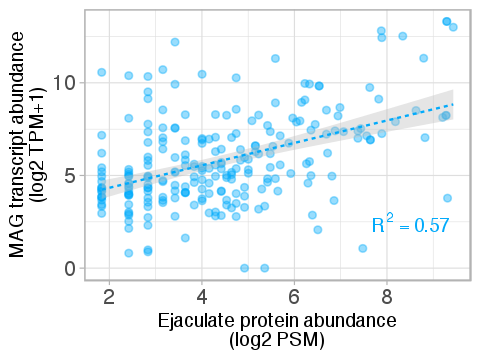

In [178]:
# MAG_label = data.frame(x = 8.5, y = -2.5, label = corr_eqn(ejaculotome_assign$Semen_total_normalized_PSM, ejaculotome_assign$virMAG))
SFP_label = data.frame(x = 8.5, y = 2.5, label = corr_eqn(filter(ejaculotome_assign, semen.only == 1)$Semen_total_normalized_PSM, filter(ejaculotome_assign, semen.only == 1)$virMAG))

options(repr.plot.width = 4, repr.plot.height = 3)
# pdf("Figures/MAG_semenOnly_mRNA_vs_APEX.pdf", width = 4, height = 2.5)
ggplot(filter(ejaculotome_assign, semen.only == 1), aes(log2(Semen_total_normalized_PSM), log2(virMAG+1))) + 
geom_point(alpha = 0.4, colour = "#01aafb") + 
# geom_point(data = filter(ejaculotome_assign, semen.only == 1), colour = "#0277dd", alpha = 0.4) +
labs(x = "Ejaculate protein abundance\n(log2 PSM)", y = "MAG transcript abundance\n(log2 TPM+1)") +
geom_smooth(colour = "#01aafb", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") +
# geom_smooth(data = filter(ejaculotome_assign, semen.only == 1),colour = "#0277dd", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
# geom_text(data = MAG_label, aes(x = x, y = y, label = paste(label)), colour = "#6f4700", parse = TRUE, fontface = "italic") +
geom_text(data = SFP_label, aes(x = x, y = y, label = paste(label)), colour = "#01aafb", parse = TRUE, fontface = "italic") +
# geom_text_repel(data = subset(ejaculotome_assign, Degner_classification == "SFP" & virMAG == 0 & gene_ID %in% SFPs_geneID), aes(log2(Semen_total_normalized_PSM), log2(virMAG), label = gene_ID))
theme_light() +
# coord_flip() +
theme(axis.text = element_text(size = 12))
# dev.off()

Let's run an F-test to see if this fit is significant:

In [179]:
semenonlyVPM_by_magTPM.lm = lm(Semen_total_normalized_PSM ~ virMAG, data=filter(ejaculotome_assign, semen.only == 1))
summary(semenonlyVPM_by_magTPM.lm)

# semenVPM_by_magTPM.lm = lm(Semen_total_normalized_PSM ~ virMAG, ejaculotome_assign)
# summary(semenVPM_by_magTPM.lm)


Call:
lm(formula = Semen_total_normalized_PSM ~ virMAG, data = filter(ejaculotome_assign, 
    semen.only == 1))

Residuals:
    Min      1Q  Median      3Q     Max 
-274.87  -36.44  -27.04   -3.09  592.77 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 41.036265   6.848706   5.992 7.86e-09 ***
virMAG       0.052069   0.004957  10.505  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 100.7 on 232 degrees of freedom
  (177 observations deleted due to missingness)
Multiple R-squared:  0.3223,	Adjusted R-squared:  0.3194 
F-statistic: 110.4 on 1 and 232 DF,  p-value: < 2.2e-16


Warning message:
“Removed 690 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 690 rows containing missing values (geom_point).”

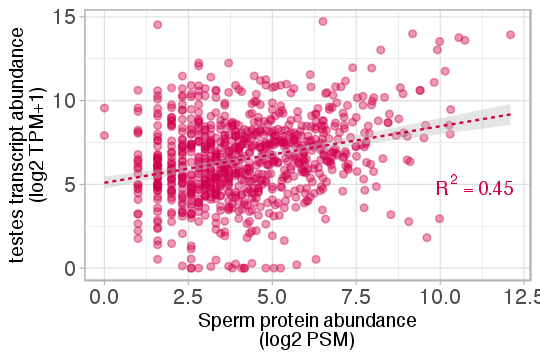

In [180]:
testes_label = data.frame(x = 11, y = 5, label = corr_eqn(ejaculotome_assign$sperm_combined_spectra, ejaculotome_assign$testes))
# spermProts_label = data.frame(x = 2.5, y = 12, label = corr_eqn(filter(ejaculotome_assign, sperm.only == 1)$sperm_combined_spectra, filter(ejaculotome_assign, sperm.only == 1)$testes))

options(repr.plot.width = 4.5, repr.plot.height = 3)
# pdf("Figures/testes_spermOnly_mRNA_vs_APEX.pdf", width = 4.2, height = 2.5)
ggplot(ejaculotome_assign, aes(log2(sperm_combined_spectra), log2(testes+1))) + 
geom_point(alpha = 0.4, colour = "#d1004b") + 
# geom_point(data = filter(ejaculotome_assign, sperm.only == 1), colour = "#e7354b", alpha = 0.3) +
labs(x = "Sperm protein abundance\n(log2 PSM)", y = "testes transcript abundance\n(log2 TPM+1)") +
geom_smooth(colour = "#d1004b", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") +
# geom_smooth(data = filter(ejaculotome_assign, sperm.only == 1),colour = "#e7354b", fill = "gray", method = 'lm', size = 0.5, linetype = "dashed") + 
geom_text(data = testes_label, aes(x = x, y = y, label = paste(label)), colour = "#d1004b", parse = TRUE, fontface = "italic") +
# geom_text(data = spermProts_label, aes(x = x, y eth= y, label = paste(label)), colour = "#e7354b", parse = TRUE, fontface = "italic") +
# geom_text_repel(data = subset(ejaculotome_assign, Degner_classification == "Sperm protein" & testes == 0 & gene_ID %in% SpermProts_geneID), aes(log2(sperm_combined_spectra), log2(testes), label = gene_ID)) +
theme_light() +
# coord_flip() +
theme(axis.text = element_text(size = 12))
# dev.off()

Let's run an F-test to see if this fit is significant:

In [181]:
# spermonlyVPM_by_magTPM.lm = lm(sperm_combined_spectra ~ testes, data=filter(ejaculotome_assign, sperm.only == 1))
# summary(spermonlyVPM_by_magTPM.lm)

spermVPM_by_magTPM.lm = lm(sperm_combined_spectra ~ testes, ejaculotome_assign)
summary(spermVPM_by_magTPM.lm)


Call:
lm(formula = sperm_combined_spectra ~ testes, data = ejaculotome_assign)

Residuals:
    Min      1Q  Median      3Q     Max 
-1460.9   -38.8   -31.7    -7.2  3465.6 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 39.837592   6.616817   6.021 2.56e-09 ***
testes       0.055876   0.003735  14.961  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 189.6 on 870 degrees of freedom
  (690 observations deleted due to missingness)
Multiple R-squared:  0.2046,	Adjusted R-squared:  0.2037 
F-statistic: 223.8 on 1 and 870 DF,  p-value: < 2.2e-16


## Chromosome distribution

We'll subset the gene features for annotated genes, get the mean coordinate value, and include only genes with a single coordinate value:

In [182]:
annot.features = unique(subset(gene.features, select = c("contig", "min", "max", "ref_gene_id", "gene_id")))
annot.features$mean_coord = (annot.features$max + annot.features$min)/2
annot.features = as.data.frame(subset(annot.features, grepl("AAEL", ref_gene_id)))
annot.features = setDT(annot.features)[, .SD[which.max(mean_coord)], by=ref_gene_id]

FIrst we'll calculate the total number of genes on the 3 major chromosomes:

In [183]:
TotalGeneNumber = as.data.frame(table(factor(subset(annot.features, !grepl("NIGP", annot.features$contig))$contig)))
colnames(TotalGeneNumber) = c("chromosome", "All genes")
total_genes = nrow(annot.features)
TotalGeneNumber$proportion = (TotalGeneNumber$`All genes`/total_genes)

Make several data frames with testes and MAG data for each category of tissue-biased genes and sperm/semen proteomes: 

In [184]:
## SFPs
genomeNumber.SFPs = length(SFPs_geneID)
chromNumber.SFPs=as.data.frame(table(factor(subset(annot.features, gene_id %in% SFPs_mstrg & !grepl("NIGP", contig))$contig)))
colnames(chromNumber.SFPs) = c("chromosome", "Observed_biased_genes")
chromNumber.SFPs$tissue = "MAG"
chromNumber.SFPs = merge(TotalGeneNumber, chromNumber.SFPs)
chromNumber.SFPs$`Expected genes` = genomeNumber.SFPs*chromNumber.SFPs$proportion
chromNumber.SFPs$`obs.exp` = chromNumber.SFPs$Observed_biased_genes/chromNumber.SFPs$`Expected genes`
chromNumber.SFPs$`category` = "SFPs"

## Sperm proteins
genomeNumber.SpermProts = length(SpermProts_geneID)
chromNumber.SpermProts=as.data.frame(table(factor(subset(annot.features, gene_id %in% SpermProts_mstrg & !grepl("NIGP", contig))$contig)))
colnames(chromNumber.SpermProts) = c("chromosome", "Observed_biased_genes")
chromNumber.SpermProts$tissue = "Testes"
chromNumber.SpermProts = merge(TotalGeneNumber, chromNumber.SpermProts)
chromNumber.SpermProts$`Expected genes` = genomeNumber.SpermProts*chromNumber.SpermProts$proportion
chromNumber.SpermProts$`obs.exp` = chromNumber.SpermProts$Observed_biased_genes/chromNumber.SpermProts$`Expected genes`
chromNumber.SpermProts$`category` = "Sperm proteins"

Now for gene with ≥4-fold bias in MAG and testes:

In [185]:
# MAG
genomeNumber.MAG.DEup = length(MAG.DEup.list.CDS)
chromNumber.MAG.DEup=as.data.frame(table(factor(subset(annot.features, ref_gene_id %in% MAG.DEup.list.vb & !grepl("NIGP", contig))$contig)))
colnames(chromNumber.MAG.DEup) = c("chromosome", "Observed_biased_genes")
chromNumber.MAG.DEup$tissue = "MAG"
chromNumber.MAG.DEup = merge(TotalGeneNumber, chromNumber.MAG.DEup)
chromNumber.MAG.DEup$`Expected genes` = genomeNumber.MAG.DEup*chromNumber.MAG.DEup$proportion
chromNumber.MAG.DEup$`obs.exp` = chromNumber.MAG.DEup$Observed_biased_genes/chromNumber.MAG.DEup$`Expected genes`
chromNumber.MAG.DEup$`category` = ">2-fold MAG-biased"

## testes
genomeNumber.testes.DEup = length(testes.DEup.list.vb)
chromNumber.testes.DEup=as.data.frame(table(factor(subset(annot.features, ref_gene_id %in% testes.DEup.list.vb & !grepl("NIGP", contig))$contig)))
colnames(chromNumber.testes.DEup) = c("chromosome", "Observed_biased_genes")
chromNumber.testes.DEup$tissue = "Testes"
chromNumber.testes.DEup = merge(TotalGeneNumber, chromNumber.testes.DEup)
chromNumber.testes.DEup$`Expected genes` = genomeNumber.testes.DEup*chromNumber.testes.DEup$proportion
chromNumber.testes.DEup$`obs.exp` = chromNumber.testes.DEup$Observed_biased_genes/chromNumber.testes.DEup$`Expected genes`
chromNumber.testes.DEup$`category` = ">2-fold testes-biased"

Then combine them:

In [186]:
tissue_biased.numbers = rbind(chromNumber.SFPs, chromNumber.MAG.DEup, chromNumber.SpermProts, chromNumber.testes.DEup)
tissue_biased.numbers$`category` = factor(tissue_biased.numbers$`category`, levels = c("SFPs", ">2-fold MAG-biased", "Sperm proteins", ">2-fold testes-biased"))

Test for significant differences from expectation using a Chi square test:

In [187]:
tissue_biased.numbers$ChiSq = ((tissue_biased.numbers$Observed_biased_genes-tissue_biased.numbers$`Expected genes`)^2)/tissue_biased.numbers$`Expected genes`

tissue_biased.numbers$pval = 1-(pchisq(tissue_biased.numbers$ChiSq, df = 1))
tissue_biased.numbers$FDR = tissue_biased.numbers$pval*nrow(tissue_biased.numbers)

tissue_biased.numbers$sigLabel = NULL
tissue_biased.numbers$sigLabel = ifelse(tissue_biased.numbers$FDR < 0.05 & tissue_biased.numbers$FDR > 0.01, "*", ifelse(tissue_biased.numbers$FDR < 0.01 & tissue_biased.numbers$FDR > 0.001, "**", ifelse(tissue_biased.numbers$FDR < 0.001, "***", "")))

In [188]:
write.table(tissue_biased.numbers, "Results/Supplementary_materials/Table_S5.chromEnrichment.txt", quote = F, sep = "\t", row.names = F)

A barplot to visualize the results:

In [189]:
tissue_biased.numbers

chromosome All genes proportion Observed_biased_genes tissue Expected genes
1  1          4429      0.22468547  62                   MAG     39.769328    
2  2          7168      0.36363636  69                   MAG     64.363636    
3  3          6484      0.32893669  63                   MAG     58.221794    
4  1          4429      0.22468547 173                   MAG    159.751370    
5  2          7168      0.36363636 258                   MAG    258.545455    
6  3          6484      0.32893669 255                   MAG    233.873985    
7  MT           38      0.00192776   1                   MAG      1.370637    
8  1          4429      0.22468547 226                   Testes 195.476360    
9  2          7168      0.36363636 377                   Testes 316.363636    
10 3          6484      0.32893669 311                   Testes 286.174919    
11 1          4429      0.22468547 439                   Testes 433.193588    
12 2          7168      0.36363636 746                   Testes 701.090909    
13 3          6484      0.32893669 670                   Testes 634.189935    
   obs.exp   category              ChiSq        pval         FDR         
1  1.5589904 SFPs                  12.426731448 0.0004232320  0.005502016
2  1.0720339 SFPs                   0.333975347 0.5633275832  7.323258581
3  1.0820690 SFPs                   0.392142747 0.5311752279  6.905277962
4  1.0829328 >2-fold MAG-biased     1.098746161 0.2945414343  3.829038646
5  0.9978903 >2-fold MAG-biased     0.001150748 0.9729388103 12.648204534
6  1.0903308 >2-fold MAG-biased     1.908328934 0.1671490015  2.172937020
7  0.7295877 >2-fold MAG-biased     0.100224858 0.7515599628  9.770279517
8  1.1561500 Sperm proteins         4.766267525 0.0290226815  0.377294860
9  1.1916667 Sperm proteins        11.621969697 0.0006517734  0.008473054
10 1.0867479 Sperm proteins         2.153524346 0.1422430441  1.849159574
11 1.0134037 >2-fold testes-biased  0.077827616 0.7802632327 10.143422026
12 1.0640560 >2-fold testes-biased  2.876697473 0.0898701665  1.168312165
13 1.0564658 >2-fold testes-biased  2.022045258 0.1550302056  2.015392673
   sigLabel
1  **      
2          
3          
4          
5          
6          
7          
8          
9  **      
10         
11         
12         
13

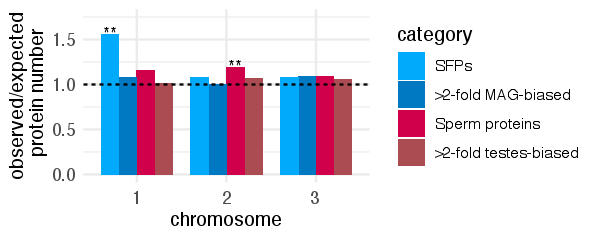

In [190]:
options(repr.plot.width = 5, repr.plot.height = 2)
# pdf("Manuscript_Figures/chromosome_distribution.pdf", width = 5, height = 2)
(w_chr = ggplot(subset(tissue_biased.numbers, chromosome != "MT"), aes(chromosome, obs.exp, fill = `category`)) +
#     facet_wrap(~tissue) +
    geom_bar(position=position_dodge(), stat="identity", width = 0.8) +
    geom_hline(yintercept = 1, linetype = "dashed") +
    scale_fill_manual(values = c("#01aafb", "#0078c2","#d1004b", "#ab4b52")) +
    ylab("observed/expected\n protein number") +
    geom_text(aes(label = sigLabel), size = 4, colour = "black", position=position_dodge(width = 0.8)) +
    scale_y_continuous(limits = c(0,1.75)) +
    theme_minimal() +
    theme(axis.text=element_text(size = 10)))
# dev.off()

A recent paper looked at genetic differentiation amoung _aegypti_ populations and found a chunk of elevated Fst in the middle of chromsome 1. We should run the analyses above for this region, which is composed of a larger block (123Mb) from 87Mbp to 210Mbp, and a smaller block (63Mb) that is nested within the larger one from 148Mbp to 210Mbp.

First We output the proportion of all genes in that window

#### DETOUR

In [191]:
MAG.DE.and.coordinates = merge(lrt.MAG.tTags.table, annot.features, by.x = "GeneID", by.y = "gene_id", all.x = TRUE)

In [192]:
reg120 = data.frame(xmin=90e6, xmax=211e6, ymin=0, ymax = 20, contig = "1")
reg63 = data.frame(xmin=147e6, xmax=211e6, ymin=0, ymax = 20, contig = "1")

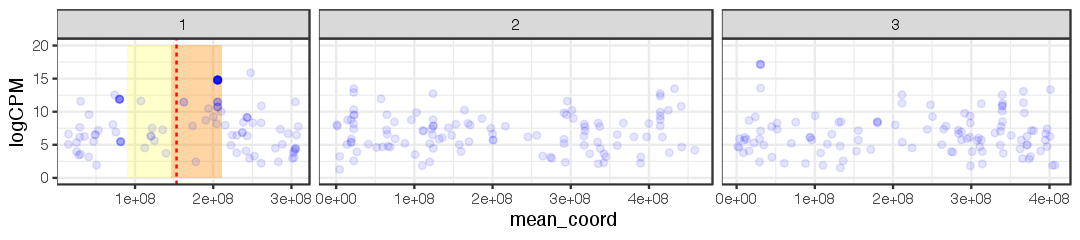

In [193]:
options(repr.plot.width = 9, repr.plot.height = 2)
# pdf("Figures/SuperGene_all_chromosomes.pdf", width = 9, height = 2)
ggplot(filter(MAG.DE.and.coordinates, VB_ID %in% MAG.extreme.list.vb & !grepl("NIGP", contig) & contig != "MT" & VB_ID != "NA"), aes(mean_coord, logCPM)) + 
    facet_grid(.~contig, scales = "free_x", space = "free_x") +
    geom_rect(data=reg63, aes(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax), alpha=0.2, inherit.aes = FALSE, fill = "red") +
    geom_rect(data=reg120, aes(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax), alpha=0.2, inherit.aes = FALSE, fill = "yellow") +
    geom_point(alpha = 0.1, colour = "blue") +
    geom_vline(data = filter(MAG.DE.and.coordinates, contig == "1"), aes(xintercept = 152667416), linetype = "dashed", colour = "red") +
#     scale_x_continuous(limits = c(205e6, 206e6)) +
    theme_bw()
# dev.off()

Warning message:
“Removed 65 rows containing missing values (geom_point).”

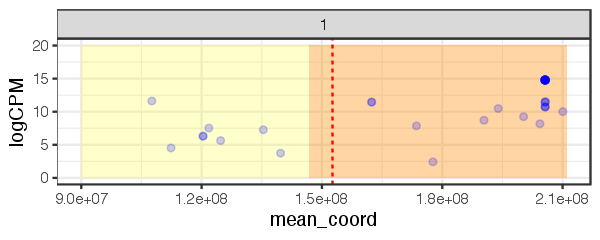

In [194]:
options(repr.plot.width = 5, repr.plot.height = 2)
# pdf("Figures/SuperGene_C1_123Mb_region.pdf", width = 5, height = 2)
ggplot(filter(MAG.DE.and.coordinates, VB_ID %in% MAG.extreme.list.vb & !grepl("NIGP", contig) & contig == "1"), aes(mean_coord, logCPM)) + 
    facet_grid(.~contig, scales = "free_x", space = "free_x") +
    geom_rect(data=reg63, aes(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax), alpha=0.2, inherit.aes = FALSE, fill = "red") +
    geom_rect(data=reg120, aes(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax), alpha=0.2, inherit.aes = FALSE, fill = "yellow") +
    geom_point(alpha = 0.2, colour = "blue") +
    geom_vline(data = filter(MAG.DE.and.coordinates, contig == "1"), aes(xintercept = 152667416), linetype = "dashed", colour = "red") +
    scale_x_continuous(limits = c(90e6, 211e6)) +
    theme_bw()
# dev.off()

In [195]:
tmpSUP.mstrg = unique(filter(annot.features, mean_coord > 205546814 & mean_coord < 205746813 & contig == "1")$gene_id)
tmpSUP.vb = unique(filter(annot.features, ref_gene_id %in% MAG.extreme.list.vb & mean_coord > 147e6 & mean_coord < 211e6 & contig == "1")$gene_id)

In [196]:
vdMAG.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% as.character(tmpSUP.mstrg))
# vdMAG.meanTPM = subset(vdMAG.meanTPM, select = c("virMAG", "depMAG", "testes", "Fe_RT_virgin", "Fe_RT_0hpm", "Fe_RT_6hpm", "Fe_RT_24hpm"))

Create the heatmap object for plotting (this is long and tedious, but should be treated as a code chunk):

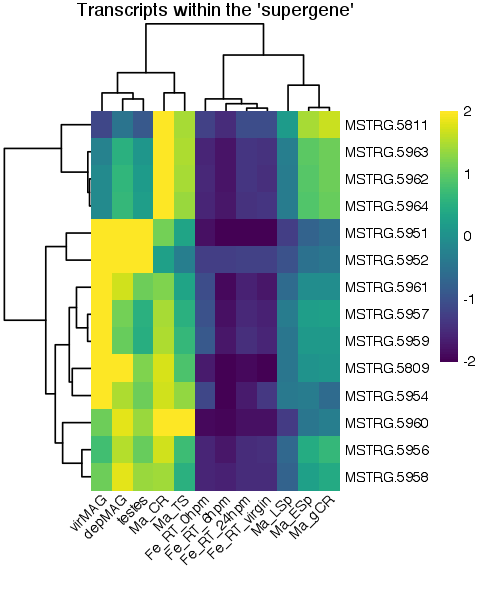

In [197]:
options(repr.plot.width = 4, repr.plot.height = 5)
data = log2(vdMAG.meanTPM+1)
data = t(scale(t(data), scale=F))
data[data < -2] = -2
data[data > 2] = 2

pheatmap(
  mat               = data,
  color             = viridis(100),
#   breaks            = mat_breaks,
  border_color      = NA,
#   labels_col        = c("carcass", "head", "ovaries", "rep. tract"),
  show_colnames     = TRUE,
#   show_rownames     = FALSE,
#   annotation_row    = virgin.factor.labeling,
#   annotation_colors = mat_colors,
  drop_levels       = TRUE,
#   annotation_names_row = F,
  main              = "Transcripts within the 'supergene'",
#   filename          = "Figures/supergene_transcripts_heatmap.pdf",
#   width             = 4, 
#   height            = 5,
  fontsize          = 8    
)

In [198]:
region_C1_123Mb_geneNumber = as.data.frame(table(factor(filter(annot.features, !grepl("NIGP", contig) & contig == 1 & min > 87e6 & max < 211e6)$contig)))
colnames(region_C1_123Mb_geneNumber) = c("chromosome", "total_genes")
region_C1_123Mb_geneNumber$region = "123Mb"
region_C1_123Mb_geneNumber$proportion = (region_C1_123Mb_geneNumber$total_genes/total_genes)

region_C1_63Mb_geneNumber = as.data.frame(table(factor(filter(annot.features, !grepl("NIGP", contig) & contig == 1 & min > 148e6 & max < 210e6)$contig)))
colnames(region_C1_63Mb_geneNumber) = c("chromosome", "total_genes")
region_C1_63Mb_geneNumber$region = "63Mb"
region_C1_63Mb_geneNumber$proportion = (region_C1_63Mb_geneNumber$total_genes/total_genes)

region_C1_20Mb_geneNumber = as.data.frame(table(factor(filter(annot.features, !grepl("NIGP", contig) & contig == 1 & min > 190e6 & max < 210e6)$contig)))
colnames(region_C1_20Mb_geneNumber) = c("chromosome", "total_genes")
region_C1_20Mb_geneNumber$region = "20Mb"
region_C1_20Mb_geneNumber$proportion = (region_C1_20Mb_geneNumber$total_genes/total_genes)

region_C1_geneNumbers = rbind(region_C1_123Mb_geneNumber, region_C1_63Mb_geneNumber, region_C1_20Mb_geneNumber)

Now we'll look at enrichment of SFPs and sperm proteins:

In [199]:
## SFPs
chromNumber.SFPs.123Mb=as.data.frame(table(factor(filter(annot.features, ref_gene_id %in% SFPs_geneID  & !grepl("NIGP", contig) & contig == 1 & min > 87e6 & max < 211e6)$contig)))
chromNumber.SFPs.123Mb$region = "123Mb"

chromNumber.SFPs.63Mb=as.data.frame(table(factor(filter(annot.features, ref_gene_id %in% SFPs_geneID & !grepl("NIGP", contig) & contig == 1 & min > 148e6 & max < 210e6)$contig)))
chromNumber.SFPs.63Mb$region = "63Mb"

chromNumber.SFPs.20Mb=as.data.frame(table(factor(filter(annot.features, ref_gene_id %in% SFPs_geneID  & !grepl("NIGP", contig) & contig == 1 & min > 190e6 & max < 211e6)$contig)))
chromNumber.SFPs.20Mb$region = "20Mb"

chromNumber.SFPs.C1 = rbind(chromNumber.SFPs.123Mb, chromNumber.SFPs.63Mb, chromNumber.SFPs.20Mb)
colnames(chromNumber.SFPs.C1) = c("chromosome", "Observed_biased_genes", "region")
chromNumber.SFPs.C1$tissue = "MAG"
chromNumber.SFPs.C1 = merge(region_C1_geneNumbers, chromNumber.SFPs.C1, by = "region")
chromNumber.SFPs.C1$expected_genes = genomeNumber.SFPs*chromNumber.SFPs.C1$proportion
chromNumber.SFPs.C1$obs.exp = chromNumber.SFPs.C1$Observed_biased_genes/chromNumber.SFPs.C1$expected_genes
chromNumber.SFPs.C1$`Gene category` = "SFPs"

## SpermProts
chromNumber.SpermProts.123Mb=as.data.frame(table(factor(filter(annot.features, (ref_gene_id %in% SpermProts_geneID) & !grepl("NIGP", contig) & contig == 1 & min > 87e6 & max < 211e6)$contig)))
chromNumber.SpermProts.123Mb$region = "123Mb"

chromNumber.SpermProts.63Mb=as.data.frame(table(factor(filter(annot.features, (ref_gene_id %in% SpermProts_geneID) & !grepl("NIGP", contig) & contig == 1 & min > 148e6 & max < 210e6)$contig)))
chromNumber.SpermProts.63Mb$region = "63Mb"

chromNumber.SpermProts.20Mb=as.data.frame(table(factor(filter(annot.features, (ref_gene_id %in% SpermProts_geneID) & !grepl("NIGP", contig) & contig == 1 & min > 190e6 & max < 210e6)$contig)))
chromNumber.SpermProts.20Mb$region = "20Mb"

chromNumber.SpermProts.C1 = rbind(chromNumber.SpermProts.123Mb, chromNumber.SpermProts.63Mb, chromNumber.SpermProts.20Mb)
colnames(chromNumber.SpermProts.C1) = c("chromosome", "Observed_biased_genes", "region")
chromNumber.SpermProts.C1$tissue = "testes"
chromNumber.SpermProts.C1 = merge(region_C1_geneNumbers, chromNumber.SpermProts.C1, by = "region")
chromNumber.SpermProts.C1$expected_genes = genomeNumber.SpermProts*chromNumber.SpermProts.C1$proportion
chromNumber.SpermProts.C1$obs.exp = chromNumber.SpermProts.C1$Observed_biased_genes/chromNumber.SpermProts.C1$expected_genes
chromNumber.SpermProts.C1$`Gene category` = "Sperm proteins"

In [200]:
chromNumber.SpermProts.C1
chromNumber.SFPs.C1

region chromosome.x total_genes proportion chromosome.y Observed_biased_genes
1 123Mb  1            1795        0.09106128 1            82                   
2 20Mb   1             412        0.02090097 1            15                   
3 63Mb   1             952        0.04829545 1            29                   
  tissue expected_genes obs.exp   Gene category 
1 testes 79.22332       1.0350488 Sperm proteins
2 testes 18.18385       0.8249079 Sperm proteins
3 testes 42.01705       0.6901961 Sperm proteins

region chromosome.x total_genes proportion chromosome.y Observed_biased_genes
1 123Mb  1            1795        0.09106128 1            15                   
2 20Mb   1             412        0.02090097 1             2                   
3 63Mb   1             952        0.04829545 1             7                   
  tissue expected_genes obs.exp   Gene category
1 MAG    16.117847      0.9306454 SFPs         
2 MAG     3.699472      0.5406176 SFPs         
3 MAG     8.548295      0.8188767 SFPs

Now for gene with ≥4-fold bias in MAG and testes:

In [201]:
# ## MAGextreme
# chromNumber.MAGextreme.123Mb=as.data.frame(table(factor(filter(annot.features, (ref_gene_id %in% MAG.extreme.list.vb) & !grepl("NIGP", contig) & contig == 1 & min > 87e6 & max < 211e6)$contig)))
# chromNumber.MAGextreme.123Mb$region = "123Mb"

# chromNumber.MAGextreme.63Mb=as.data.frame(table(factor(filter(annot.features, (ref_gene_id %in% MAG.extreme.list.vb) & !grepl("NIGP", contig) & contig == 1 & min > 148e6 & max < 210e6)$contig)))
# chromNumber.MAGextreme.63Mb$region = "63Mb"

# chromNumber.MAGextreme.20Mb=as.data.frame(table(factor(filter(annot.features, (ref_gene_id %in% MAG.extreme.list.vb) & !grepl("NIGP", contig) & contig == 1 & min > 190e6 & max < 210e6)$contig)))
# chromNumber.MAGextreme.20Mb$region = "20Mb"

# chromNumber.MAGextreme.C1 = rbind(chromNumber.MAGextreme.123Mb, chromNumber.MAGextreme.63Mb, chromNumber.MAGextreme.20Mb)
# colnames(chromNumber.MAGextreme.C1) = c("chromosome", "Observed_biased_genes", "region")
# chromNumber.MAGextreme.C1$tissue = "MAG"
# chromNumber.MAGextreme.C1 = merge(region_C1_geneNumbers, chromNumber.MAGextreme.C1, by = "region")
# chromNumber.MAGextreme.C1$expected_genes = genomeNumber.MAG.extreme*chromNumber.MAGextreme.C1$proportion
# chromNumber.MAGextreme.C1$obs.exp = chromNumber.MAGextreme.C1$Observed_biased_genes/chromNumber.MAGextreme.C1$expected_genes
# chromNumber.MAGextreme.C1$`Gene category` = ">4-fold MAG-biased"

# ## testesExtreme
# chromNumber.testesExtreme.123Mb=as.data.frame(table(factor(filter(annot.features, (ref_gene_id %in% testes.extreme.list.vb) & !grepl("NIGP", contig) & contig == 1 & min > 87e6 & max < 211e6)$contig)))
# chromNumber.testesExtreme.123Mb$region = "123Mb"

# chromNumber.testesExtreme.63Mb=as.data.frame(table(factor(filter(annot.features, (ref_gene_id %in% testes.extreme.list.vb) & !grepl("NIGP", contig) & contig == 1 & min > 148e6 & max < 210e6)$contig)))
# chromNumber.testesExtreme.63Mb$region = "63Mb"

# chromNumber.testesExtreme.20Mb=as.data.frame(table(factor(filter(annot.features, (ref_gene_id %in% testes.extreme.list.vb) & !grepl("NIGP", contig) & contig == 1 & min > 190e6 & max < 210e6)$contig)))
# chromNumber.testesExtreme.20Mb$region = "20Mb"

# chromNumber.testesExtreme.C1 = rbind(chromNumber.testesExtreme.123Mb, chromNumber.testesExtreme.63Mb, chromNumber.testesExtreme.20Mb)
# colnames(chromNumber.testesExtreme.C1) = c("chromosome", "Observed_biased_genes", "region")
# chromNumber.testesExtreme.C1$tissue = "testes"
# chromNumber.testesExtreme.C1 = merge(region_C1_geneNumbers, chromNumber.testesExtreme.C1, by = "region")
# chromNumber.testesExtreme.C1$expected_genes = genomeNumber.testes.extreme*chromNumber.testesExtreme.C1$proportion
# chromNumber.testesExtreme.C1$obs.exp = chromNumber.testesExtreme.C1$Observed_biased_genes/chromNumber.testesExtreme.C1$expected_genes
# chromNumber.testesExtreme.C1$`Gene category` = ">4-fold testes-biased"

### Then combine them:

In [202]:
# tissue_biased.numbers.C1 = rbind(chromNumber.MAGextreme.C1, chromNumber.testesExtreme.C1, chromNumber.SFPs.C1, chromNumber.SpermProts.C1)
# tissue_biased.numbers.C1$`Gene category` = factor(tissue_biased.numbers.C1$`Gene category`, levels = c("SFPs", ">4-fold MAG-biased","Sperm proteins", ">4-fold testes-biased"))
# tissue_biased.numbers.C1$region = factor(tissue_biased.numbers.C1$region, levels = c("123Mb", "63Mb","20Mb"))

Test for significant differences from expectation using a Chi square test:

In [203]:
# tissue_biased.numbers.C1$ChiSq = ((tissue_biased.numbers.C1$Observed_biased_genes-tissue_biased.numbers.C1$expected_genes)^2)/tissue_biased.numbers.C1$expected_genes

# tissue_biased.numbers.C1$pval = 1-(pchisq(tissue_biased.numbers.C1$ChiSq, df = 1))
# tissue_biased.numbers.C1$FDR = tissue_biased.numbers.C1$pval*nrow(tissue_biased.numbers.C1)

# tissue_biased.numbers.C1$sigLabel = NULL
# tissue_biased.numbers.C1$sigLabel = ifelse(tissue_biased.numbers.C1$FDR < 0.05 & tissue_biased.numbers.C1$FDR > 0.01, "*", ifelse(tissue_biased.numbers.C1$FDR < 0.01 & tissue_biased.numbers.C1$FDR > 0.001, "**", ifelse(tissue_biased.numbers.C1$FDR < 0.001, "***", "")))

In [204]:
# tissue_biased.numbers.C1

A barplot to visualize the results:

In [205]:
# options(repr.plot.width = 5, repr.plot.height = 2)
# # pdf("Manuscript_Figures/Nix_region_distribution.pdf", width = 5, height = 2)
# (region = ggplot(tissue_biased.numbers.C1, aes(region, obs.exp, fill = `Gene category`)) +
# #     facet_wrap(~tissue) +
#     geom_bar(position=position_dodge(), stat="identity", width = 0.8) +
#     geom_hline(yintercept = 1, linetype = "dashed") +
#     scale_fill_manual(values = c("#01aafb", "#0078c2","#d1004b", "#ab4b52")) +
#     ylab("observed/expected\n gene number") +
#     geom_text(aes(label = sigLabel), size = 4, colour = "black", position=position_dodge(width = 0.8)) +
# #     scale_y_continuous(limits = c(0,2.5)) +
#     theme_minimal() +
#     theme(axis.text=element_text(size = 10)))
# # dev.off()

### Analysis of orthologous sperm and SFP proteomes:

We ran an extensive OrthoDB search against several species:

In [206]:
orthoDB = read.csv(file = "proteomics/ortho_aedes1_2_ids", header = T, sep = "\t")

#### _D. melanogaster_:

_D. melanogaster_ has the best characterized SFPs and sperm proteins. We'll load those as follows:

In [207]:
mel_sperm.I = read.csv("proteomics/Other_species_proteomes/DmSP-II.txt", header = T, sep = "\t")
head(mel_sperm.I, n = 2)
mel_sperm.II = read.csv("proteomics/Other_species_proteomes/DmSP-III.txt", header = T, sep = "\t")
head(mel_sperm.II, n = 2)
mel_SFPs = read.csv("proteomics/Other_species_proteomes/ACPlist.Findlay.20130301.txt", header = T, sep = "\t")
head(mel_SFPs, n = 2)

FBgn_ID     CG_ID   gene_description          gene_symbol
1 FBgn0001281 CG7931  janus B                   janB       
2 FBgn0029501 CG13580 Caldesmon-related protein Crtp       
  current_study_overlap proteome_overlap       
1 Double (1,2)          Current Study and DmSPI
2 Double (1,2)          Current Study and DmSPI

FBgn_ID    
1 FBgn0000042
2 FBgn0000043

Submitted_Name FBgn_ID     Symbol 
1 Acp24A4        FBgn0051779 Acp24A4
2 Acp26Aa        FBgn0002855 Acp26Aa

There's an automated gene summaries' table for _D. melanogaster_ that we can use:

In [208]:
mel_summary = read.csv("proteomics/Other_species_proteomes/automated_gene_summaries.tsv", header = T, sep = "\t")

We're also going to compare expression profiles of orthologs. For that, we can use the expression atlas produced by modENCODE. Load it here:

In [209]:
mel_modENCODE = read.csv("proteomics/Other_species_proteomes/gene_rpkm_report_fb_2018_02_subset2.tsv", header = T, sep = "\t")
mel_modENCODE_subset = subset(mel_modENCODE, select = c("FBgn_ID", "RNASource_name", "RPKM_value"))
mel_modENCODE_matrix = cast(mel_modENCODE_subset, FBgn_ID~RNASource_name, value = "RPKM_value")
mel_modENCODE_matrix2 <- mel_modENCODE_matrix[,-1]
rownames(mel_modENCODE_matrix2) <- mel_modENCODE_matrix[,1]

We'll subset the orthoDB database to only include the species for which we have sperm and/or SFP proteomes:

In [210]:
rel.orthoDB = subset(orthoDB, select = c("Aedes.aegypti", "Aedes.albopictus","Drosophila.melanogaster", "Manduca.sexta", "Apis.mellifera", "Mus.musculus"))
head(rel.orthoDB, n = 2)

Aedes.aegypti Aedes.albopictus    Drosophila.melanogaster Manduca.sexta
1 LOC5580049    109405621;109416243 FBgn0000152                          
2 LOC5579046    109401550;109402893 FBgn0036545             Msex2.01676  
  Apis.mellifera Mus.musculus
1                102566      
2 409614         69836;66350

We'll need to disaggregate the _aegypti_ gene ID column first:

In [211]:
rel.orthoDB = rel.orthoDB %>% mutate(Aedes.aegypti = strsplit(as.character(Aedes.aegypti), ";")) %>% unnest(Aedes.aegypti)
head(rel.orthoDB)

Aedes.albopictus                        Drosophila.melanogaster Manduca.sexta
1 109405621;109416243                     FBgn0000152                          
2 109401550;109402893                     FBgn0036545             Msex2.01676  
3 109411338;109427062;109427063;109411352                                      
4 109622201;109408641                     FBgn0016983             Msex2.12286  
5 109622201;109408641                     FBgn0016983             Msex2.12286  
6 109621286;109422858                     FBgn0261934                          
  Apis.mellifera Mus.musculus Aedes.aegypti
1                102566       LOC5580049   
2 409614         69836;66350  LOC5579046   
3                             LOC5569834   
4 409408         67459        LOC110677712 
5 409408         67459        LOC5563554   
6                             LOC23687995

Aegypti databse size:

In [212]:
length(unique(genbank_proteins$gene_name))

[1] 14613

Total represented as orthologs with _D. emlanogaster_:

In [213]:
head(filter(rel.orthoDB, grepl("FBgn", Drosophila.melanogaster)))

Aedes.albopictus    Drosophila.melanogaster Manduca.sexta Apis.mellifera
1 109405621;109416243 FBgn0000152                                         
2 109401550;109402893 FBgn0036545             Msex2.01676   409614        
3 109622201;109408641 FBgn0016983             Msex2.12286   409408        
4 109622201;109408641 FBgn0016983             Msex2.12286   409408        
5 109621286;109422858 FBgn0261934                                         
6 109621974;109409008 FBgn0028406             Msex2.07809   100577769     
  Mus.musculus Aedes.aegypti
1 102566       LOC5580049   
2 69836;66350  LOC5579046   
3 67459        LOC110677712 
4 67459        LOC5563554   
5              LOC23687995  
6 13368        LOC5565779

In [214]:
length(unique(filter(rel.orthoDB, grepl("FBgn", Drosophila.melanogaster))$Aedes.aegypti))
length(unique(filter(rel.orthoDB, grepl("1", Aedes.albopictus))$Aedes.aegypti))

[1] 9684

[1] 13316

Percentage of coverage:

In [215]:
(length(unique(filter(rel.orthoDB, grepl("FBgn", Drosophila.melanogaster))$Aedes.aegypti))/length(unique(genbank_proteins$gene_name)))*100

(length(unique(filter(rel.orthoDB, grepl("1", Aedes.albopictus))$Aedes.aegypti))/length(unique(genbank_proteins$gene_name)))*100

[1] 66.26976

[1] 91.12434

We'll a list from the orthology relationship inferred by orthoDB:

In [216]:
mel_gene_orth_to_aegSFPs = filter(rel.orthoDB, (Aedes.aegypti %in% SFPs_locID | Aedes.aegypti %in% SFPs_overlap_locID) & Drosophila.melanogaster != "NA")
nrow(mel_gene_orth_to_aegSFPs)

# need to disaggregate the D. mel column:
mel_gene_orth_to_aegSFPs.tmp = mel_gene_orth_to_aegSFPs %>%  mutate(Drosophila.melanogaster = strsplit(as.character(Drosophila.melanogaster), ";")) %>% 
    unnest(Drosophila.melanogaster)
nrow(mel_gene_orth_to_aegSFPs.tmp)

mel_gene_orth_to_aegSFPs = filter(mel_gene_orth_to_aegSFPs.tmp, Drosophila.melanogaster %in% mel_SFPs$FBgn_ID)$Drosophila.melanogaster
length(mel_gene_orth_to_aegSFPs)

[1] 275

[1] 352

[1] 11

In [217]:
mel_gene_orth_to_aegSpermProtsOnly = filter(rel.orthoDB, Aedes.aegypti %in% SpermProtsOnly_locID & Drosophila.melanogaster != "NA")
nrow(mel_gene_orth_to_aegSpermProtsOnly)

# need to disaggregate the D. mel column:
mel_gene_orth_to_aegSpermProtsOnly.tmp = mel_gene_orth_to_aegSpermProtsOnly %>%  mutate(Drosophila.melanogaster = strsplit(as.character(Drosophila.melanogaster), ";")) %>% 
    unnest(Drosophila.melanogaster)
nrow(mel_gene_orth_to_aegSpermProtsOnly.tmp)

mel_gene_orth_to_aegSpermProtsOnly = filter(mel_gene_orth_to_aegSpermProtsOnly.tmp, Drosophila.melanogaster %in% mel_sperm.II$FBgn_ID)$Drosophila.melanogaster
length(mel_gene_orth_to_aegSpermProtsOnly)

[1] 760

[1] 935

[1] 451

In [218]:
tmpFile = filter(mel_summary, FBgn_ID %in% mel_gene_orth_to_aegSpermProtsOnly)
filter(tmpFile, grepl("dynein", summary))

FBgn_ID    
1  FBgn0011760
2  FBgn0013810
3  FBgn0013811
4  FBgn0013812
5  FBgn0013813
6  FBgn0026141
7  FBgn0034566
8  FBgn0035581
9  FBgn0035799
10 FBgn0036499
11 FBgn0037254
12 FBgn0037276
13 FBgn0037962
14 FBgn0039070
15 FBgn0262123
16 FBgn0263988
17 FBgn0267432
18 FBgn0267433
19 FBgn0283476
   summary                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
1  The gene cut up is referred to in FlyBase by the symbol Dmel\\ctp (CG6998, FBgn0011760). It is a SO0000010:protein_coding_gene from Drosophila melanogaster. It has 4 annotated transcripts and 4 polypeptides (1 unique). Gene sequence location is X:4687800..4702034. It has the cytological map location 4C13-4C14. Protein features are: Dynein light chain superfamily; Dynein light chain, type 1/2; Dynein light chain, type 1/2, conserved site. Its molecular function is described by: ATP-dependent microtubule motor activity, plus-end-directed; protein homodimerization activity; cytoskeletal protein binding; dynein intermediate chain binding; ATPase activity, coupled; protein binding; dynein light intermediate chain binding. It is involved in the biological process described with 18 unique terms, many of which group under: microtubule-based movement; regulation of molecular function; cell cycle process; cellular metabolic process; spermatid nucleus elongation; instar larval or pupal morphogenesis; regulation of neuron maturation; plasma membrane bounded cell projection organization; positive regulation of microtubule motor activity; metabolic process; morphogenesis of an epithelium; establishment of mitotic spindle localization; supramolecular fiber organization. 60 alleles are reported. The phenotypes of these alleles manifest in: egg chamber; embryo; lytic vacuole; dorsal thoracic disc; supramolecular complex; vacuole; tormogen cell; sensory system neuron; embryonic/larval neuroblast; larval segment; bouton; somatodendritic compartment; mechanosensory system; synaptonemal structure; cysti

In [219]:
length(unique(mel_gene_orth_to_aegSFPs.tmp$Aedes.aegypti))
length(unique(mel_gene_orth_to_aegSFPs.tmp$Drosophila.melanogaster))

[1] 249

[1] 337

Output a gene summary of those _D. mel_ SFPs:

In [220]:
mel_gene_orth_to_aegSFPs_summary = filter(mel_summary, FBgn_ID %in% mel_gene_orth_to_aegSFPs)
tmp1 = merge(mel_gene_orth_to_aegSFPs_summary, mel_gene_orth_to_aegSFPs.tmp, by.x = "FBgn_ID", by.y = "Drosophila.melanogaster", all.x = T)
tmp2 = merge(tmp1, proteome_IDs, by.x = "Aedes.aegypti", by.y = "loc_ID")
tmp3 = merge(tmp2, AaegL5_annotation, by.x = "gene_ID", by.y = "gene_id")
(SFP_orths_aeg_mel = subset(tmp3, select = c('gene_ID','Aedes.aegypti','FBgn_ID', 'description','summary')))
SFP_orths_aeg_mel$orthSpec = "Dmel"
SFP_orths_aeg_mel$orthCat = "SFP"

gene_ID    Aedes.aegypti FBgn_ID     description                       
1  AAEL000641 LOC5565441    FBgn0014002 protein disulfide isomerase       
2  AAEL001275 LOC5569604    FBgn0052190 ef-hand protein nucb1             
3  AAEL008607 LOC5570819    FBgn0041180 tep3                              
4  AAEL009239 LOC5571707    FBgn0035042 venom allergen                    
5  AAEL009239 LOC5571707    FBgn0037889 venom allergen                    
6  AAEL009239 LOC5571707    FBgn0260766 venom allergen                    
7  AAEL012064 LOC5575792    FBgn0038198 Niemann-Pick Type C-2%2C putative 
8  AAEL012311 LOC5567092    FBgn0030828 vitellogenin%2C putative          
9  AAEL012827 LOC5576841    FBgn0039562 endoplasmin                       
10 AAEL017263 LOC23687683   FBgn0023529 NA                                
11 AAEL017512 LOC23687932   FBgn0034417 NA                                
   summary                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1  The gene Protein disulfide isomerase is referred to in FlyBase by the symbol Dmel\\Pdi (CG6988, FBgn0014002). It is a SO0000010:protein_coding_gene from Drosophila melanogaster. It has 2 annotated transcripts and 2 polypeptides (1 unique). Gene sequence location is 3L:15137738..15142840. It has the cytological map location 71B5. Protein features are: Disulphide isomerase; Protein disulphide isomerase; Thioredoxin domain; Thioredoxin, conserved site; Thioredoxin-like superfamily. Its molecular function is described by: peptidyl-proline 4-dioxygenase activity; protein disulfide isomerase activity. It is involved in the biological process described with: cell redox homeostasis; response to endoplasmic reticulum stress; protein folding; regulation of oxidative stress-induced intrinsic apoptotic signaling pathway. 17 alleles are reported. No phenotypic data is available. The phenotypic classes of alleles include: lethal; viable; some die during pupal stage; partially lethal - majority die; fertile. Summary of modENCODE Temporal Expression Profile:  Temporal profile ranges from a peak of extremely high expression to a trough of high expression.  Peak expression observed within 06-12 hour embryonic stages.                                                                                                                                                                                                                                                                                                                    
2  The gene NUCB1 is referred to in FlyBase

Do the same with sperm proteins:

In [223]:
mel_gene_orth_to_aegSpermProtsOnly = filter(rel.orthoDB, Aedes.aegypti %in% SpermProtsOnly_locID & Drosophila.melanogaster != "NA")
mel_gene_orth_to_aegSpermProtsOnly.tmp = mel_gene_orth_to_aegSpermProtsOnly %>%  mutate(Drosophila.melanogaster = strsplit(as.character(Drosophila.melanogaster), ";")) %>% 
    unnest(Drosophila.melanogaster)
mel_gene_orth_to_aegSpermProtsOnly = filter(mel_gene_orth_to_aegSpermProtsOnly.tmp, Drosophila.melanogaster %in% mel_sperm.II$FBgn_ID)$Drosophila.melanogaster
length(mel_gene_orth_to_aegSpermProtsOnly)

[1] 451

Output a gene summary of those orthologous sperm proteins:

In [224]:
mel_gene_orth_to_aegSpermProtsOnly_summary = filter(mel_summary, FBgn_ID %in% mel_gene_orth_to_aegSpermProtsOnly)
tmp1 = merge(mel_gene_orth_to_aegSpermProtsOnly_summary, mel_gene_orth_to_aegSpermProtsOnly.tmp, by.x = "FBgn_ID", by.y = "Drosophila.melanogaster", all.x = T)
tmp2 = merge(tmp1, proteome_IDs, by.x = "Aedes.aegypti", by.y = "loc_ID")
tmp3 = merge(tmp2, AaegL5_annotation, by.x = "gene_ID", by.y = "gene_id")
(Sperm_orths_aeg_mel = subset(tmp3, select = c('gene_ID','Aedes.aegypti','FBgn_ID','Manduca.sexta','description','summary')))
SFP_orths_aeg_mel$orthSpec = "Dmel"
SFP_orths_aeg_mel$orthCat = "SFP"

gene_ID    Aedes.aegypti FBgn_ID     Manduca.sexta                      
1   AAEL000026 LOC5563563    FBgn0036499                                    
2   AAEL000032 LOC5563590    FBgn0261592 Msex2.00702                        
3   AAEL000108 LOC5567804    FBgn0035915 Msex2.11627                        
4   AAEL000108 LOC5567804    FBgn0052351 Msex2.11627                        
5   AAEL000159 LOC5570055    FBgn0030724 Msex2.03617                        
6   AAEL000219 LOC5572023    FBgn0031143 Msex2.06191                        
7   AAEL000293 LOC5573778    FBgn0035121 Msex2.05992                        
8   AAEL000348 LOC5575951    FBgn0053054                                    
9   AAEL000359 LOC5575167    FBgn0030449                                    
10  AAEL000360 LOC5575199    FBgn0035273                                    
11  AAEL000382 LOC5575157    FBgn0032648 Msex2.14220                        
12  AAEL000454 LOC5577369    FBgn0027291 Msex2.06467                        
13  AAEL000512 LOC5578442    FBgn0283476 Msex2.06578                        
14  AAEL000593 LOC5564312    FBgn0030883 Msex2.01580                        
15  AAEL000746 LOC5566298    FBgn0001248 Msex2.05489                        
16  AAEL000757 LOC5566613    FBgn0030362 Msex2.07329;Msex2.07330;Msex2.07331
17  AAEL000757 LOC5566613    FBgn0038257 Msex2.07329;Msex2.07330;Msex2.07331
18  AAEL000854 LOC5566901    FBgn0038924 Msex2.06156;Msex2.13593            
19  AAEL000951 LOC5567491    FBgn0028737 Msex2.06049                        
20  AAEL000986 LOC5567821    FBgn0029888 Msex2.14166                        
21  AAEL001005 LOC5567839    FBgn0005585                                    
22  AAEL001061 LOC5568355    FBgn0001149 Msex2.11862;Msex2.11863            
23  AAEL001061 LOC5568355    FBgn0038020 Msex2.11862;Msex2.11863            
24  AAEL001073 LOC5568366    FBgn0002719 Msex2.05838;Msex2.05836;Msex2.00817
25  AAEL001092 LOC5568367    FBgn0261996 Msex2.01237                        
26  AAEL001112 LOC5568587    FBgn0035402 Msex2.02314                        
27  AAEL001154 LOC5568802    FBgn0035830 Msex2.04814                        
28  AAEL001194 LOC5568814    FBgn0283427 Msex2.11718                        
29  AAEL001340 LOC5570072    FBgn0037276 Msex2.07047                        
30  AAEL001374 LOC5570323    FBgn0052392 Msex2.13851                        
⋮   ⋮          ⋮             ⋮           ⋮                                  
422 AAEL025999 LOC110680939  FBgn0005533 Msex2.04623                        
423 AAEL026088 LOC5577612    FBgn0033734 Msex2.04396                        
424 AAEL026215 LOC110680223  FBgn0001218 Msex2.10249                        
425 AAEL026330 LOC5571992    FBgn0030721 Msex2.04573                        
426 AAEL026330 LOC5571992    FBgn0030725 Msex2.04573                        
427 AAEL026461 LOC110677839  FBgn0262002 Msex2.01886                        
428 AAEL026461 LOC110677839  FBgn0037985 Msex2.01886                        
429 AAEL027034 LOC110676327  FBgn0019830 Msex2.05552                        
430 AAEL027207 LOC110674297  FBgn0053340                                    
431 AAEL027207 LOC110674297  FBgn0050364                                    
432 AAEL027207 LOC110674297  FBgn0050363                                    
433 AAEL027207 LOC110674297  FBgn0033287                                    
434 AAEL027207 LOC110674297  FBgn0050366                                    
435 AAEL027207 LOC110674297  FBgn0033954                                    
436 AAEL027207 LOC110674297  FBgn0033953                                    
437 AAEL027207 LOC110674297  FBgn0028870                                    
438 AAEL027207 LOC110674297  FBgn0050362                                    
439 AAEL027207 LOC110674297  FBgn0033286                                    
440 AAEL027207 LOC110674297  FBgn0033283                                    
441 AAEL027332 LOC110675203  FBgn0034566 Msex2.05235                        


We can look at those melanogaster orthologs from the Dm.SP_II set:

In [225]:
nrow(subset(mel_sperm, FBgn_ID %in% subset(mel_gene_orth_to_aegSpermProtsOnly.tmp, Drosophila.melanogaster %in% mel_sperm$FBgn_ID & Aedes.aegypti %in% SpermProtsOnly_locID)$Drosophila.melanogaster))

[1] 211

Let's make a heatplot of exppression in _D. melanogaster_:


In [226]:
someTest = subset(mel_modENCODE_matrix2, rownames(mel_modENCODE_matrix2) %in% unique(SFP_orths_aeg_mel$FBgn_ID))
someTest = someTest[complete.cases(someTest), ] 
someTest = subset(someTest, rowSums(someTest) > 20)

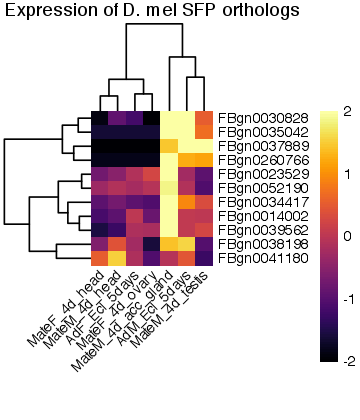

In [227]:
data = someTest
data = log2(data+10)
data = t(scale(t(data), scale=F)) # center rows, mean substracted
data[data < -2] = -2
data[data > 2] = 2

options(repr.plot.width = 3, repr.plot.height = 3.5)
pheatmap(
  mat               = data,
  color             = inferno(100),
#   breaks            = mat_breaks,
  border_color      = NA,
#   labels_col        = c("carcass", "head", "ovaries", "rep. tract"),
  show_colnames     = TRUE,
#   show_rownames     = FALSE,
#   annotation_row    = virgin.factor.labeling,
#   annotation_colors = mat_colors,
  drop_levels       = TRUE,
#   annotation_names_row = F,
  main              = "Expression of D. mel SFP orthologs",
#   filename          = "Figures/supergene_transcripts_heatmap.pdf",
#   width             = 4, 
#   height            = 5,
  fontsize          = 8    
)

In [228]:
someTest = subset(mel_modENCODE_matrix2, rownames(mel_modENCODE_matrix2) %in% unique(Sperm_orths_aeg_mel$FBgn_ID))
someTest = someTest[complete.cases(someTest), ] 
someTest = subset(someTest, rowSums(someTest) > 20)

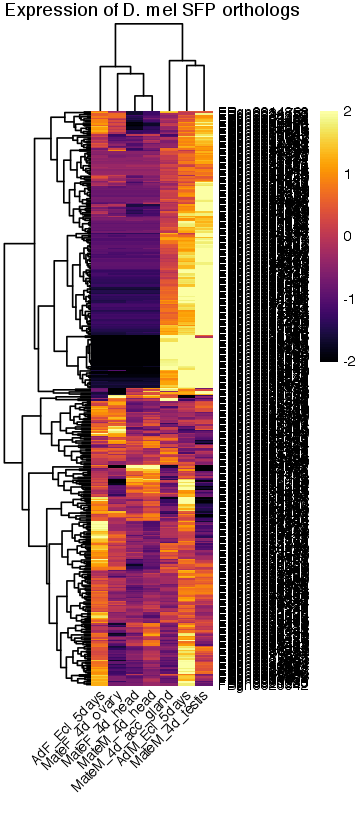

In [229]:
data = someTest
data = log2(data+10)
data = t(scale(t(data), scale=F)) # center rows, mean substracted
data[data < -2] = -2
data[data > 2] = 2

options(repr.plot.width = 3, repr.plot.height = 7)
pheatmap(
  mat               = data,
  color             = inferno(100),
#   breaks            = mat_breaks,
  border_color      = NA,
#   labels_col        = c("carcass", "head", "ovaries", "rep. tract"),
  show_colnames     = TRUE,
#   show_rownames     = FALSE,
#   annotation_row    = virgin.factor.labeling,
#   annotation_colors = mat_colors,
  drop_levels       = TRUE,
#   annotation_names_row = F,
  main              = "Expression of D. mel SFP orthologs",
#   filename          = "Figures/supergene_transcripts_heatmap.pdf",
#   width             = 4, 
#   height            = 5,
  fontsize          = 8    
)

#### _Ae. albopictus_:

The _Ae. alb_ SFP and sperm proteomes were produced with transcript IDs that don't match the current albopictus assembly. To match those, we blasted the peptide sequences provided in the supplement of Boes _et al._ to the current albopictus protein database. In turn, we also did reciprocal protein blast between _Ae. aeg_ and _Ae. alb_. First let's output the list of gene names for the _Ae. alb_ SFPs and sperm proteins:

In [230]:
albSFPs_v_alb = read.csv("Blast_results/albSFPs_v_alb.longestIsoform.blastP.outfmt6", header = F, sep = "\t")
colnames(albSFPs_v_alb) = c("qseqid","sseqid","pident","length","mismatch","gapopen","qstart","qend","sstart","send","evalue","bitscore")
albSperm_v_alb = read.csv("Blast_results/albSperm_v_alb.longestIsoform.blastP.outfmt6", header = F, sep = "\t")
colnames(albSperm_v_alb) = c("qseqid","sseqid","pident","length","mismatch","gapopen","qstart","qend","sstart","send","evalue","bitscore")

# albSFPs_v_alb$gene_id = gsub('-P.*', '', albSFPs_v_alb$sseqid)
# albSperm_v_alb$gene_id = gsub('-P.*', '', albSperm_v_alb$sseqid)

alb_SFPs = unique(albSFPs_v_alb$sseqid)
alb_SpermProts = unique(albSperm_v_alb$sseqid)

In [231]:
length(alb_SpermProts)

[1] 109

We'll output a list from the orthology relationship inferred by orthoDB:

In [232]:
alb_gene_orth_to_aegSFPs = filter(rel.orthoDB, (Aedes.aegypti %in% SFPs_locID | Aedes.aegypti %in% SFPs_overlap_locID) & Aedes.albopictus != "NA")
nrow(alb_gene_orth_to_aegSFPs)

# need to disaggregate the Ae. alb column:
alb_gene_orth_to_aegSFPs.tmp = alb_gene_orth_to_aegSFPs %>%  mutate(Aedes.albopictus = strsplit(as.character(Aedes.albopictus), ";")) %>% 
    unnest(Aedes.albopictus)

nrow(alb_gene_orth_to_aegSFPs.tmp)

(alb_gene_orth_to_aegSFPs = filter(alb_gene_orth_to_aegSFPs.tmp, Aedes.albopictus %in% alb_SFPs)$Aedes.albopictus)
length(alb_gene_orth_to_aegSFPs)

[1] 275

[1] 756

[1] "109426026" "109430035" "109407571" "109413801" "109424980" "109621462"
 [7] "109406409" "109431626" "109418802" "109398574" "109429732" "109408337"
[13] "109426535" "109428646" "109408337" "109426535" "109428646" "109407318"
[19] "109426909" "109397057" "109412137" "109423014" "109425680" "109408420"
[25] "109415861" "109412859" "109422005" "109401040" "109431782" "109404691"
[31] "109623000" "109402336" "109404860" "109404860" "109409682" "109425340"
[37] "109416620" "109425980" "109430022" "109408243" "109424285" "109421612"
[43] "109405148" "109410834" "109412047" "109400090" "109424053" "109421613"
[49] "109422142" "109412254" "109431179" "109407082" "109399618" "109623267"
[55] "109396991" "109399517" "109409041" "109622865" "109421611" "109418082"
[61] "109407992" "109399798" "109419385" "109396999" "109424326" "109417127"
[67] "109409273" "109428700" "109419572" "109409276" "109416205" "109414616"
[73] "109401465" "109410456" "109401466" "109407317" "109409620" "109408491"
[79] "109419252" "109415284" "109622596" "109411943" "109622322" "109621385"
[85] "109419113" "109423371"

[1] 86

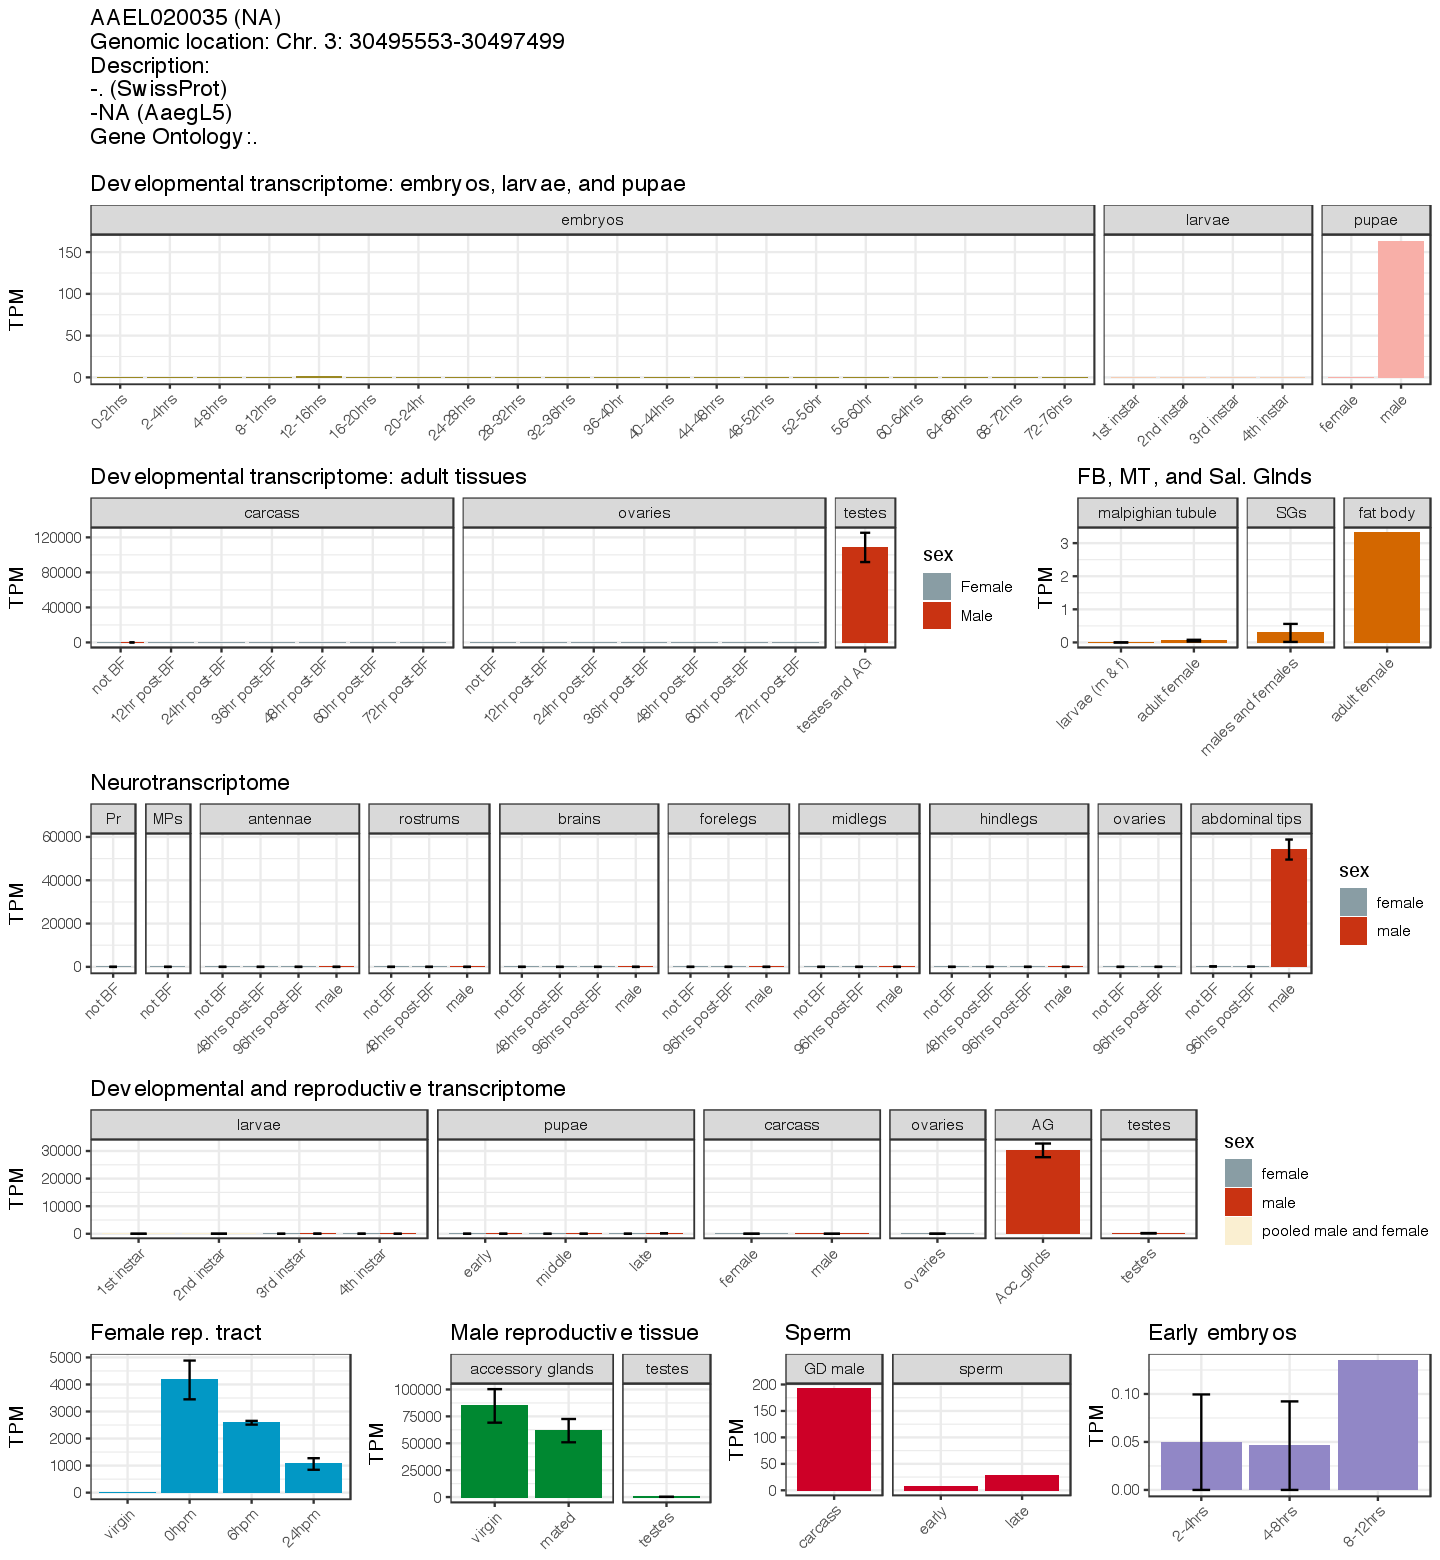

In [233]:
options(repr.plot.width = 12, repr.plot.height = 13)
suppressWarnings(compGeneBarplot("AAEL020035"))

In [234]:
alb_gene_orth_to_aegSpermProts = filter(rel.orthoDB, Aedes.aegypti %in% SpermProtsOnly_locID & Aedes.albopictus != "NA")

# need to disaggregate the Ae. alb column:
alb_gene_orth_to_aegSpermProts.tmp = alb_gene_orth_to_aegSpermProts %>%  mutate(Aedes.albopictus = strsplit(as.character(Aedes.albopictus), ";")) %>% 
    unnest(Aedes.albopictus)
(alb_gene_orth_to_aegSpermProts = filter(alb_gene_orth_to_aegSpermProts.tmp, Aedes.albopictus %in% alb_SpermProts)$Aedes.albopictus)
length(alb_gene_orth_to_aegSpermProts)

[1] "109405136" "109414845" "109420720" "109423800" "109409617" "109407274"
 [7] "109423305" "109413325" "109621244" "109398639" "109402811" "109402811"
[13] "109420933" "109427898" "109397084" "109408606" "109418450" "109418450"
[19] "109425568" "109423840" "109420827" "109428263" "109426342" "109425591"
[25] "109406139" "109623287" "109402398" "109420221" "109406200" "109403864"
[31] "109406200" "109403864" "109399561" "109422930" "109431856" "109431856"
[37] "109410410" "109408346" "109404804" "109416255" "109430117" "109420157"
[43] "109413675" "109414298" "109418928" "109405358" "109401235" "109415318"
[49] "109398714" "109431645" "109415480" "109429527" "109398718" "109422158"
[55] "109401355" "109398460" "109429290" "109411640" "109426786" "109402024"
[61] "109623091" "109432550" "109408551" "109433123" "109407222" "109415663"
[67] "109432895" "109416171" "109414164" "109411733" "109426050" "109415295"
[73] "109401638" "109421383" "109424015" "109409863" "109431053" "109413463"
[79] "109426592" "109420901" "109420901" "109417149" "109397070" "109409932"
[85] "109397804" "109398975" "109425537"

[1] 87

### Output supplementary tables:

In [235]:
patterns <- c("A1", "A9", "A6")
str(patterns)
str(as.character(mel_sperm.II$FBgn_ID))

 chr [1:3] "A1" "A9" "A6"
 chr [1:1770] "FBgn0000042" "FBgn0000043" "FBgn0000044" "FBgn0000045" ...


In [236]:
paste(as.character(mel_sperm.II$FBgn_ID), collapse="|")
paste(as.character(mel_SFPs$FBgn_ID), collapse="|")

[1] "FBgn0000042|FBgn0000043|FBgn0000044|FBgn0000045|FBgn0000046|FBgn0000055|FBgn0000064|FBgn0000083|FBgn0000100|FBgn0000116|FBgn0000253|FBgn0000261|FBgn0000276|FBgn0000299|FBgn0000319|FBgn0000409|FBgn0000454|FBgn0000556|FBgn0000559|FBgn0000579|FBgn0000615|FBgn0000667|FBgn0001091|FBgn0001092|FBgn0001098|FBgn0001114|FBgn0001124|FBgn0001125|FBgn0001128|FBgn0001142|FBgn0001149|FBgn0001186|FBgn0001197|FBgn0001216|FBgn0001218|FBgn0001220|FBgn0001224|FBgn0001225|FBgn0001226|FBgn0001230|FBgn0001233|FBgn0001247|FBgn0001248|FBgn0001258|FBgn0001281|FBgn0001942|FBgn0001989|FBgn0002031|FBgn0002526|FBgn0002567|FBgn0002570|FBgn0002579|FBgn0002590|FBgn0002593|FBgn0002607|FBgn0002622|FBgn0002626|FBgn0002719|FBgn0002772|FBgn0002773|FBgn0002789|FBgn0002855|FBgn0002865|FBgn0002921|FBgn0003071|FBgn0003074|FBgn0003132|FBgn0003134|FBgn0003137|FBgn0003149|FBgn0003274|FBgn0003279|FBgn0003360|FBgn0003371|FBgn0003423|FBgn0003462|FBgn0003517|FBgn0003676|FBgn0003721|FBgn0003748|FBgn0003884|FBgn0003886|FBgn0003887|FBgn0003888|FBgn0003889|FBgn0003890|FBgn0003942|FBgn0004117|FBgn0004169|FBgn0004175|FBgn0004181|FBgn0004363|FBgn0004397|FBgn0004403|FBgn0004432|FBgn0004507|FBgn0004654|FBgn0004867|FBgn0004888|FBgn0004907|FBgn0005533|FBgn0005585|FBgn0005593|FBgn0005666|FBgn0005671|FBgn0010078|FBgn0010100|FBgn0010198|FBgn0010213|FBgn0010217|FBgn0010226|FBgn0010265|FBgn0010333|FBgn0010348|FBgn0010352|FBgn0010397|FBgn0010408|FBgn0010409|FBgn0010411|FBgn0010412|FBgn0010424|FBgn0010434|FBgn0010435|FBgn0010438|FBgn0010548|FBgn0010551|FBgn0010612|FBgn0011211|FBgn0011227|FBgn0011230|FBgn0011244|FBgn0011270|FBgn0011272|FBgn0011273|FBgn0011284|FBgn0011296|FBgn0011361|FBgn0011455|FBgn0011559|FBgn0011694|FBgn0011726|FBgn0011760|FBgn0011768|FBgn0012036|FBgn0013276|FBgn0013301|FBgn0013325|FBgn0013673|FBgn0013674|FBgn0013675|FBgn0013733|FBgn0013749|FBgn0013810|FBgn0013811|FBgn0013812|FBgn0013813|FBgn0013954|FBgn0013981|FBgn0013995|FBgn0013997|FBgn0014002|FBgn0014009|FBgn0014010|FBgn0014020|FBgn0014026|FBgn0014028|FBgn0014141|FBgn0014189|FBgn0014863|FBgn0014868|FBgn0014869|FBgn0015031|FBgn0015221|FBgn0015222|FBgn0015245|FBgn0015288|FBgn0015521|FBgn0015584|FBgn0015586|FBgn0015622|FBgn0015623|FBgn0015756|FBgn0015766|FBgn0015790|FBgn0015872|FBgn0016075|FBgn0016119|FBgn0016120|FBgn0016687|FBgn0016691|FBgn0016700|FBgn0017545|FBgn0017566|FBgn0017567|FBgn0017579|FBgn0019624|FBgn0019644|FBgn0019830|FBgn0019886|FBgn0019936|FBgn0019957|FBgn0019960|FBgn0020235|FBgn0020236|FBgn0020238|FBgn0020255|FBgn0020370|FBgn0020618|FBgn0020653|FBgn0020765|FBgn0020910|FBgn0021765|FBgn0021795|FBgn0021906|FBgn0021944|FBgn0021967|FBgn0022097|FBgn0022160|FBgn0022355|FBgn0022382|FBgn0022709|FBgn0023143|FBgn0023175|FBgn0023212|FBgn0024352|FBgn0024432|FBgn0024733|FBgn0024945|FBgn0024992|FBgn0025111|FBgn0025286|FBgn0025352|FBgn0025612|FBgn0025628|FBgn0025700|FBgn0026061|FBgn0026141|FBgn0026150|FBgn0026189|FBgn0026372|FBgn0026380|FBgn0026403|FBgn0026409|FBgn0026415|FBgn0026418|FBgn0026563|FBgn0026761|FBgn0027291|FBgn0027552|FBgn0027560|FBgn0027568|FBgn0027580|FBgn0027590|FBgn0027610|FBgn0027779|FBgn0027785|FBgn0027786|FBgn0027932|FBgn0028336|FBgn0028342|FBgn0028372|FBgn0028379|FBgn0028479|FBgn0028491|FBgn0028513|FBgn0028540|FBgn0028560|FBgn0028567|FBgn0028570|FBgn0028646|FBgn0028665|FBgn0028669|FBgn0028670|FBgn0028692|FBgn0028697|FBgn0028734|FBgn0028737|FBgn0028848|FBgn0028856|FBgn0028858|FBgn0028870|FBgn0028880|FBgn0028892|FBgn0028902|FBgn0028903|FBgn0028986|FBgn0028987|FBgn0028997|FBgn0029084|FBgn0029153|FBgn0029176|FBgn0029501|FBgn0029502|FBgn0029507|FBgn0029508|FBgn0029648|FBgn0029659|FBgn0029667|FBgn0029676|FBgn0029709|FBgn0029712|FBgn0029722|FBgn0029745|FBgn0029747|FBgn0029762|FBgn0029854|FBgn0029859|FBgn0029868|FBgn0029888|FBgn0029890|FBgn0029897|FBgn0029990|FBgn0029993|FBgn0030004|FBgn0030026|FBgn0030038|FBgn0030136|FBgn0030178|FBgn0030195|FBgn0030218|FBgn0030224|FBgn0030239|FBgn0030283|FBgn0030306|FBgn0030307|FBgn0030359|FBgn0030362|FBgn0030376|FBgn0030384|FBgn0030440|FBgn0030449|FBgn0030466|FBgn0030478

[1] "FBgn0051779|FBgn0002855|FBgn0002856|FBgn0015583|FBgn0023415|FBgn0023414|FBgn0011559|FBgn0034152|FBgn0034153|FBgn0053530|FBgn0015584|FBgn0020509|FBgn0015585|FBgn0003034|FBgn0015586|FBgn0002863|FBgn0013745|FBgn0000094|FBgn0016123|FBgn0083938|FBgn0250831|FBgn0047334|FBgn0052203|FBgn0004780|FBgn0039596|FBgn0038014|FBgn0038395|FBgn0034638|FBgn0037036|FBgn0037039|FBgn0032853|FBgn0032843|FBgn0035455|FBgn0034195|FBgn0037038|FBgn0033164|FBgn0033165|FBgn0037204|FBgn0038067|FBgn0038069|FBgn0032964|FBgn0040341|FBgn0028944|FBgn0037650|FBgn0039599|FBgn0039540|FBgn0033572|FBgn0035933|FBgn0033868|FBgn0032834|FBgn0250847|FBgn0039598|FBgn0259226|FBgn0032331|FBgn0030623|FBgn0034415|FBgn0034417|FBgn0031617|FBgn0030643|FBgn0031412|FBgn0033167|FBgn0033831|FBgn0032275|FBgn0250841|FBgn0038829|FBgn0032868|FBgn0250842|FBgn0038919|FBgn0037433|FBgn0034512|FBgn0036837|FBgn0036795|FBgn0036794|FBgn0043825|FBgn0036091|FBgn0042182|FBgn0034753|FBgn0023529|FBgn0031468|FBgn0050395|FBgn0050463|FBgn0050486|FBgn0050488|FBgn0051016|FBgn0051418|FBgn0051419|FBgn0051515|FBgn0038198|FBgn0051659|FBgn0051680|FBgn0051704|FBgn0259225|FBgn0051872|FBgn0032122|FBgn0052201|FBgn0052382|FBgn0052383|FBgn0052667|FBgn0052833|FBgn0036495|FBgn0053462|FBgn0036459|FBgn0054002|FBgn0054033|FBgn0054034|FBgn0054051|FBgn0262005|FBgn0083965|FBgn0083966|FBgn0085464|FBgn0035042|FBgn0260766|FBgn0039568|FBgn0034229|FBgn0030828|FBgn0034154|FBgn0039521|FBgn0036186|FBgn0036154|FBgn0036970|FBgn0034162|FBgn0030932|FBgn0032367|FBgn0036969|FBgn0038918|FBgn0036527|FBgn0033999|FBgn0037664|FBgn0031746|FBgn0035216|FBgn0032080|FBgn0030222|FBgn0034435|FBgn0039597|FBgn0033942|FBgn0036110|FBgn0005585|FBgn0004629|FBgn0250832|FBgn0086712|FBgn0000592|FBgn0010470|FBgn0015000|FBgn0039562|FBgn0041629|FBgn0001218|FBgn0040107|FBgn0040098|FBgn0040097|FBgn0040093|FBgn0040092|FBgn0004426|FBgn0028416|FBgn0260745|FBgn0004414|FBgn0011668|FBgn0011669|FBgn0011670|FBgn0053126|FBgn0052190|FBgn0043539|FBgn0043530|FBgn0034471|FBgn0043533|FBgn0034474|FBgn0043532|FBgn0026058|FBgn0041621|FBgn0014002|FBgn0004181|FBgn0011694|FBgn0022770|FBgn0019948|FBgn0030362|FBgn0010406|FBgn0037889|FBgn0259949|FBgn0259951|FBgn0259952|FBgn0261054|FBgn0259956|FBgn0259958|FBgn0259959|FBgn0261055|FBgn0259962|FBgn0259963|FBgn0259964|FBgn0261056|FBgn0259965|FBgn0261057|FBgn0261058|FBgn0259966|FBgn0259967|FBgn0259968|FBgn0259969|FBgn0259970|FBgn0259972|FBgn0261059|FBgn0261059|FBgn0259973|FBgn0259974|FBgn0259975|FBgn0261060|FBgn0261061|FBgn0028988|FBgn0028987|FBgn0028986|FBgn0083141|FBgn0041180|FBgn0003862|FBgn0045823"

In [237]:
nrow(ejaculotome_assign)
orthologs.subset = filter(rel.orthoDB, Aedes.aegypti %in% unique(ejaculotome_assign$loc_ID))[,c(6,1,2)]
colnames(orthologs.subset) = c("Aedes.aegypti", "Ae. albopictus orthologs", "D. melanogaster orthologs")
head(orthologs.subset)
orthologs.subset$`D. mel sperm?` = ifelse(grepl(paste(as.character(mel_sperm.II$FBgn_ID), collapse="|"), orthologs.subset$`D. melanogaster orthologs`), "yes", "no")
orthologs.subset$`D. mel SFP?` = ifelse(grepl(paste(as.character(mel_SFPs$FBgn_ID), collapse="|"), orthologs.subset$`D. melanogaster orthologs`), "yes", "no")
orthologs.subset$`Ae. alb SFP?` = ifelse(grepl(paste(alb_SFPs, collapse="|"), orthologs.subset$`Ae. albopictus orthologs`), "yes", "no")
head(orthologs.subset)
ejaculotome_assign3 = merge(ejaculotome_assign, orthologs.subset, by.x = "loc_ID", by.y = "Aedes.aegypti", all.x = T)

[1] 1562

Aedes.aegypti Ae. albopictus orthologs               
1 LOC5580049    109405621;109416243                    
2 LOC5571804    109427541                              
3 LOC5572759    109403661;109409564;109407986;109430474
4 LOC110678659  109426276;109402121                    
5 LOC5568948    109421523;109409127                    
6 LOC110678181  109401577;109397388                    
  D. melanogaster orthologs
1 FBgn0000152              
2 FBgn0021765              
3 FBgn0264294;FBgn0029854  
4                          
5 FBgn0267432              
6

Aedes.aegypti Ae. albopictus orthologs               
1 LOC5580049    109405621;109416243                    
2 LOC5571804    109427541                              
3 LOC5572759    109403661;109409564;109407986;109430474
4 LOC110678659  109426276;109402121                    
5 LOC5568948    109421523;109409127                    
6 LOC110678181  109401577;109397388                    
  D. melanogaster orthologs D. mel sperm? D. mel SFP? Ae. alb SFP?
1 FBgn0000152               no            no          no          
2 FBgn0021765               yes           no          no          
3 FBgn0264294;FBgn0029854   yes           no          no          
4                           no            no          yes         
5 FBgn0267432               yes           no          no          
6                           no            no          no

In [238]:
table_s1 = unique(subset(ejaculotome_assign3, select = c("gene_ID", "protein", "protein.name", "sperm_combined_unique", "sperm_combined_spectra", "FPR_sperm", "semen_combined_unique", "semen_combined_spectra", "FPR_semen", "virMAG", "depMAG", "testes", "signalP","Degner_classification", "Sirot_classification_2", 'Ae. albopictus orthologs', 'Ae. alb SFP?', 'D. melanogaster orthologs', 'D. mel sperm?', 'D. mel SFP?')))
colnames(table_s1) = c("VectorBase ID", "RefSeq ID", "Description", "Sperm: unique peptides", "Sperm: spectral count", "Sperm: FDR", "Semen: unique peptides", "Semen: spectral count", "Semen: FDR", "TPM: virgin MAG", "TPM: mated MAG", "TPM: testes", "signalP?","Classification in current study", "Classification in Sirot et al (2011)", 'Ae. albopictus orthologs', 'Ae. alb SFP?', 'D. melanogaster orthologs', 'D. mel sperm?', 'D. mel SFP?')
# write.table(table_s1, "Results/Supplementary_materials/Table_S1.ejaculotomeCharacterization.txt", quote = F, sep = "\t", row.names = F)

In [239]:
# table_s2 = subset(subset(ejaculotome_assign, grepl("elongation factor", protein.name) | grepl("translation", protein.name) | grepl("ribosom", protein.name)), select = c("gene_ID", "protein", "loc_ID", "protein.name", "Degner_classification"))
# write.table(table_s2, "Results/Supplementary_materials/Table_S2.translationProteins.txt", quote = F, sep = "\t", row.names = F)

In [240]:
# table_s3 = filter(ejaculotome_assign, Degner_classification == "SFP")
# table_s3 = unique(subset(table_s3, select = c("gene_ID", "loc_ID", "gene_name", "protein", "protein.name", "Semen_total_normalized_PSM", "Sirot_classification_2")))
# write.table(table_s3, "Results/Supplementary_materials/Table_S3.HighConf_SFPs.txt", row.names = F, quote = F, sep = "\t")

In [241]:
# table_s4 = filter(ejaculotome_assign, Degner_classification == "Overlap")
# table_s4 = unique(subset(table_s4, select = c("gene_ID", "loc_ID", "gene_name", "protein", "protein.name", "Semen_total_normalized_PSM", "Sirot_classification_2")))
# write.table(table_s4, "Results/Supplementary_materials/Table_S4.Overlap_SFPs.txt", row.names = F, quote = F, sep = "\t")

In [242]:
# table_s5 = filter(ejaculotome_assign, Degner_classification == "Overlap")
# table_s5 = unique(subset(table_s4, select = c("gene_ID", "loc_ID", "gene_name", "protein", "protein.name", "Semen_total_normalized_PSM", "Sirot_classification_2")))
# write.table(table_s4, "Results/Supplementary_materials/Table_S4.Overlap_SFPs.txt", row.names = F, quote = F, sep = "\t")

###### KEGG analysis on gene sets:

First create an Ae. aegypti KEGG database:

In [243]:
ah <- AnnotationHub()
aagDB <- query(ah, "Aedes")[["AH66788"]]
aagDB

Warning message:
“database may not be current
  database: ‘/Users/yazahmed//.AnnotationHub/annotationhub.sqlite3’
  reason: do not know how to convert 'content(GET(url, proxy))' to class “POSIXct””snapshotDate(): 2018-10-24
downloading 0 resources
loading from cache 
    ‘/Users/yazahmed//.AnnotationHub/73534’

Please see: help('select') for usage information


OrgDb object:
| DBSCHEMAVERSION: 2.1
| DBSCHEMA: NOSCHEMA_DB
| ORGANISM: Aedes aegypti
| SPECIES: Aedes aegypti
| CENTRALID: GID
| Taxonomy ID: 7159
| Db type: OrgDb
| Supporting package: AnnotationDbi

Or we can use the available KEGG database for _Ae. aegypti_ if it's available:

In [247]:
search_kegg_organism('aag', by='kegg_code')

kegg_code scientific_name common_name          
100 aag       Aedes aegypti   yellow fever mosquito

Now we can run a KEGG over-represntation test on the full list of SFPs:

In [244]:
SFPs_NCBI_id = gsub("LOC", "", c(SFPs_locID, SFPs_overlap_locID))
sfp_kegg <- enrichKEGG(gene = SFPs_NCBI_id, organism = 'aag')
head(as.data.frame(sfp_kegg))
# write.table(as.data.frame(sfp_kegg), file = "Results/significant_KEGG_terms_SFPs.txt", quote = F, sep = "\t", row.names = F)

ID       Description                  GeneRatio BgRatio pvalue      
aag04145 aag04145 Phagosome                    16/122    63/2451 2.707301e-08
aag04142 aag04142 Lysosome                     17/122    74/2451 4.894190e-08
aag01200 aag01200 Carbon metabolism            17/122    82/2451 2.465637e-07
aag00010 aag00010 Glycolysis / Gluconeogenesis 10/122    37/2451 7.179611e-06
aag00071 aag00071 Fatty acid degradation       8/122     31/2451 8.998054e-05
aag00970 aag00970 Aminoacyl-tRNA biosynthesis  8/122     40/2451 6.006218e-04
         p.adjust     qvalue      
aag04145 1.664025e-06 1.107633e-06
aag04142 1.664025e-06 1.107633e-06
aag01200 5.588776e-06 3.720083e-06
aag00010 1.220534e-04 8.124297e-05
aag00071 1.223735e-03 8.145607e-04
aag00970 5.993484e-03 3.989471e-03
         geneID                                                                                                                                    
aag04145 5569632/5577489/5579216/5578276/5569700/5568081/110675318/5568788/5571080/5575718/5572478/5576245/5576221/5567068/5578943/5566119         
aag04142 5566514/5577626/5567014/5569632/5578088/5576894/5579216/5580010/5575792/5568081/110675318/5575109/5578293/5576221/23687932/5567565/5578943
aag01200 5577893/5571932/5567423/5568472/5564469/5572923/5564492/5574496/5563904/5577095/5564584/110680419/5567037/5573374/5580166/5568365/5570276 
aag00010 5563591/5571932/5567423/5568472/5572750/5575706/5564492/5577095/5564584/5580166                                                           
aag00071 5565372/5565366/5566981/5564469/5573712/5572923/5563904/110680419                                                                         
aag00970 5579902/5565025/5569067/5567972/5565854/5568150/5576333/5570018                                                                           
         Count
aag04145 16   
aag04142 17   
aag01200 17   
aag00010 10   
aag00071  8   
aag00970  8

In [254]:
SpermProts_NCBI_id = gsub("LOC", "", SpermProts_locID)
sperm_kegg <- enrichKEGG(gene = SpermProts_NCBI_id, organism = 'aag')
head(as.data.frame(sperm_kegg))
# write.table(as.data.frame(sperm_kegg), file = "Results/significant_KEGG_terms_SpermProts.txt", quote = F, sep = "\t", row.names = F)

ID       Description                                GeneRatio BgRatio 
aag03050 aag03050 Proteasome                                 32/388    36/2449 
aag01200 aag01200 Carbon metabolism                          51/388    82/2449 
aag00020 aag00020 Citrate cycle (TCA cycle)                  25/388    31/2449 
aag00190 aag00190 Oxidative phosphorylation                  44/388    107/2449
aag00280 aag00280 Valine, leucine and isoleucine degradation 21/388    36/2449 
aag00970 aag00970 Aminoacyl-tRNA biosynthesis                22/388    40/2449 
         pvalue       p.adjust     qvalue      
aag03050 2.598880e-22 1.343538e-20 9.753449e-21
aag01200 3.088592e-22 1.343538e-20 9.753449e-21
aag00020 1.472690e-15 4.270802e-14 3.100401e-14
aag00190 1.154932e-10 2.511978e-09 1.823577e-09
aag00280 5.311869e-09 9.242652e-08 6.709729e-08
aag00970 1.024346e-08 1.485301e-07 1.078258e-07
         geneID                                                                                                                                                                                                                                                                                                                                                                                                                        
aag03050 5570524/5564146/5564317/5571045/5572867/5574484/5565869/5565318/5564545/5575843/5567996/5575828/5567857/5567383/5579168/5576266/5566848/5567581/5574980/5568998/5577035/5573753/5577483/5568716/5576478/5578121/5567100/5565051/110678859/5572582/5565085/5565637                                                                                                                                                             
aag01200 5566298/5568292/5564469/5564225/5572923/5572925/5565774/5564492/23687404/5574496/5580315/5566975/5569520/5568558/5568430/5570205/5570233/5573976/5567031/5567259/5568498/5577369/5572547/5578303/5564768/5572254/5568019/5568202/5563904/5575386/5575274/5575223/5577095/5566309/5568521/5564584/5571930/110680419/5567037/110677952/110680500/5573374/5580166/5575986/5566668/5565629/5576532/5568365/5578916/5570276/5573238
aag00020 5566298/5568292/5572925/5564492/5564509/5580315/5569520/5568430/5570205/5570233/5573976/5577369/5578303/5572254/5575386/5575274/5575223/5566309/5568521/5564584/110677952/5575986/5566668/5570276/5573238                                                                                                                                                                                                                     
aag00190 5566236/5578538/5564962/5578833/5573990/5575492/5575914/5571150/5569497/5571429/5572650/5578796/5577113/5566092/5566662/5580036/5568081/110675318/5567821/5573968/110678469/5571080/5575718/5574977/5572478/5577026/5564798/5576223/5576214/5575223/5571907/5574761/5566654/110678504/5574746/5577499/5567068/5578943/5566119/5571450/5576501/5570670/5573238/5569898                                                         
aag00280 5574420/5564469/5576553/5573712/5572923/5571804/5569333/5573392/5566975/5568558/5568498/5571397/5568202/5563904/5578522/5572081/5568521/5574197/110680419/110680500/5563729                                                                                                                                                                                                                                                   
aag00970 5574912/5570738/5563744/5565025/5573525/5573411/5569067/5569078/5567972/5566973/5565854/5575102/5568150/5573984/5576333/5566937/5570018/5580242/5564593/5567071/5566217/5565159                                                                                                                                                                                                                                               
         Count
aag03050 32   
aag01200 51   
aag00020 25   
aag00190 44   
aag00280 21   
aag00970 22

Let's do the analysis with the *An. gambiae* orthologues. First we'll recreate the orthoDB object with the _An gambiae_ column:

In [256]:
rel.orthoDB = subset(orthoDB, select = c("Aedes.aegypti", "Aedes.albopictus","Drosophila.melanogaster", "Manduca.sexta", "Apis.mellifera", "Mus.musculus", "Anopheles.gambiae"))
head(rel.orthoDB, n = 2)

Aedes.aegypti Aedes.albopictus    Drosophila.melanogaster Manduca.sexta
1 LOC5580049    109405621;109416243 FBgn0000152                          
2 LOC5579046    109401550;109402893 FBgn0036545             Msex2.01676  
  Apis.mellifera Mus.musculus Anopheles.gambiae
1                102566       1279184          
2 409614         69836;66350  1270816

We'll need to disaggregate the _aegypti_ gene ID column first:

In [257]:
rel.orthoDB = rel.orthoDB %>% mutate(Aedes.aegypti = strsplit(as.character(Aedes.aegypti), ";")) %>% unnest(Aedes.aegypti)
head(rel.orthoDB)

Aedes.albopictus                        Drosophila.melanogaster Manduca.sexta
1 109405621;109416243                     FBgn0000152                          
2 109401550;109402893                     FBgn0036545             Msex2.01676  
3 109411338;109427062;109427063;109411352                                      
4 109622201;109408641                     FBgn0016983             Msex2.12286  
5 109622201;109408641                     FBgn0016983             Msex2.12286  
6 109621286;109422858                     FBgn0261934                          
  Apis.mellifera Mus.musculus Anopheles.gambiae Aedes.aegypti
1                102566       1279184           LOC5580049   
2 409614         69836;66350  1270816           LOC5579046   
3                             1282046           LOC5569834   
4 409408         67459        1276867           LOC110677712 
5 409408         67459        1276867           LOC5563554   
6                             1274894           LOC23687995

Double check the gambia organism KEGG name:

In [258]:
search_kegg_organism('gambiae')

kegg_code scientific_name   common_name
99 aga       Anopheles gambiae mosquito

Make two listsof _An gambiae_ sperm and SFP orthologs:

In [265]:
An.gam_SFP_orths = unique(unlist(strsplit(as.character(subset(rel.orthoDB, Aedes.aegypti %in% c(SFPs_locID , SFPs_overlap_locID) & Anopheles.gambiae != "")$Anopheles.gambiae), ";")))
An.gam_sperm_orths = unique(unlist(strsplit(as.character(subset(rel.orthoDB, Aedes.aegypti %in% SpermProts_locID & Anopheles.gambiae != "")$Anopheles.gambiae), ";")))

Write out this list and convert the Entrez gene IDs to Vectorbase gene IDs:

In [266]:
write.table(An.gam_SFP_orths, "proteomics/Other_species_proteomes/aGam.SFP.orths.txt", quote = F, row.names = F, col.names = F)
write.table(An.gam_sperm_orths, "proteomics/Other_species_proteomes/aGam.sperm.orths.txt", quote = F, row.names = F, col.names = F)

After conversion, load the new IDs:

In [276]:
An.gam_SFP_orths_IDs = read.csv("proteomics/Other_species_proteomes/Agam_SFP_orth_IDs.txt", header = T, sep = "\t")
An.gam_SFP_orths_vb = gsub(".*\\(", "", as.character(An.gam_SFP_orths_IDs$Gene.Name))
An.gam_SFP_orths_vb = gsub(")", "", An.gam_SFP_orths_vb)

An.gam_sperm_orths_IDs = read.csv("proteomics/Other_species_proteomes/Agam_sperm_orth_IDs.txt", header = T, sep = "\t")
An.gam_sperm_orths_vb = gsub(".*\\(", "", as.character(An.gam_sperm_orths_IDs$Gene.Name))
An.gam_sperm_orths_vb = gsub(")", "", An.gam_sperm_orths_vb)

In [277]:
aga_sperm_kegg <- enrichKEGG(gene = An.gam_SFP_orths_vb, organism = 'aga')
as.data.frame(aga_sperm_kegg)
# write.table(as.data.frame(sperm_kegg), file = "Results/significant_KEGG_terms_SpermProts.txt", quote = F, sep = "\t", row.names = F)

ID       Description                                 GeneRatio
aga04142 aga04142 Lysosome                                    19/124   
aga04145 aga04145 Phagosome                                   17/124   
aga01200 aga01200 Carbon metabolism                           16/124   
aga00010 aga00010 Glycolysis / Gluconeogenesis                10/124   
aga00071 aga00071 Fatty acid degradation                      8/124    
aga00620 aga00620 Pyruvate metabolism                         7/124    
aga00052 aga00052 Galactose metabolism                        6/124    
aga00410 aga00410 beta-Alanine metabolism                     5/124    
aga00030 aga00030 Pentose phosphate pathway                   5/124    
aga01212 aga01212 Fatty acid metabolism                       7/124    
aga00970 aga00970 Aminoacyl-tRNA biosynthesis                 9/124    
aga04141 aga04141 Protein processing in endoplasmic reticulum 12/124   
         BgRatio  pvalue       p.adjust     qvalue      
aga04142 71/2555  2.870803e-10 1.980854e-08 1.359854e-08
aga04145 61/2555  1.368041e-09 4.719742e-08 3.240097e-08
aga01200 82/2555  9.981116e-07 2.266947e-05 1.556257e-05
aga00010 32/2555  1.314172e-06 2.266947e-05 1.556257e-05
aga00071 28/2555  3.366328e-05 4.645532e-04 3.189153e-04
aga00620 29/2555  3.419418e-04 3.932331e-03 2.699540e-03
aga00052 22/2555  4.550734e-04 4.485723e-03 3.079444e-03
aga00410 18/2555  1.277968e-03 1.102247e-02 7.566915e-03
aga00030 20/2555  2.138236e-03 1.639314e-02 1.125387e-02
aga01212 41/2555  3.027891e-03 2.089245e-02 1.434264e-02
aga00970 65/2555  3.553461e-03 2.228989e-02 1.530199e-02
aga04141 110/2555 6.031787e-03 3.468277e-02 2.380968e-02
         geneID                                                                                                                                                                                                                                                                                                         
aga04142 AgaP_AGAP002387/AgaP_AGAP011940/AgaP_AGAP000721/AgaP_AGAP003021/AgaP_AGAP001587/AgaP_AGAP004533/AgaP_AGAP005846/AgaP_AGAP003711/AgaP_AGAP003277/AgaP_AGAP009486/AgaP_AGAP009651/AgaP_AGAP011859/AgaP_AGAP009621/AgaP_AGAP001267/AgaP_AGAP003879/AgaP_AGAP001082/AgaP_AGAP011828/AgaP_AGAP008584/AgaP_AGAP002879
aga04145 AgaP_AGAP002401/AgaP_AGAP000721/AgaP_AGAP001587/AgaP_AGAP010510/AgaP_AGAP005845/AgaP_AGAP010298/AgaP_AGAP001617/AgaP_AGAP003711/AgaP_AGAP001219/AgaP_AGAP001218/AgaP_AGAP009486/AgaP_AGAP007901/AgaP_AGAP002015/AgaP_AGAP010971/AgaP_AGAP003879/AgaP_AGAP011828/AgaP_AGAP002884                                
aga01200 AgaP_AGAP001951/AgaP_AGAP007975/AgaP_AGAP000184/AgaP_AGAP007258/AgaP_AGAP009685/AgaP_AGAP001630/AgaP_AGAP007642/AgaP_AGAP011208/AgaP_AGAP001420/AgaP_AGAP005662/AgaP_AGAP010421/AgaP_AGAP007784/AgaP_AGAP012167/AgaP_AGAP004362/AgaP_AGAP004159/AgaP_AGAP011833                                                
aga00010 AgaP_AGAP003350/AgaP_AGAP007975/AgaP_AGAP005860/AgaP_AGAP001630/AgaP_AGAP007642/AgaP_AGAP011208/AgaP_AGAP004880/AgaP_AGAP001420/AgaP_AGAP010421/AgaP_AGAP012167                                                                                                                                                
aga00071 AgaP_AGAP001951/AgaP_AGAP008596/AgaP_AGAP008769/AgaP_AGAP005662/AgaP_AGAP007784/AgaP_AGAP010130/AgaP_AGAP006821/AgaP_AGAP011833                                                                                                                                                                                
aga00620 AgaP_AGAP003350/AgaP_AGAP007975/AgaP_AGAP000184/AgaP_AGAP004880/AgaP_AGAP000416/AgaP_AGAP010421/AgaP_AGAP004159                                                                                                                                                                                                
aga00052 AgaP_AGAP005860/AgaP_AGAP001257/AgaP_AGAP005846/AgaP_AGAP007642/AgaP_AGAP011208/AgaP_AGAP012261                                     